In [662]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import cos, sin, sqrt, arctan2
import matplotlib.pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from astropy import units as u
from astropy.coordinates import SkyCoord
from gwbird import detectors
from gwbird import skymap
from gwbird import utils
from gwbird.overlap import Response
from gwbird.nell import AngularResponse
from gwbird import overlap
from gwbird import anisotropy
from gwbird import skymap
from gwbird import utils
from gwbird import detectors
from gwbird import pls
from gwbird.skymap import Basis, AngularPatternFunction
from gwbird.NANOGrav import NANOGrav_dir
from gwbird.nell import AngularResponse, Sensitivity_ell
import matplotlib.cm as cm


plt.rcParams['figure.dpi'] = 200
REarth = 6.371 * 1e6 #m
c = 3*1e8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [664]:
# load the pulsar catalog

N, p, D = detectors.get_NANOGrav_pulsars()

N = int(N/4)


2025-06-17 22:46:03.930 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


In [585]:
f = np.logspace(-9, -7, 100)

In [666]:
# normalization for tensor modes

for i in range(N):
    print(Response.overlap_pairwise(f, p[i], p[i], D[i], D[i], 't')[0])

1.0050955713837402
0.9951272467703495
1.0094415848538902
1.0055842825115913
0.9992792718759558
0.9991974837922345
1.008788348210317
1.0007839864110846
1.0015331383238961
0.9999549075781045
1.0046668363394873
0.9975326624216099
0.9921396993196834
1.001841071023354


In [667]:
# normalization for vector modes

for i in range(N):
    print(Response.overlap_pairwise(f, p[i], p[i], D[i], D[i], 'v')[0])

16.49478703686267
17.177640224281383
16.915674582102728
17.96420544918547
15.30836415812499
17.75451855632634
19.593817630124246
17.233197035404174
13.620202042897594
13.569632482794738
15.480814723436719
17.21158976658278
15.666506394473371
17.849450547414335


In [669]:
# normalization for scalar breathing modes

for i in range(N):
    print(Response.overlap_pairwise(f, p[i], p[i], D[i], D[i], 's')[0])

1.0050955713837402
0.9951272467703494
1.0094415848538905
1.0055842825115913
0.9992792718759558
0.9991974837922342
1.008788348210317
1.0007839864110841
1.0015331383238961
0.9999549075781047
1.004666836339487
0.9975326624216099
0.9921396993196835
1.0018410710233538


In [670]:
# normalization for scalar longitudinal modes   

for i in range(N):
    print(Response.overlap_pairwise(f, p[i], p[i], D[i], D[i], 'l')[0])

395.4136946903801
520.1608860525577
441.9604215226385
676.3694952186016
271.82204581508364
614.3131565085757
1061.406205305659
502.5315989280348
151.61444540416952
149.1334628987859
287.0999819490903
511.9181268557746
309.25878544165215
643.9914615720338


In [671]:
# normalization for circular polarization (has to be zero)

for i in range(N):
    print(Response.overlap_pairwise(f, p[i], p[i], D[i], D[i], 'V')[0])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# Overlap Reduction Function

In [707]:
gamma_ij_t = []
gamma_ij_v = []
gamma_ij_s = []
gamma_ij_l = []
gamma_ij_V = []
alpha_ij = []
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(p[i], p[j])))
        gamma_ij_t.append(Response.overlap_pairwise(f, p[i], p[j], D[i], D[j], 't'))
        gamma_ij_v.append(Response.overlap_pairwise(f, p[i], p[j], D[i], D[j], 'v'))
        gamma_ij_s.append(Response.overlap_pairwise(f, p[i], p[j], D[i], D[j], 's'))
        gamma_ij_l.append(Response.overlap_pairwise(f, p[i], p[j], D[i], D[j], 'l'))
        gamma_ij_V.append(Response.overlap_pairwise(f, p[i], p[j], D[i], D[j], 'V'))

gamma_ij_t = np.array(gamma_ij_t)
gamma_ij_v = np.array(gamma_ij_v)
gamma_ij_s = np.array(gamma_ij_s)
gamma_ij_l = np.array(gamma_ij_l)
gamma_ij_V = np.array(gamma_ij_V)
alpha_ij = np.array(alpha_ij)

In [708]:
print(gamma_ij_V[:,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


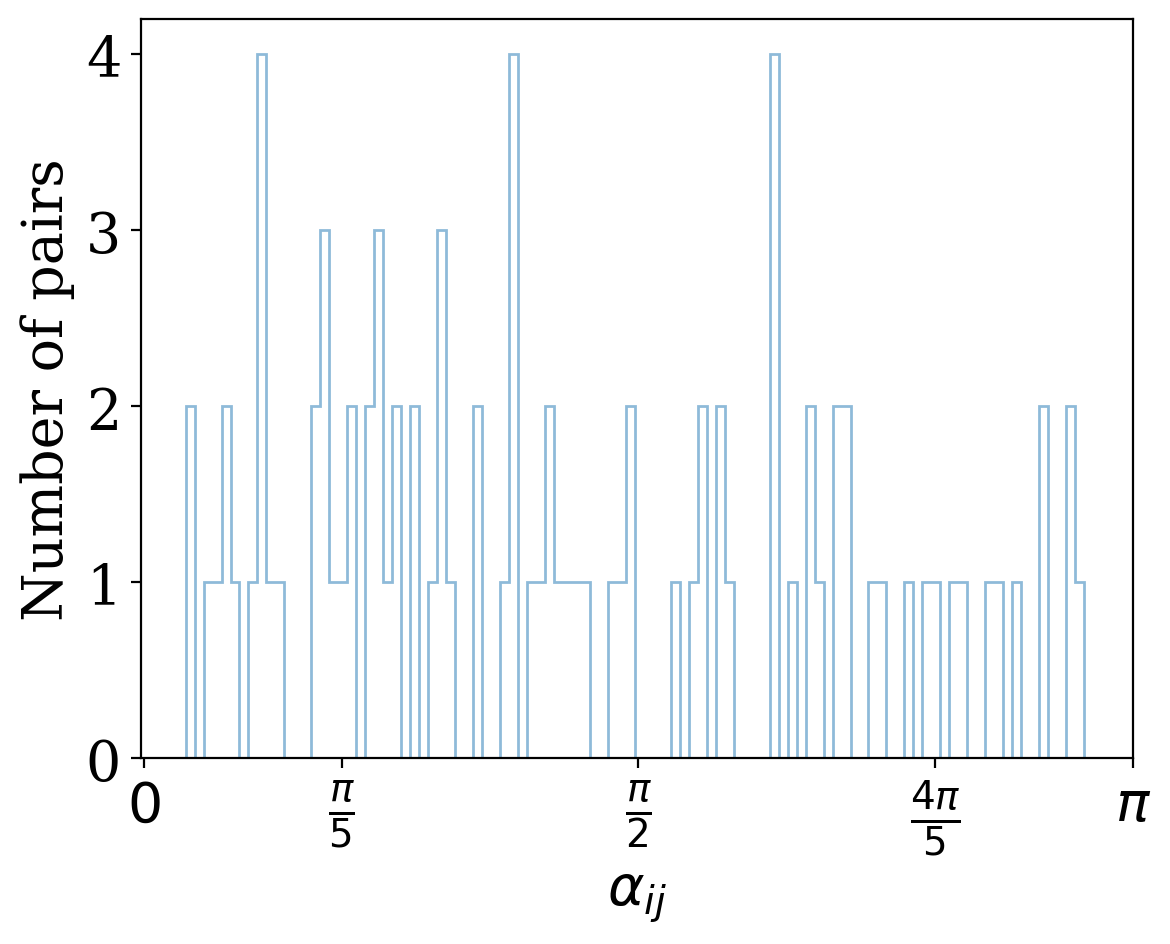

In [699]:
# angular separation between pulsars in radians in a histogram

from matplotlib.ticker import MultipleLocator, FuncFormatter

def custom_pi_formatter(x, pos):
    if x == 0:
        return '0'
    elif x == np.pi / 5:
        return r'$\frac{\pi}{5}$'
    elif x == np.pi / 2:
        return r'$\frac{\pi}{2}$'
    elif x == 4 * np.pi / 5:
        return r'$\frac{4\pi}{5}$'
    elif x == np.pi:
        return r'$\pi$'
    else:
        return ''


# Definire i tick personalizzati
custom_ticks = [0, np.pi / 5, np.pi / 2, 4 * np.pi / 5, np.pi]


plt.hist(alpha_ij, bins=100, histtype='step', alpha=0.5)
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel('Number of pairs')

#plt.title('Angular separation between pulsars')
plt.xticks(custom_ticks, [r'$0$', r'$\frac{\pi}{5}$', r'$\frac{\pi}{2}$', r'$\frac{4\pi}{5}$', r'$\pi$'])
plt.show()

In [709]:
# hellings  downs curve

def hellings_downs(alpha):
    return 0.5 + (3*(1- np.cos(alpha))/4 * (np.log(0.5*(1-np.cos(alpha)))- 1/6))

def hellings_downs_breathing(alpha):
    return (3 + np.cos(alpha)) / 8

alpha = np.linspace(0.01, np.pi, 100)
hd = hellings_downs(alpha)
hd_breathing = hellings_downs_breathing(alpha)

In [710]:
# find the index corresponding to a frequency of 1e-8

f = np.logspace(-9, -7, 100)
f_index = np.argmin(np.abs(f - 1e-8))
gamma_ij_t_10_8 = gamma_ij_t[:,f_index]
gamma_ij_v_10_8 = gamma_ij_v[:,f_index]
gamma_ij_s_10_8 = gamma_ij_s[:,f_index]
gamma_ij_l_10_8 = gamma_ij_l[:,f_index]
gamma_ij_V_10_8 = gamma_ij_V[:,f_index]


In [702]:
alpha = np.linspace(0.01, np.pi, 100)
print(alpha.shape)
print(hd.shape)

(100,)
(100,)


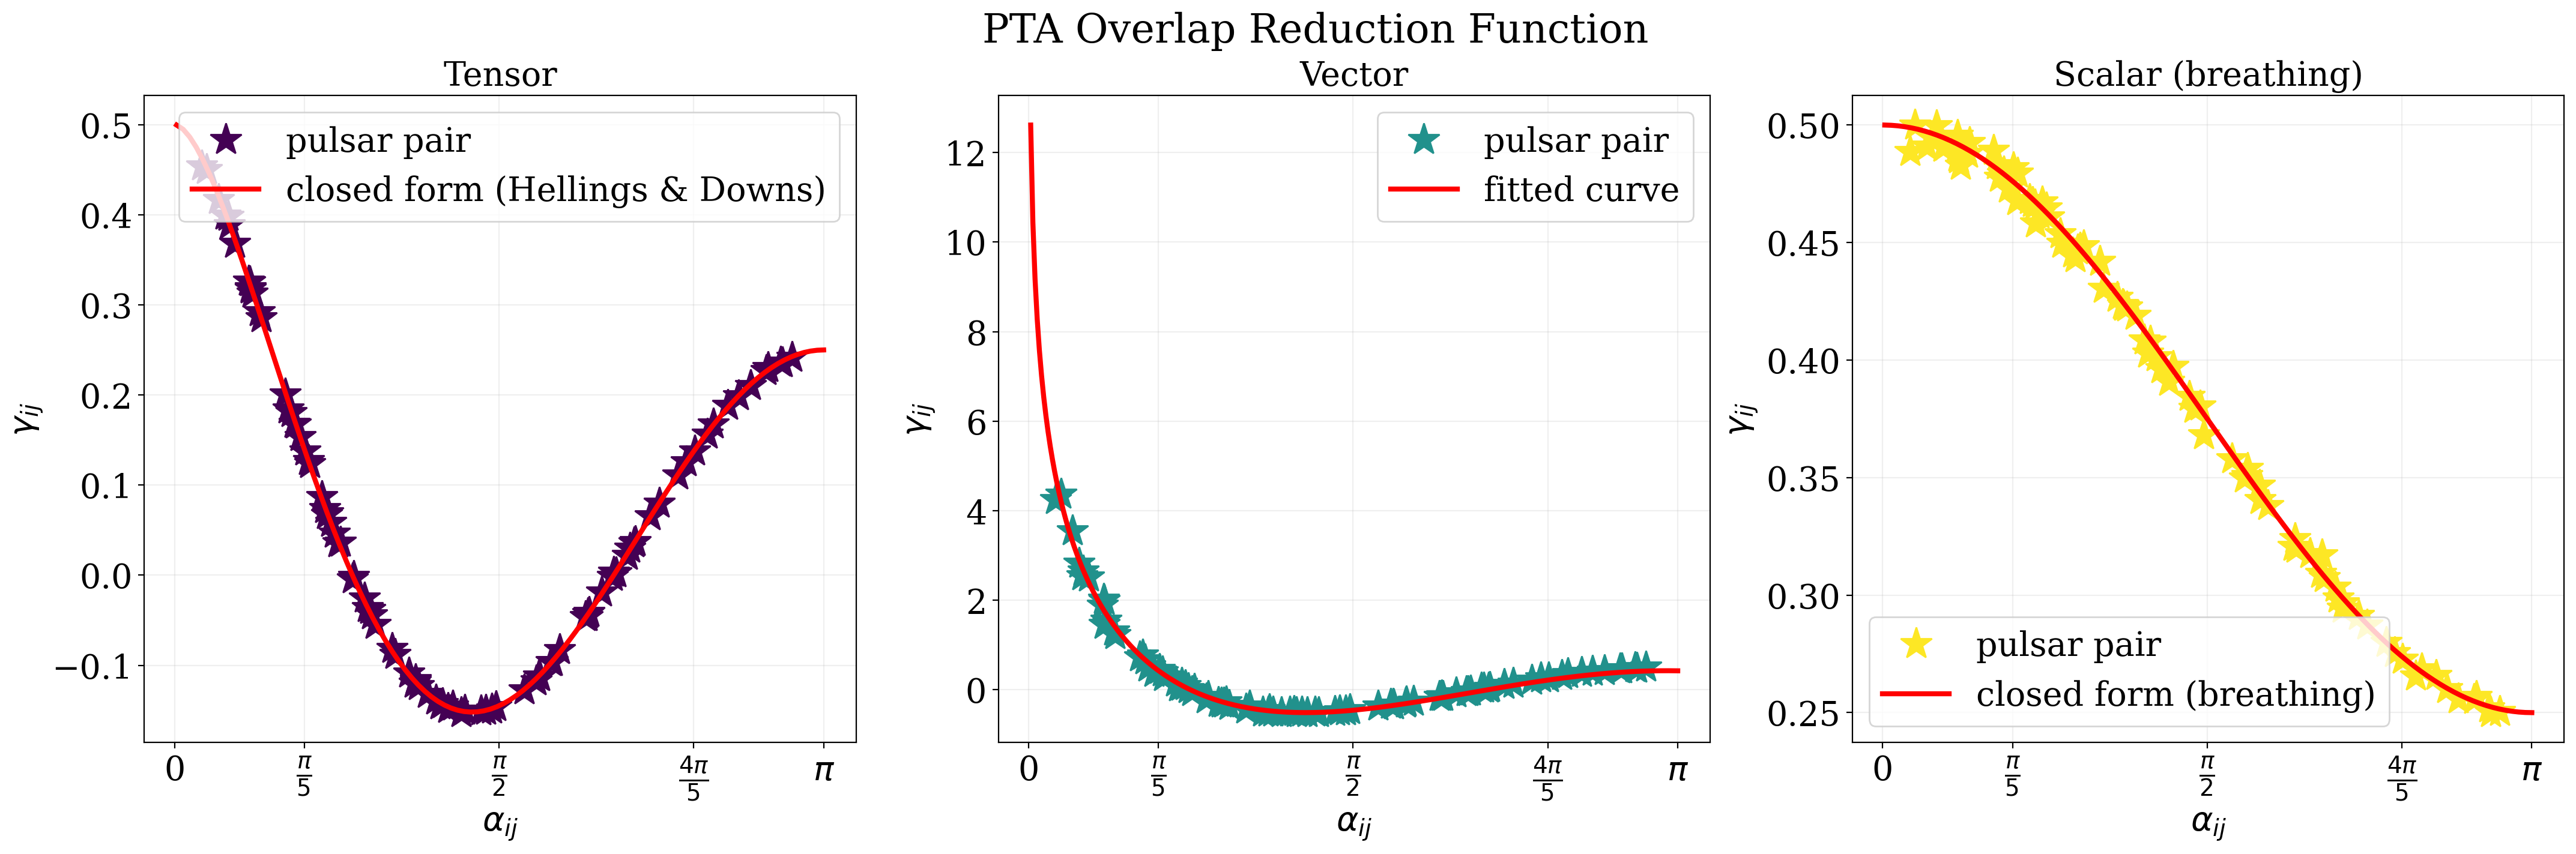

In [711]:
colors = cm.viridis(np.linspace(0, 1, 3))

def model_exp_cos(alpha, A, B, C, D, E):
    return A * np.log(B * alpha) + C * np.cos(D * alpha + E )

alpha_fit = np.linspace(0, np.pi, 300)
gamma_fit_easy = model_exp_cos(alpha_fit, -np.pi, 0.674, -3, 0.813, 2/10)


fig, ax = plt.subplots(1, 3, figsize=(26, 7))

# Tensors
ax[0].plot(alpha_ij, gamma_ij_t_10_8, '*', color=colors[0], label='pulsar pair', ms=20)    
ax[0].plot(alpha, hd, '-', color='red', label='closed form (Hellings & Downs)')
ax[0].set_xlabel(r'$\alpha_{ij}$')
ax[0].set_ylabel(r'$\gamma_{ij}$')
ax[0].grid(which='both', alpha=0.2)
ax[0].set_title('Tensor')
ax[0].set_xticks(custom_ticks)
ax[0].legend()
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

# Vectors
ax[1].plot(alpha_ij, gamma_ij_v_10_8, '*', color=colors[1], label='pulsar pair', ms=20)
ax[1].plot(alpha_fit, gamma_fit_easy, '-', color='red', label='fitted curve')
ax[1].set_xlabel(r'$\alpha_{ij}$')
ax[1].set_ylabel(r'$\gamma_{ij}$')
ax[1].grid(which='both', alpha=0.2)
ax[1].set_title('Vector')
ax[1].set_xticks(custom_ticks)
ax[1].legend()
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

# Scalars
ax[2].plot(alpha_ij, gamma_ij_s_10_8, '*', color=colors[2], label='pulsar pair', ms=20)
ax[2].plot(alpha, hd_breathing, '-', color='red', label='closed form (breathing)')
ax[2].set_xlabel(r'$\alpha_{ij}$')
ax[2].set_ylabel(r'$\gamma_{ij}$')
ax[2].grid(which='both', alpha=0.2)
ax[2].legend()
ax[2].set_title('Scalar (breathing)')
ax[2].set_xticks(custom_ticks)
ax[2].xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))


fig.suptitle('PTA Overlap Reduction Function')

plt.show()

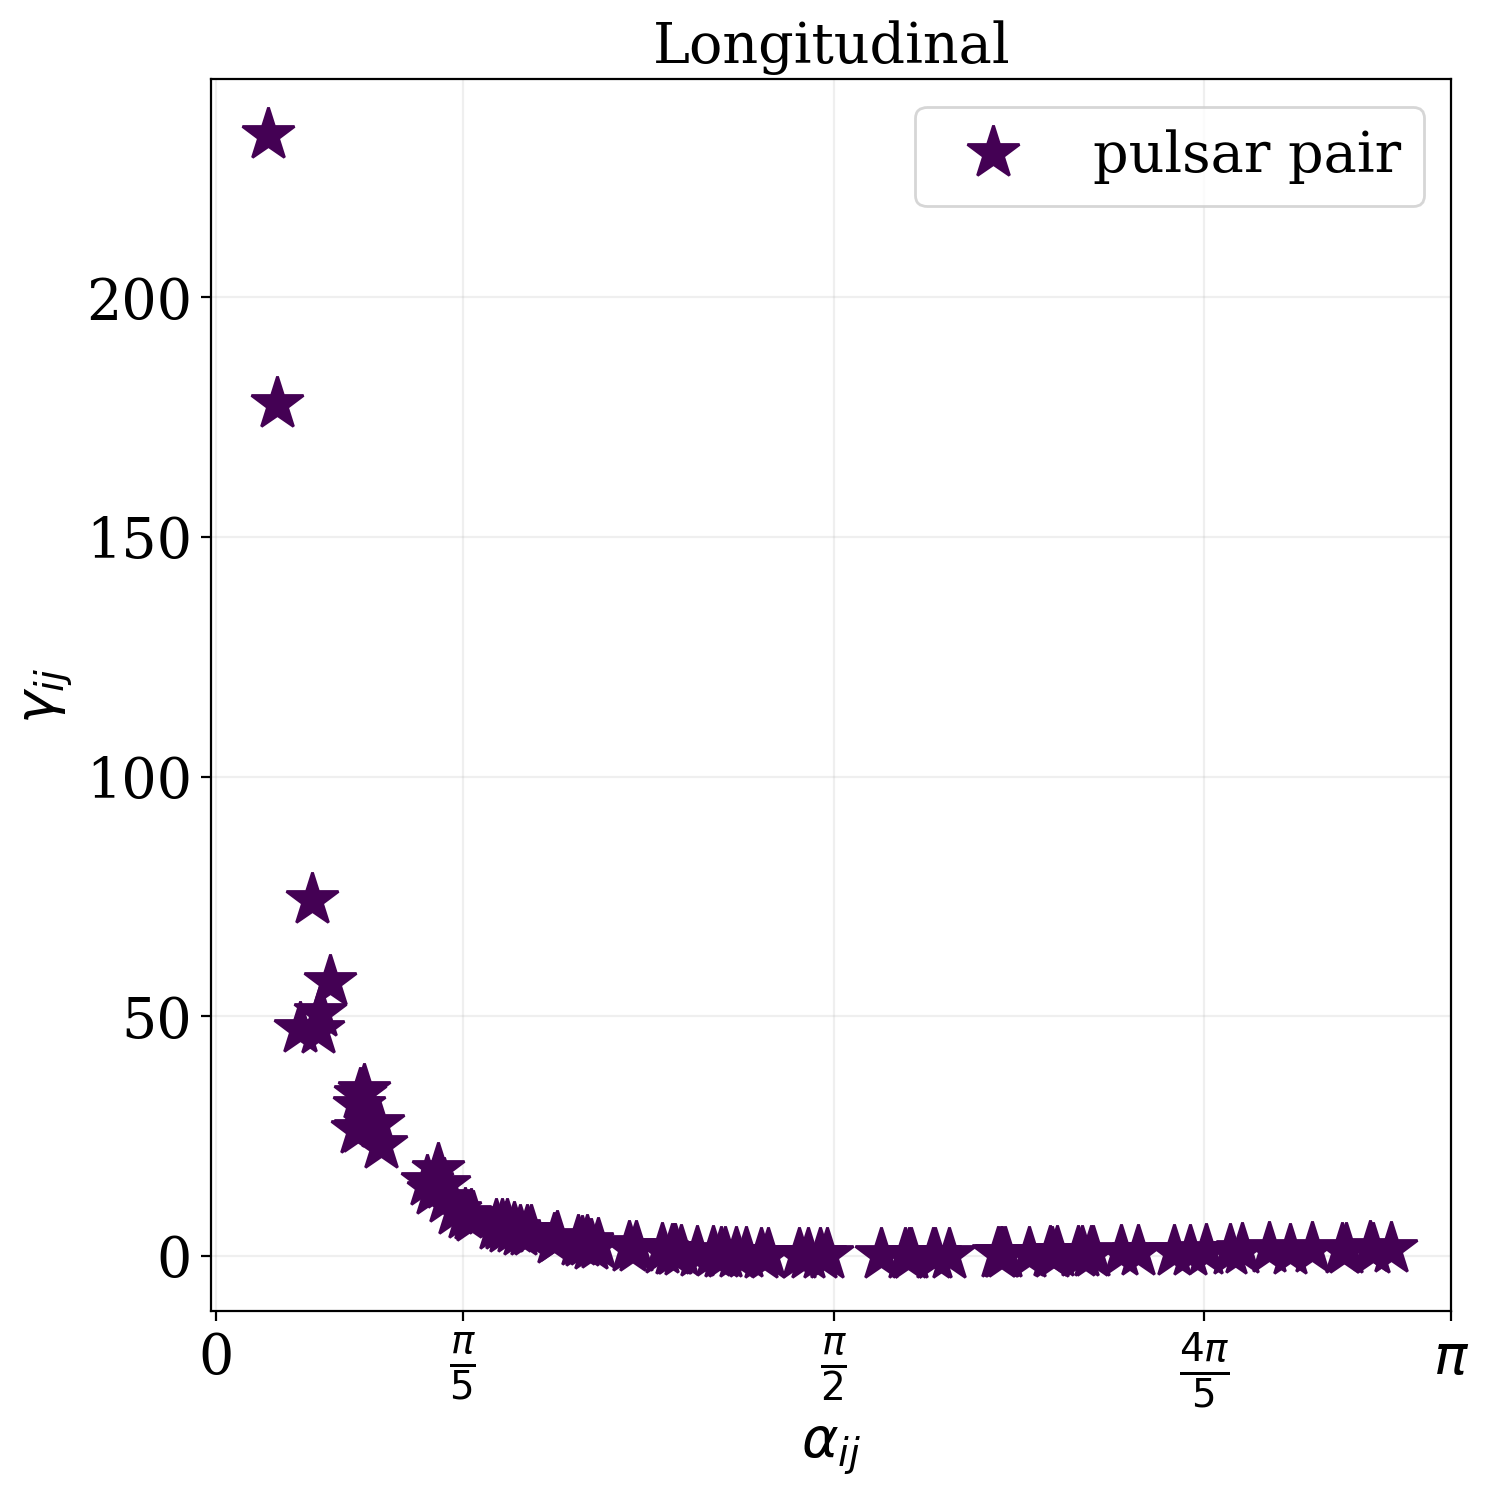

In [712]:
# plot longitudinal

plt.figure(figsize=(8, 8))

plt.plot(alpha_ij, gamma_ij_l_10_8, '*', color=colors[0], label='pulsar pair', ms=20)
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.grid(which='both', alpha=0.2)
plt.title('Longitudinal')
plt.xticks(custom_ticks)
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

In [713]:
print(gamma_ij_V[:,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


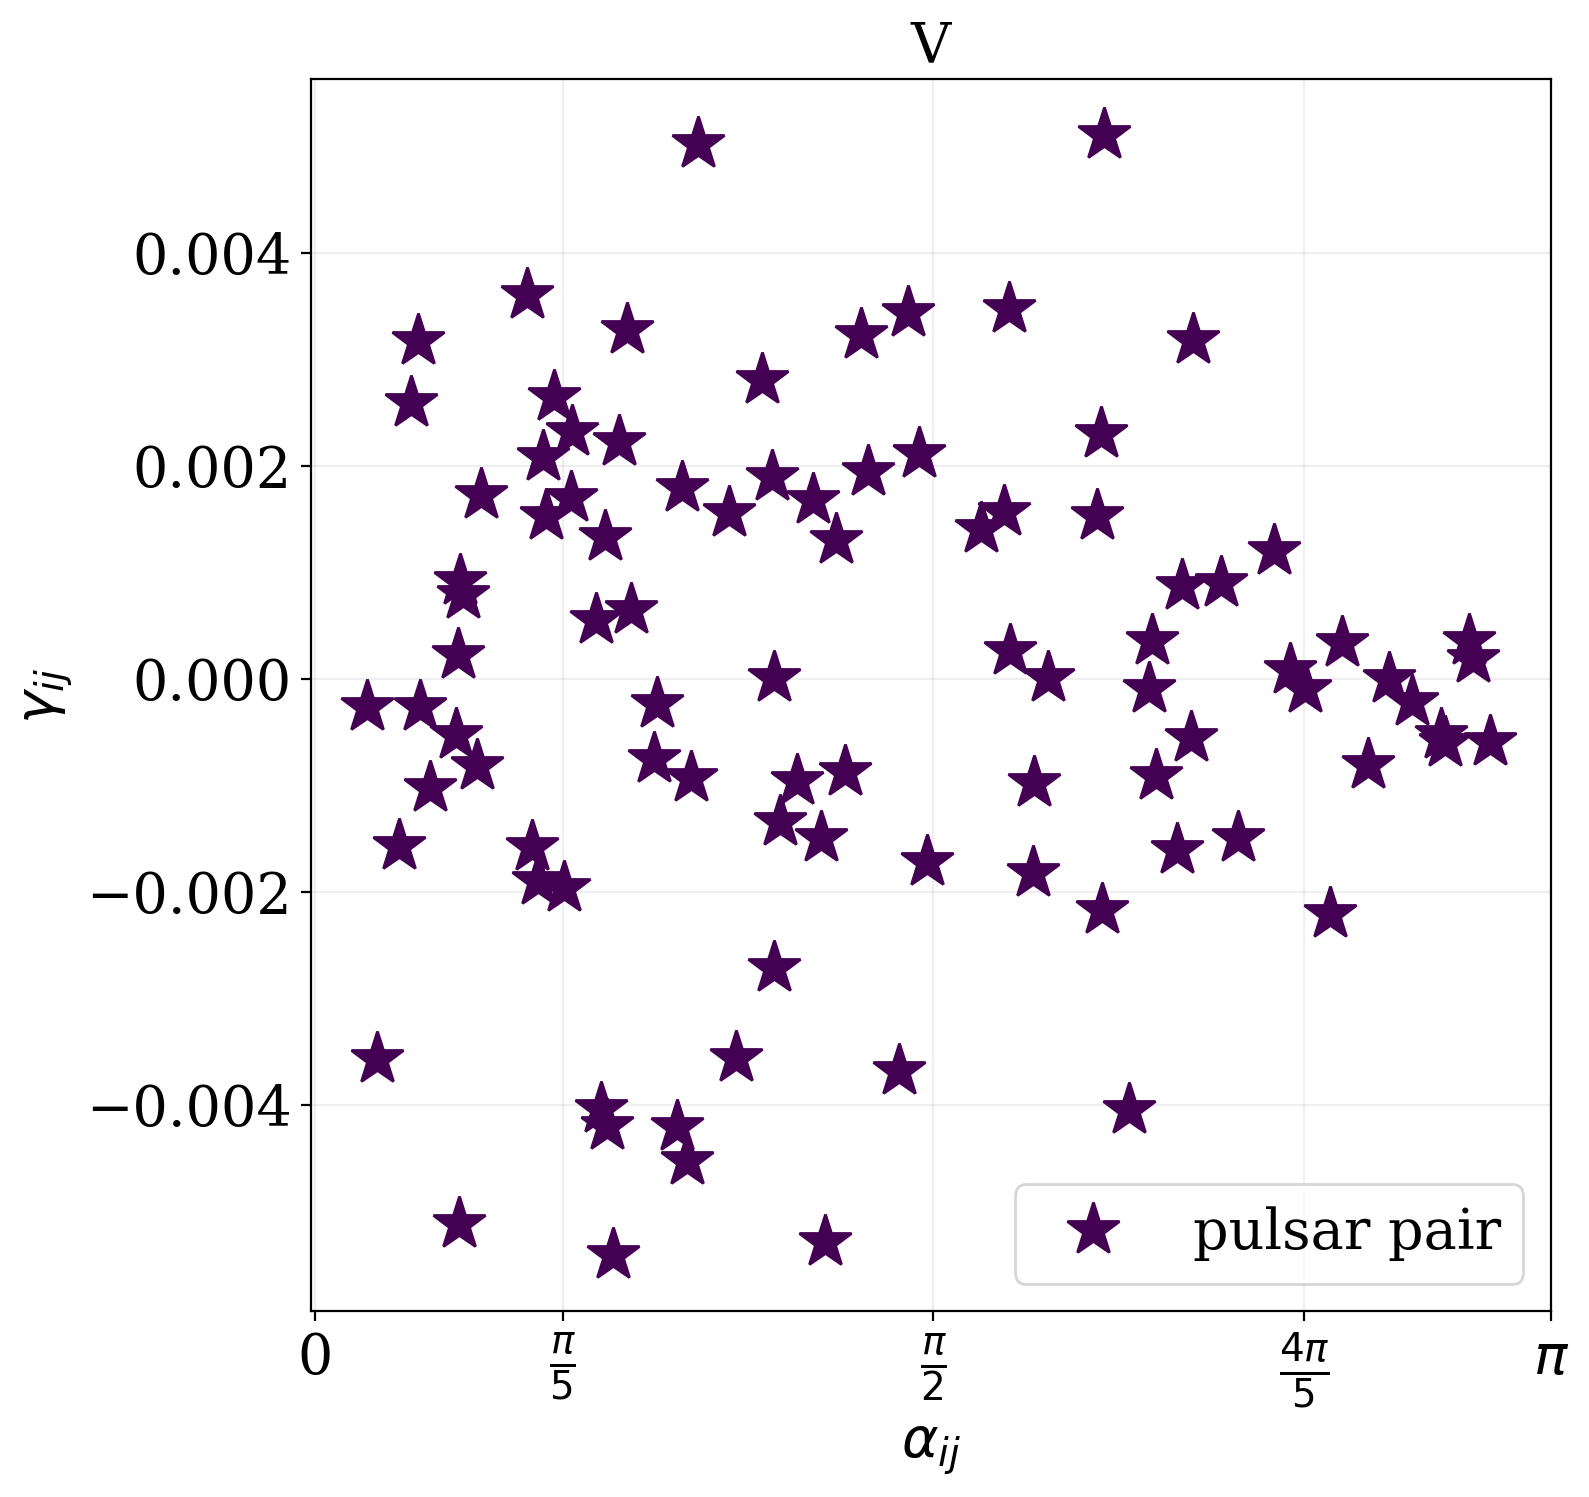

In [680]:
# plot circular

plt.figure(figsize=(8, 8))

plt.plot(alpha_ij, gamma_ij_V[:,0], '*', color=colors[0], label='pulsar pair', ms=20)
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.grid(which='both', alpha=0.2)
plt.title('V')
plt.xticks(custom_ticks)
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

$\gamma_{ij}^{\ell}$ as a function of the angular separation between pulsars for tensor, vector and scalar (breathing) polarization modes

In [714]:
gamma1_ij_t = []
gamma1_ij_v = []
gamma1_ij_s = []
gamma1_ij_l = []
gamma1_ij_V = []
alpha_ij = []
ell=1
psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(p[i], p[j])))
        gamma1_ij_t.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 't', psi))
        gamma1_ij_v.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 'v', psi))
        gamma1_ij_s.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 's', psi))
        gamma1_ij_l.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 'l', psi))
        gamma1_ij_V.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 'V', psi))

gamma1_ij_t = np.array(gamma1_ij_t)
gamma1_ij_v = np.array(gamma1_ij_v)
gamma1_ij_s = np.array(gamma1_ij_s)
gamma1_ij_l = np.array(gamma1_ij_l)
gamma1_ij_V = np.array(gamma1_ij_V) 
alpha_ij = np.array(alpha_ij)

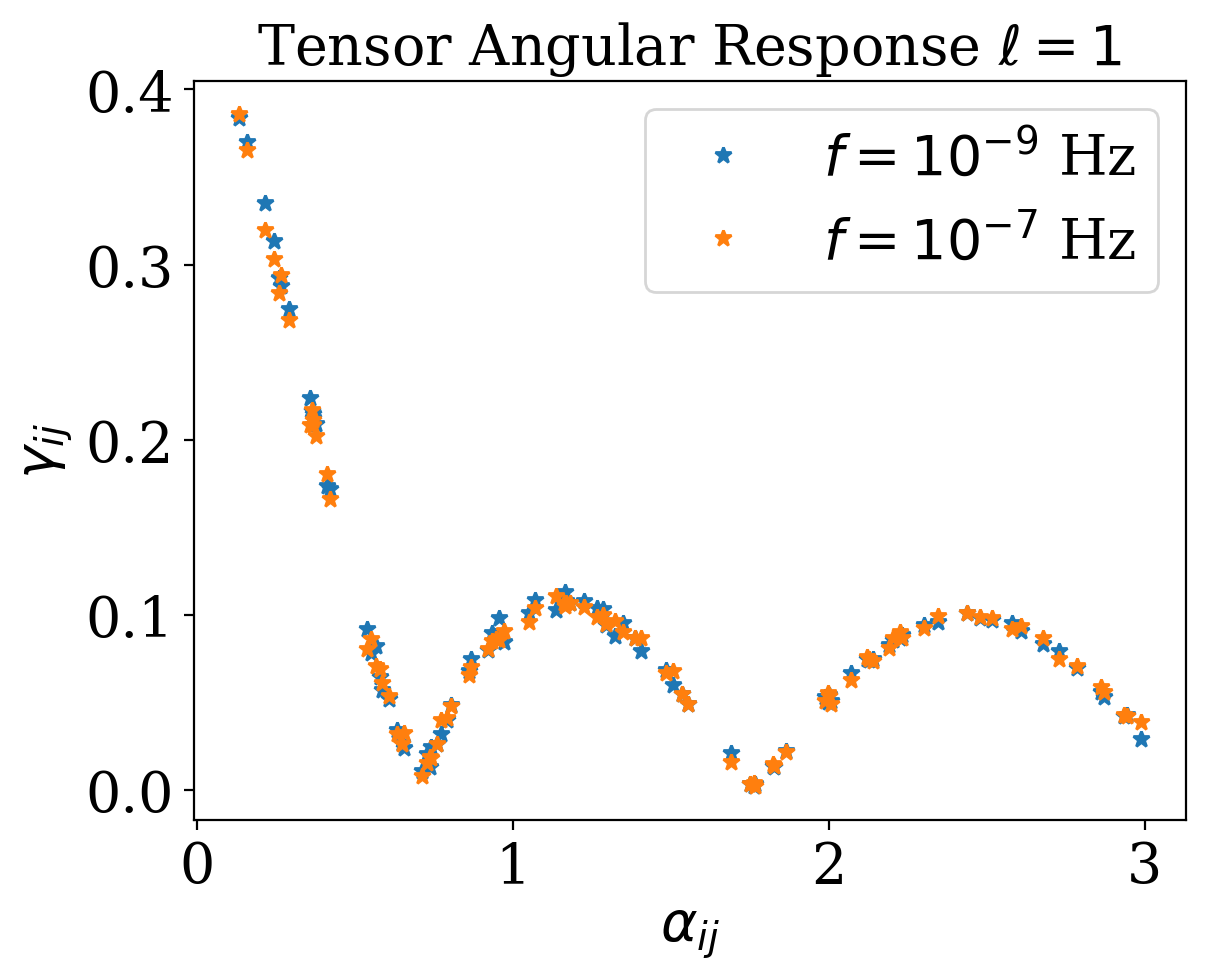

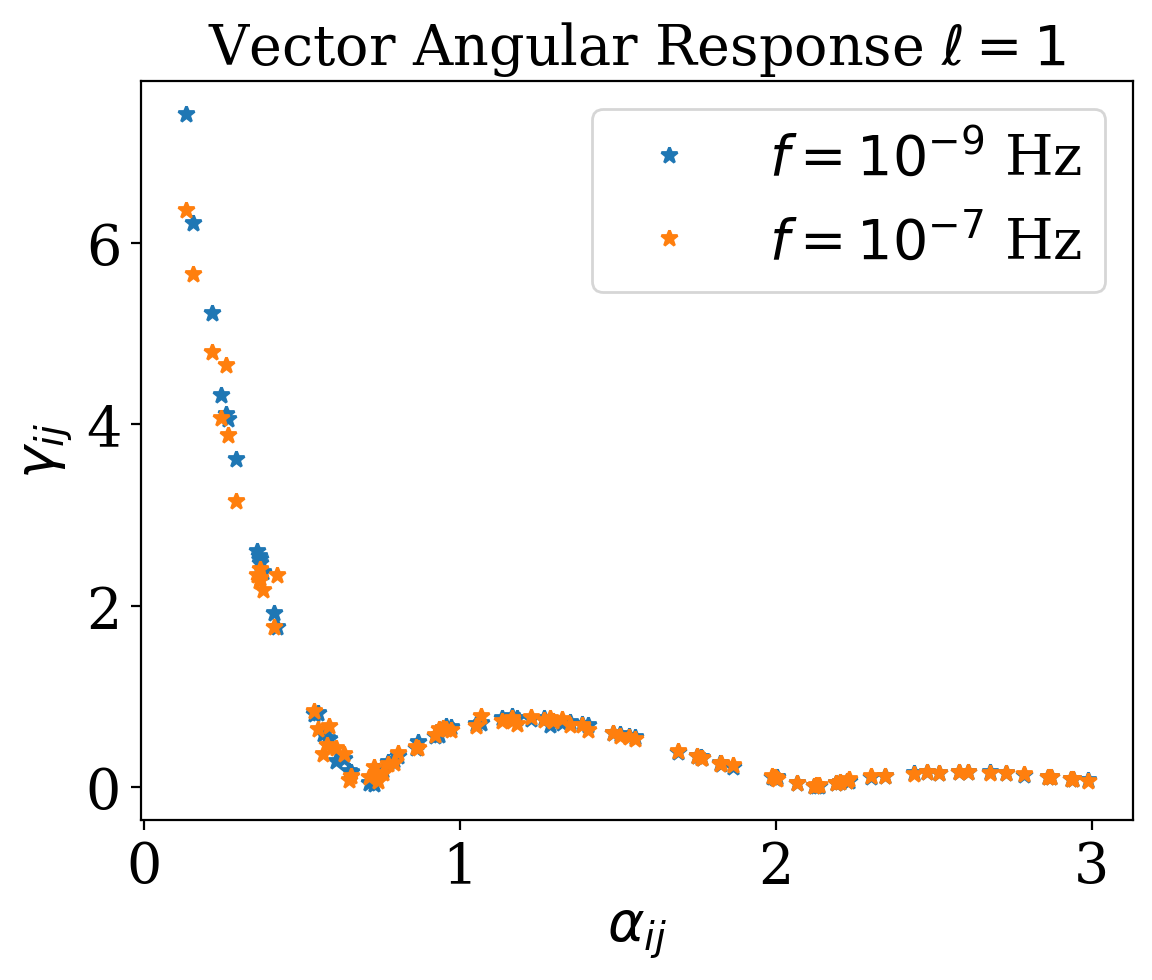

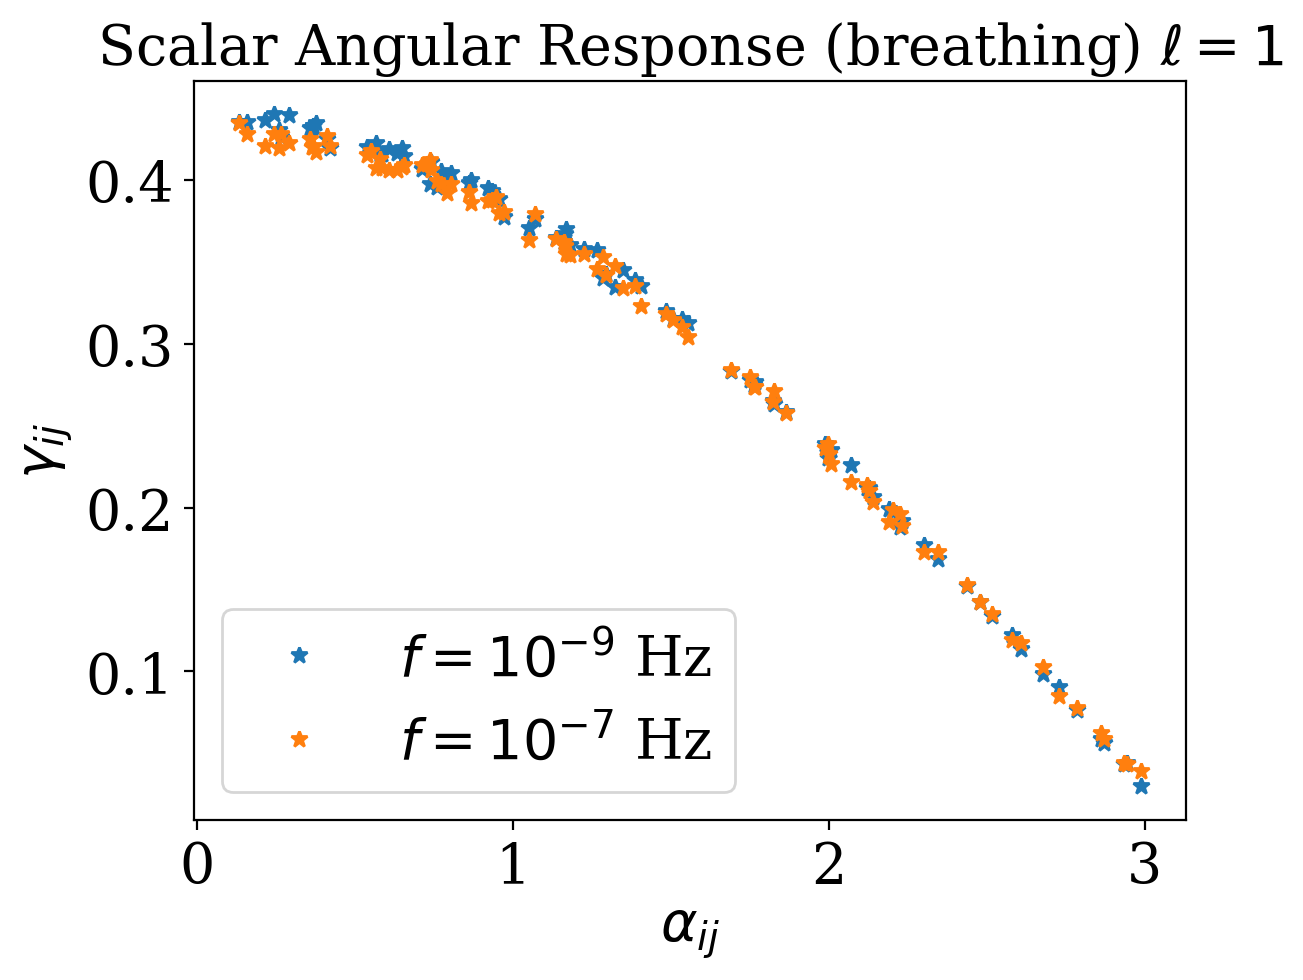

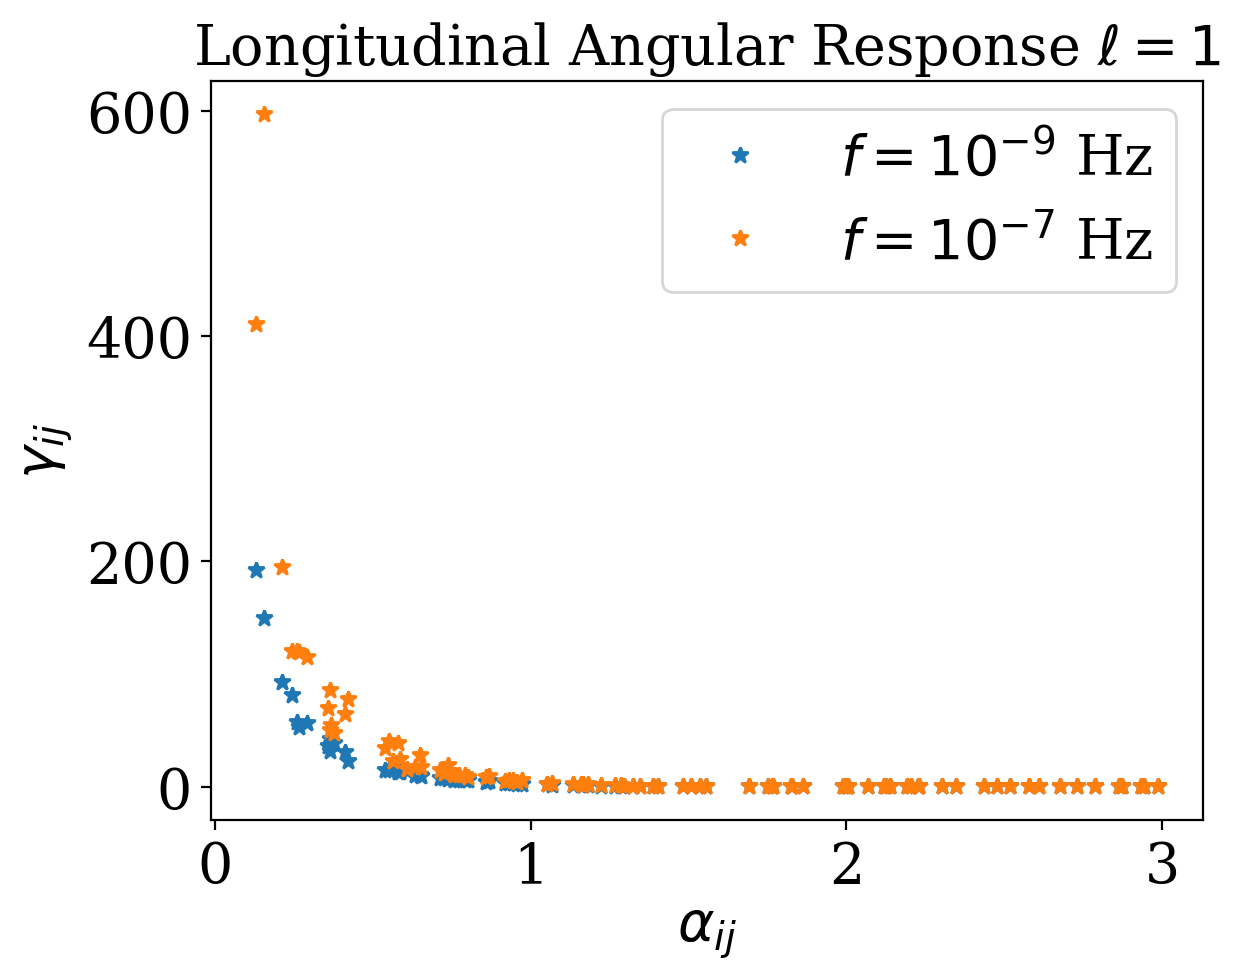

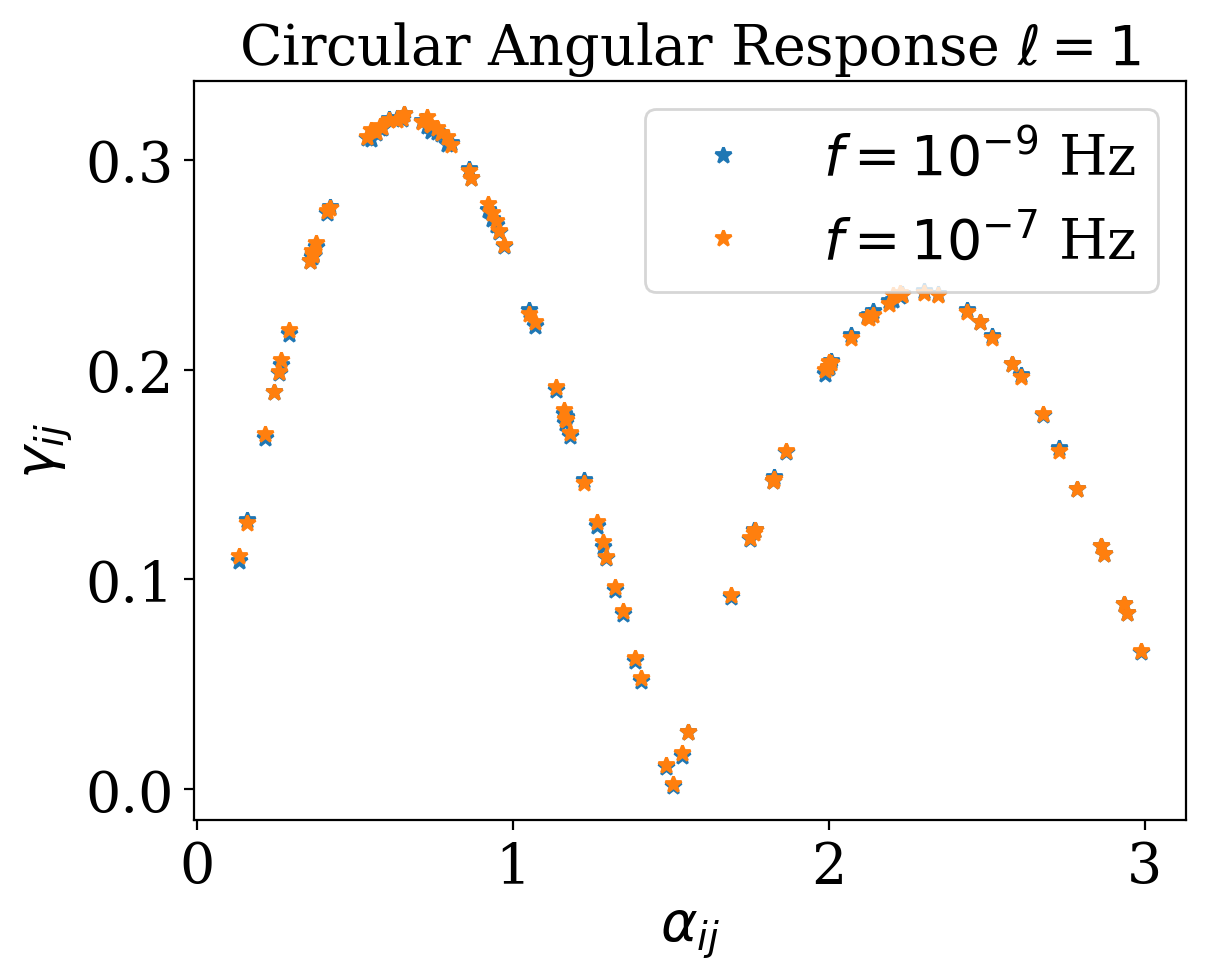

In [715]:
plt.plot(alpha_ij, gamma1_ij_t[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma1_ij_t[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Tensor Angular Response $\ell=1$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma1_ij_v[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma1_ij_v[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Vector Angular Response $\ell=1$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma1_ij_s[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma1_ij_s[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Scalar Angular Response (breathing) $\ell=1$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma1_ij_l[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma1_ij_l[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Longitudinal Angular Response $\ell=1$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma1_ij_V[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma1_ij_V[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Circular Angular Response $\ell=1$')
plt.legend()
plt.show()

In [719]:
gamma2_ij_t = []
gamma2_ij_v = []
gamma2_ij_s = []
gamma2_ij_l = []
gamma2_ij_V = []
alpha_ij = []
ell=2
psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(p[i], p[j])))
        gamma2_ij_t.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 't', psi))
        gamma2_ij_v.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 'v', psi))
        gamma2_ij_s.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 's', psi))
        gamma2_ij_l.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 'l', psi))
        gamma2_ij_V.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 'V', psi))

gamma2_ij_t = np.array(gamma2_ij_t)
gamma2_ij_v = np.array(gamma2_ij_v)
gamma2_ij_s = np.array(gamma2_ij_s)
gamma2_ij_l = np.array(gamma2_ij_l)
gamma2_ij_V = np.array(gamma2_ij_V)
alpha_ij = np.array(alpha_ij)

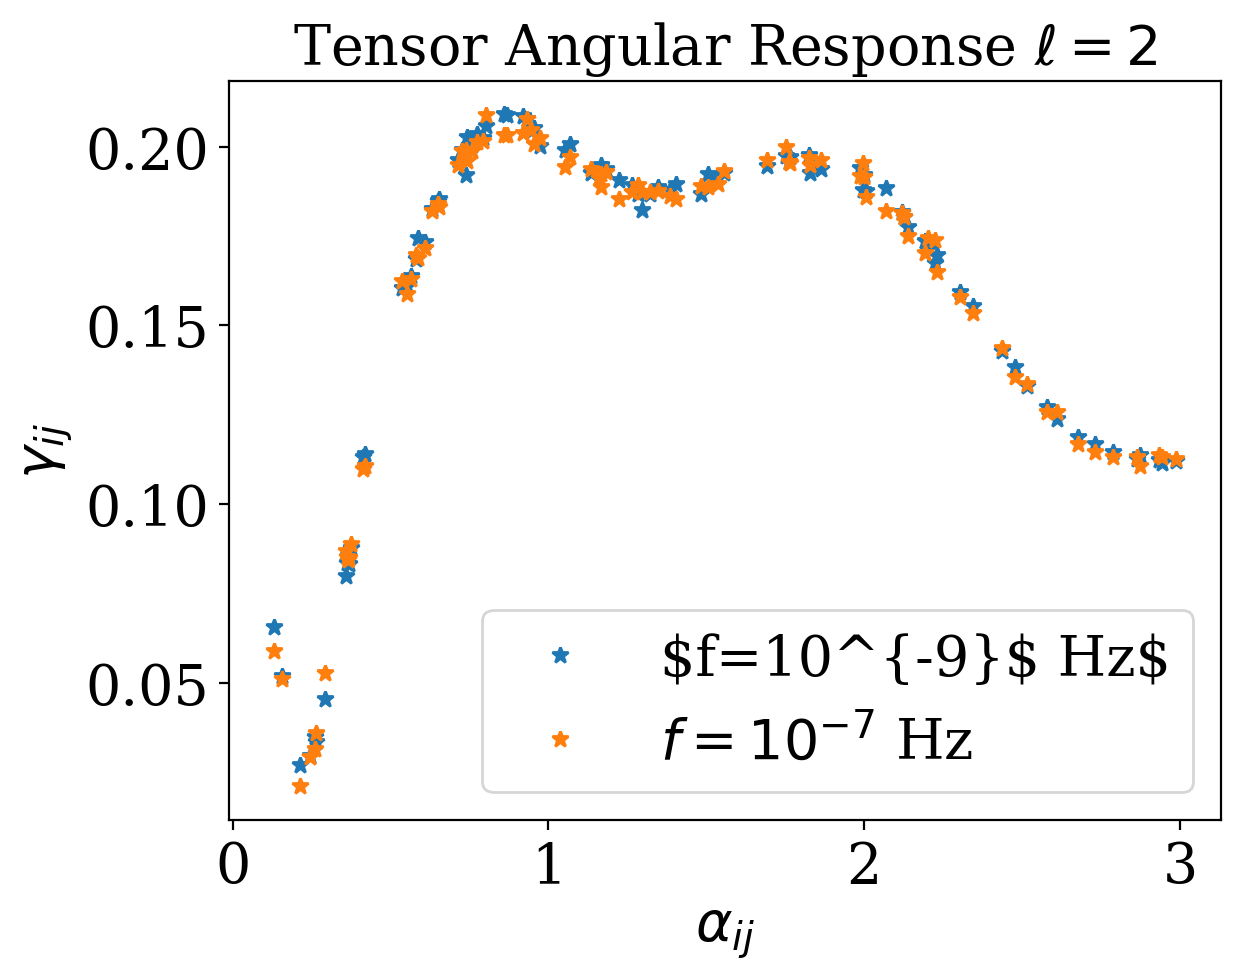

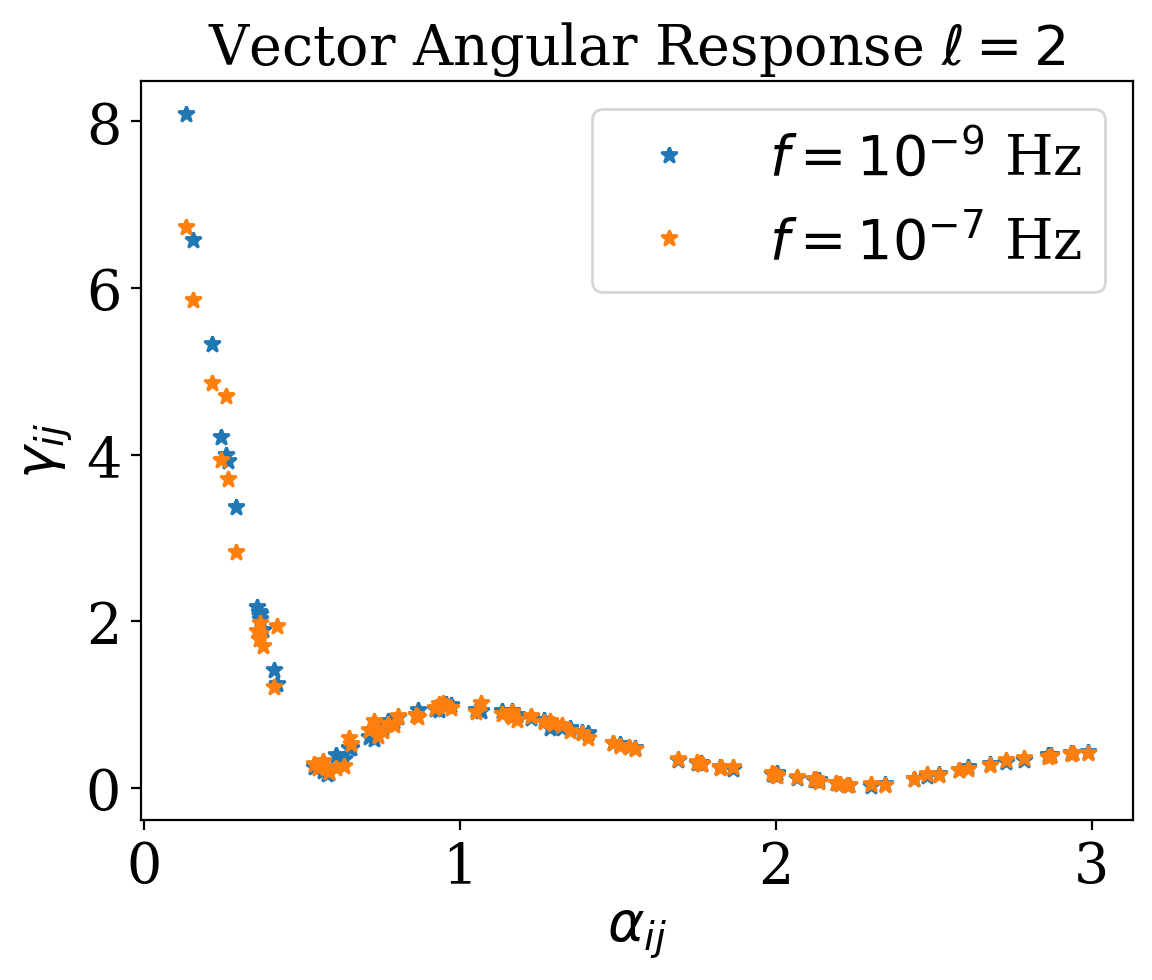

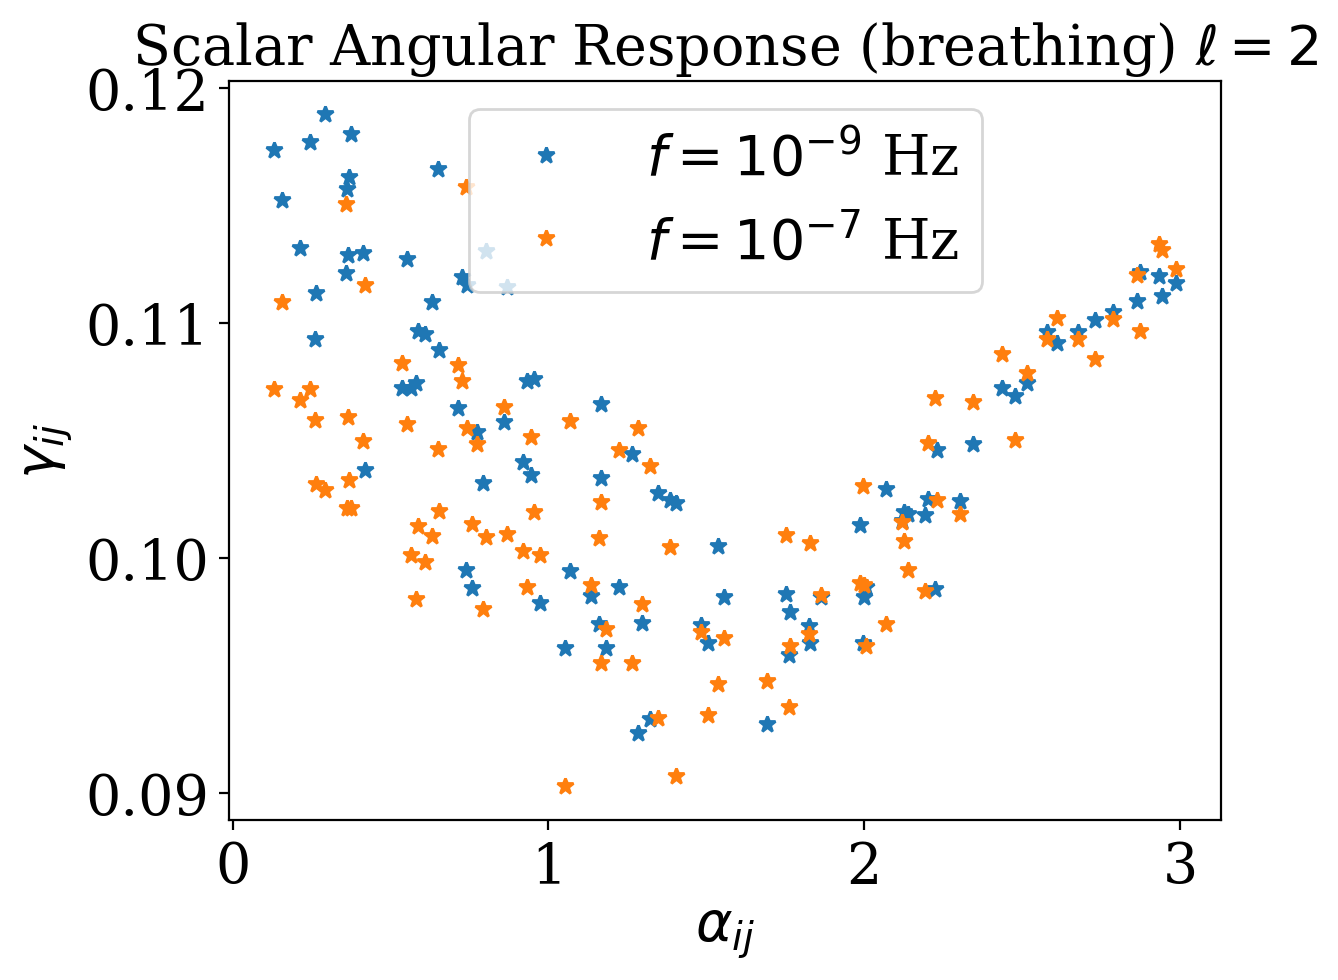

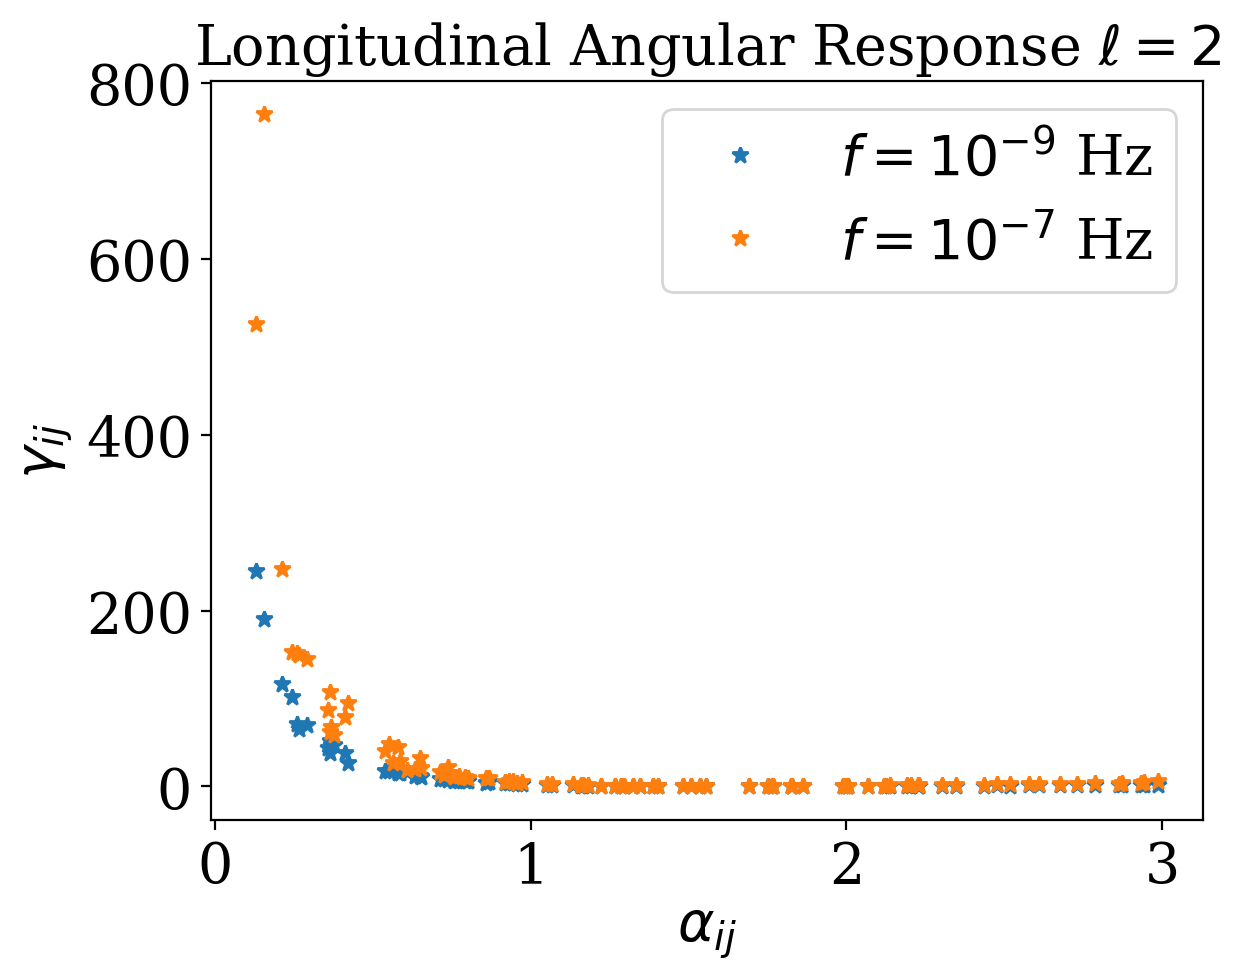

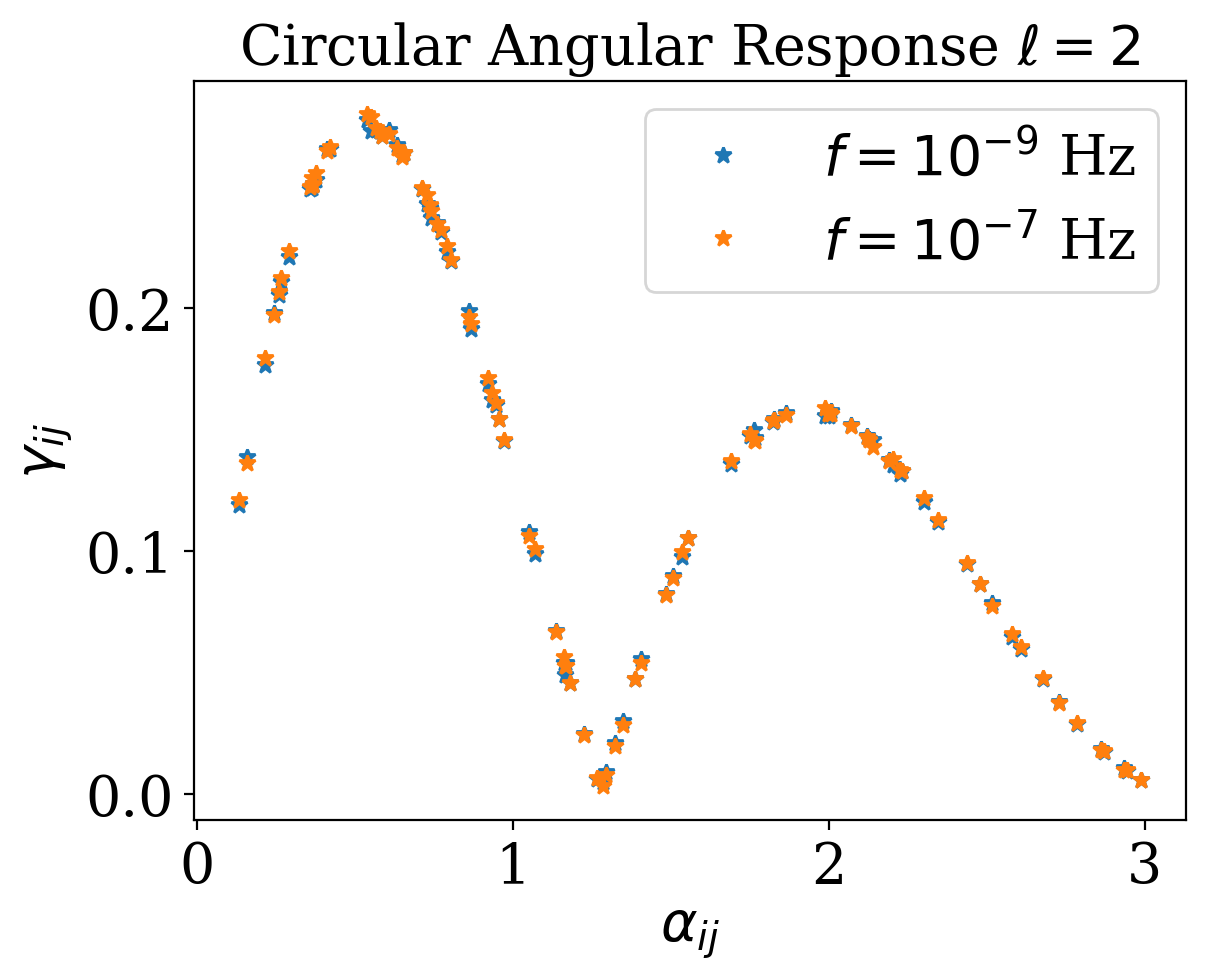

In [720]:
plt.plot(alpha_ij, gamma2_ij_t[:,0], '*', label='$f=10^{-9}$ Hz$')
plt.plot(alpha_ij, gamma2_ij_t[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Tensor Angular Response $\ell=2$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma2_ij_v[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma2_ij_v[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Vector Angular Response $\ell=2$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma2_ij_s[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma2_ij_s[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Scalar Angular Response (breathing) $\ell=2$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma2_ij_l[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma2_ij_l[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Longitudinal Angular Response $\ell=2$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma2_ij_V[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma2_ij_V[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Circular Angular Response $\ell=2$')
plt.legend()
plt.show()

In [721]:
gamma3_ij_t = []
gamma3_ij_v = []
gamma3_ij_s = []
gamma3_ij_l = []
gamma3_ij_V = []
alpha_ij = []
ell=3
psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(p[i], p[j])))
        gamma3_ij_t.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 't', psi))
        gamma3_ij_v.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 'v', psi))
        gamma3_ij_s.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 's', psi))
        gamma3_ij_l.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 'l', psi))
        gamma3_ij_V.append(AngularResponse.R_ell_pairwise(ell, p[i], p[j], D[i], D[j], f, 'V', psi))

gamma3_ij_t = np.array(gamma3_ij_t)
gamma3_ij_v = np.array(gamma3_ij_v)
gamma3_ij_s = np.array(gamma3_ij_s)
gamma3_ij_l = np.array(gamma3_ij_l)
gamma3_ij_V = np.array(gamma3_ij_V)

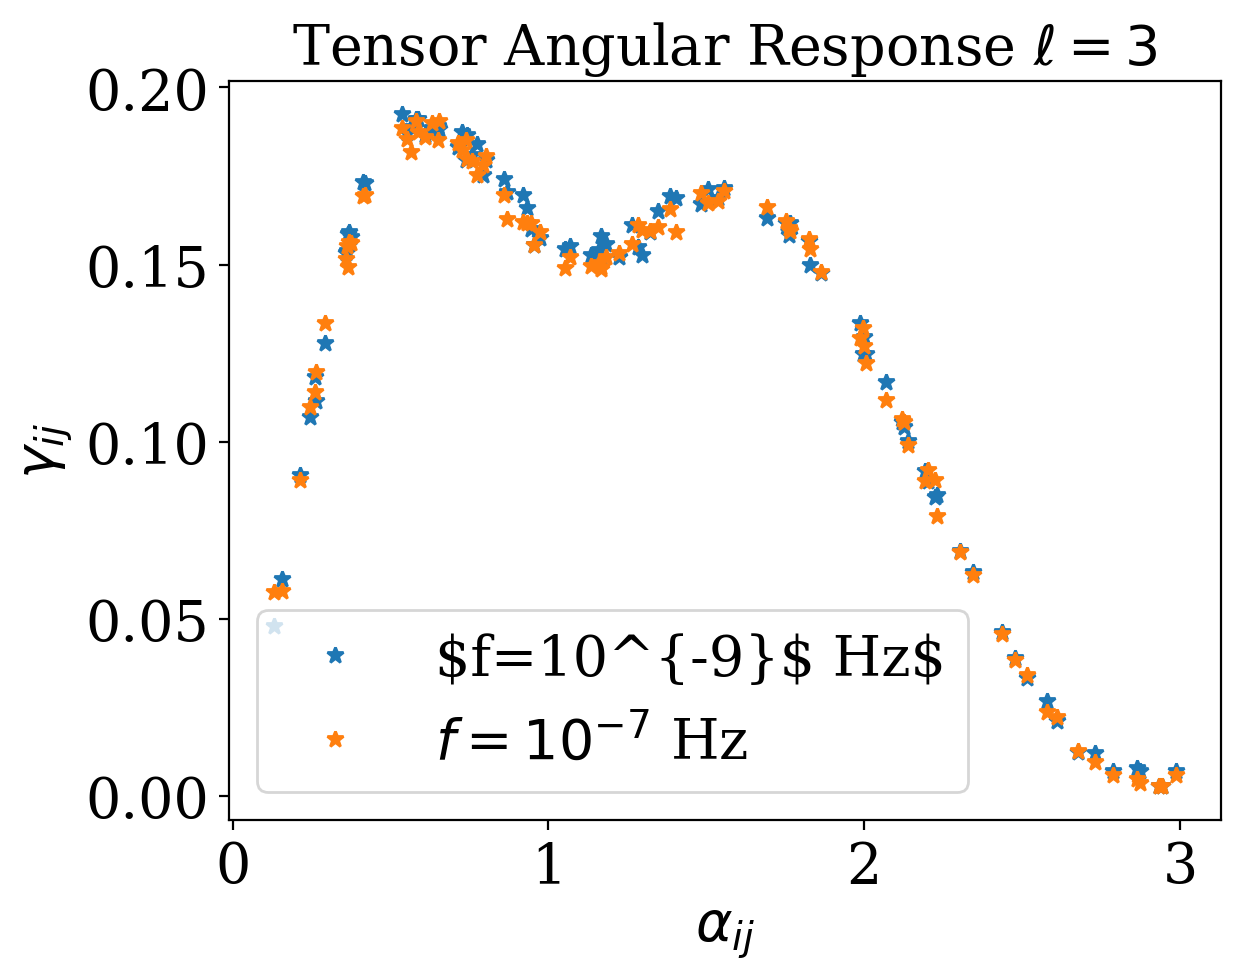

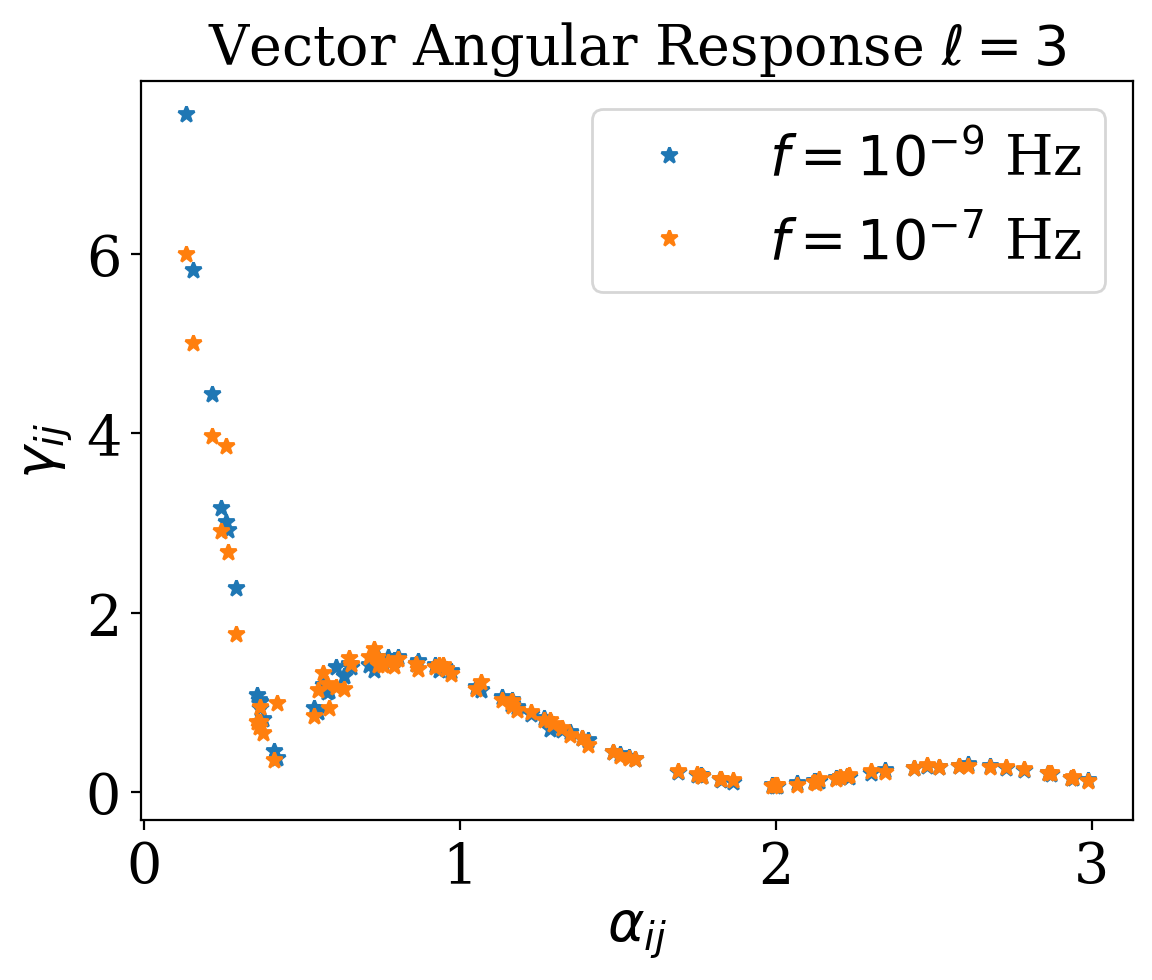

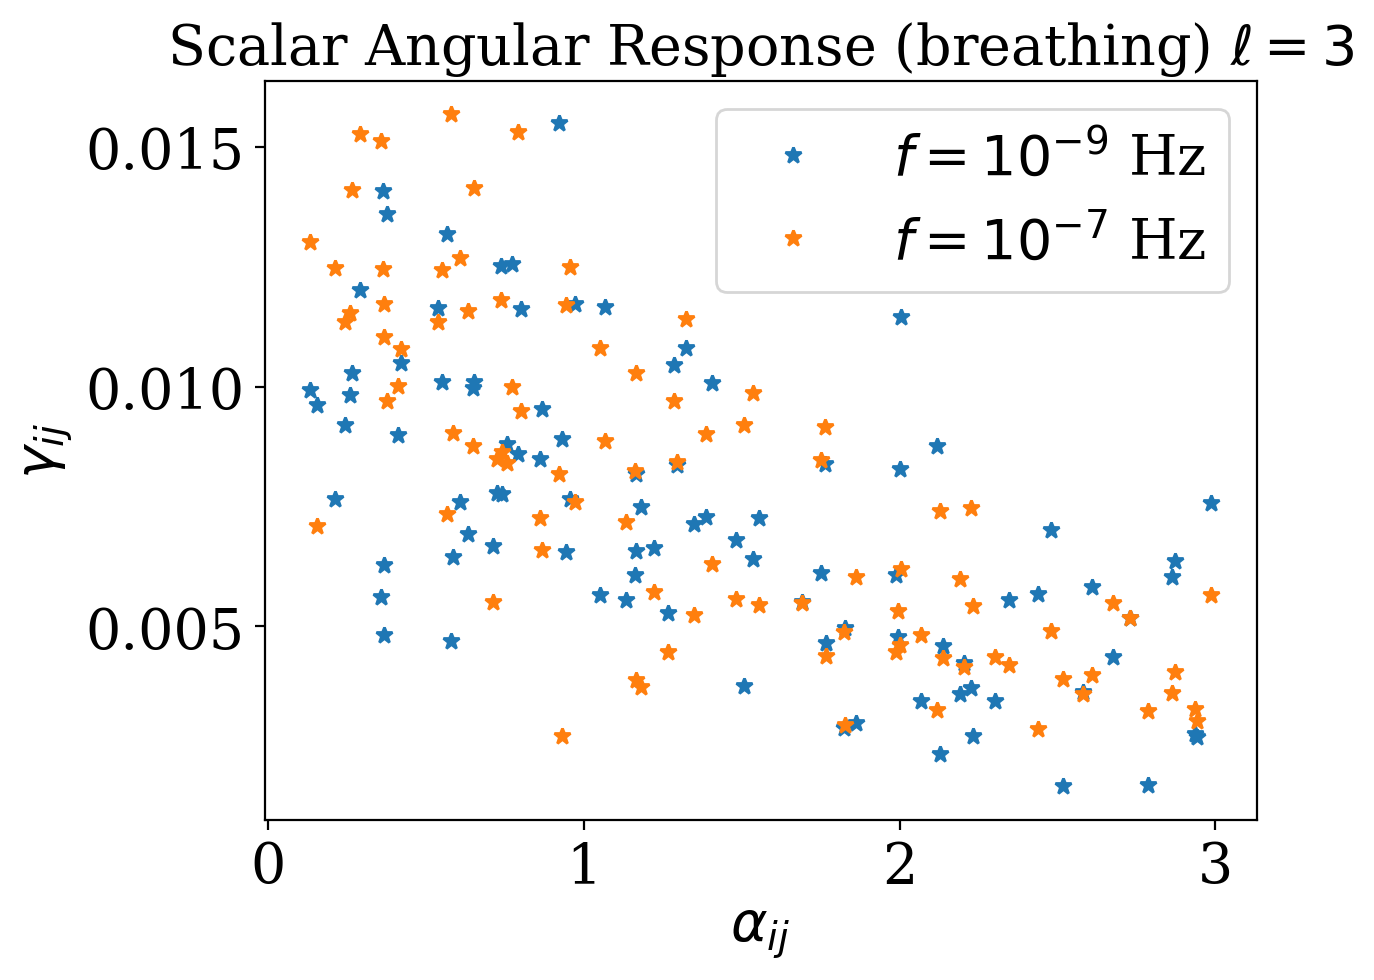

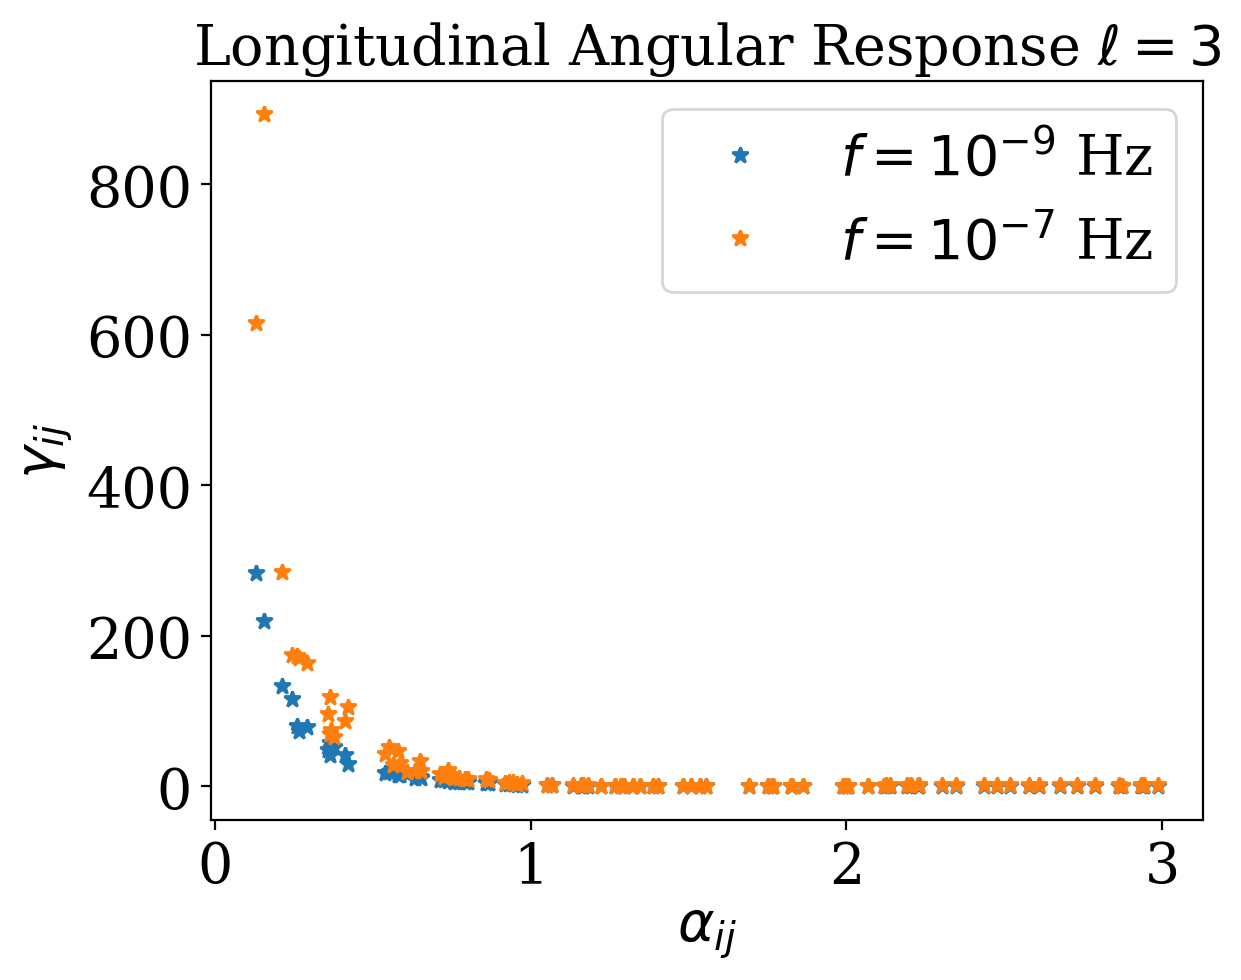

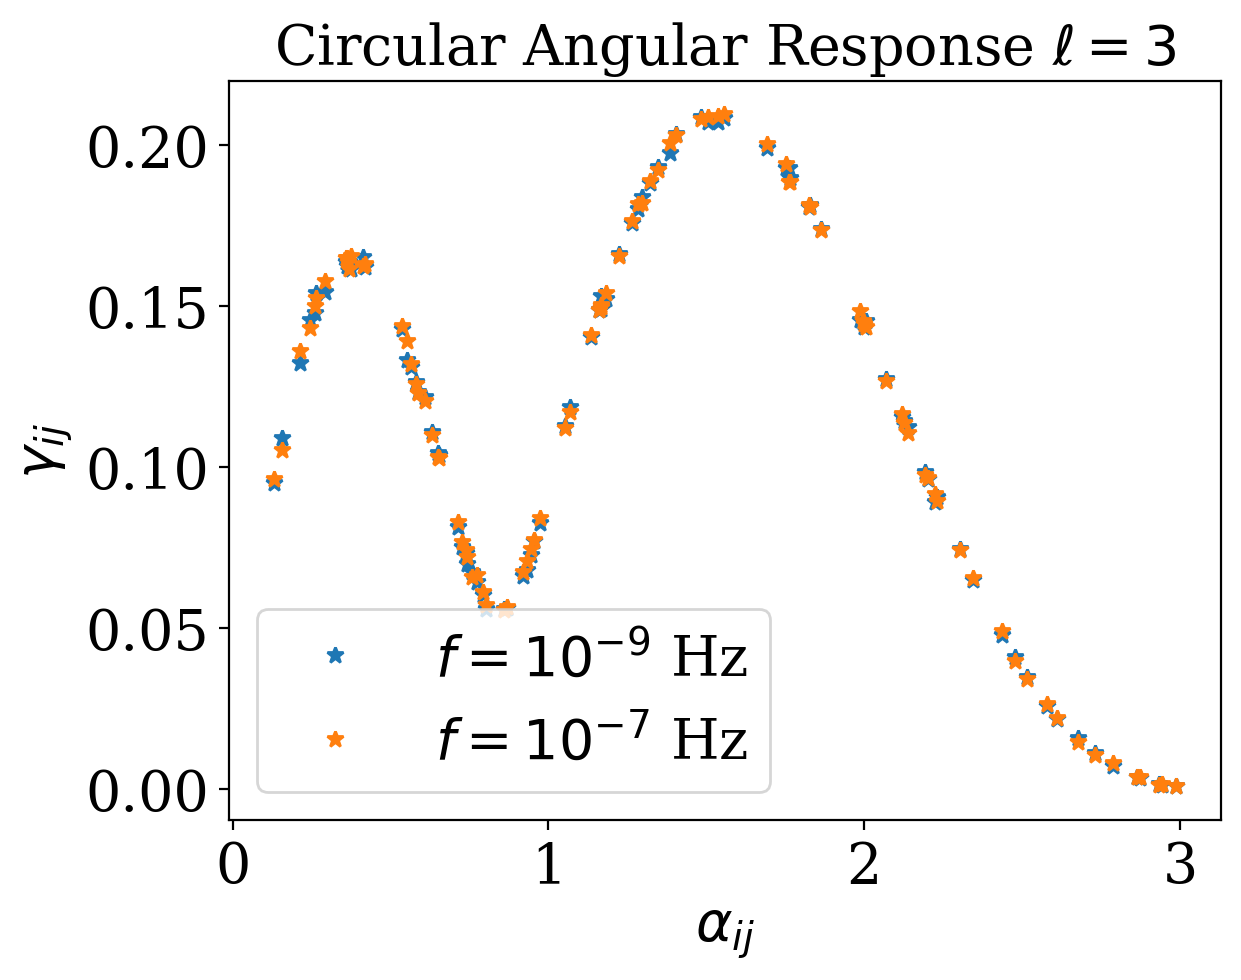

In [722]:
plt.plot(alpha_ij, gamma3_ij_t[:,0], '*', label='$f=10^{-9}$ Hz$')
plt.plot(alpha_ij, gamma3_ij_t[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Tensor Angular Response $\ell=3$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma3_ij_v[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma3_ij_v[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Vector Angular Response $\ell=3$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma3_ij_s[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma3_ij_s[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Scalar Angular Response (breathing) $\ell=3$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma3_ij_l[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma3_ij_l[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Longitudinal Angular Response $\ell=3$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma3_ij_V[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma3_ij_V[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Circular Angular Response $\ell=3$') 
plt.legend()
plt.show()

In [723]:

f_index = np.argmin(np.abs(f - 1e-8))

gamma_ij_t_f_index = gamma_ij_t[:,f_index]
gamma_ij_v_f_index = gamma_ij_v[:,f_index]
gamma_ij_s_f_index = gamma_ij_s[:,f_index]
gamma_ij_l_f_index = gamma_ij_l[:,f_index]
gamma_ij_V_f_index = gamma_ij_V[:,f_index]

gamma1_ij_t_f_index = gamma1_ij_t[:,f_index]
gamma1_ij_v_f_index = gamma1_ij_v[:,f_index]
gamma1_ij_s_f_index = gamma1_ij_s[:,f_index]
gamma1_ij_l_f_index = gamma1_ij_l[:,f_index]
gamma1_ij_V_f_index = gamma1_ij_V[:,f_index]

gamma2_ij_t_f_index = gamma2_ij_t[:,f_index]
gamma2_ij_v_f_index = gamma2_ij_v[:,f_index]
gamma2_ij_s_f_index = gamma2_ij_s[:,f_index]
gamma2_ij_l_f_index = gamma2_ij_l[:,f_index]
gamma2_ij_V_f_index = gamma2_ij_V[:,f_index]

gamma3_ij_t_f_index = gamma3_ij_t[:,f_index]
gamma3_ij_v_f_index = gamma3_ij_v[:,f_index]
gamma3_ij_s_f_index = gamma3_ij_s[:,f_index]
gamma3_ij_l_f_index = gamma3_ij_l[:,f_index]
gamma3_ij_V_f_index = gamma3_ij_V[:,f_index]

In [724]:
# https://arxiv.org/pdf/1306.5394

# ell = 1 tensors

def R_1_1(alpha):
    term1 = -0.5* np.sqrt(np.pi/6)*np.sin(alpha)
    term2 =  3*(1-np.cos(alpha))
    term3 = (1 + 4/(1+np.cos(alpha))*np.log(np.sin(alpha/2)))
    return term1 * (1+term2*term3)


def R_11(alpha):
    return  -R_1_1(alpha) 


def R_10(alpha):
    term1 =-0.5 *np.sqrt(np.pi/3)
    term2 = 1+ np.cos(alpha)
    term3= 3 * (1-np.cos(alpha))
    term4 = 4*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3 * (term2 + term4))

def R_1(alpha):
    term1 = R_1_1(alpha)
    term2 = R_11(alpha)
    term3 = R_10(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2)

# ell = 2 tensors

def R_22(alpha):
    term1 = -0.25 * np.sqrt(5*np.pi/6) * (1-np.cos(alpha))/(1+ cos(alpha))
    term2 = (1+ np.cos(alpha)) *((np.cos(alpha))**2 + 4* np.cos(alpha)-9)
    term3 = -24 * (1-cos(alpha)) * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)  

def R_21(alpha):
    term1 = 0.25*np.sqrt(2*np.pi/15)*np.sin(alpha)
    term2 = 5*(np.cos(alpha)**2) + 15*np.cos(alpha) -21
    term3 = -60*(1-np.cos(alpha))/(1+np.cos(alpha))*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_20(alpha):
    term1 = np.sqrt(np.pi/5)/3
    term2 = np.cos(alpha) 
    term3 = 15*(1-np.cos(alpha))/4
    term4 = (1+np.cos(alpha))*(np.cos(alpha)+3) + 8*np.log(np.sin(alpha/2))
    return term1*(term2 + term3*term4)

def R_2_2(alpha):
    return - R_22(alpha)

def R_2_1(alpha):
    return - R_21(alpha)

def R_2(alpha):
    term1 = R_2_2(alpha)
    term2 = R_2_1(alpha)
    term3 = R_20(alpha)
    term4 = R_21(alpha)
    term5 = R_22(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2)

# ell = 3 tensors

# checks with https://journals.aps.org/prd/pdf/10.1103/PhysRevD.93.062003 l = 3 appendix B

def R_3_3(alpha):
    term1 = -np.sqrt(35*np.pi)/48 * (1-np.cos(alpha))**2 /(np.sin(alpha))
    term2 = 34 - 17* np.cos(alpha) - 4*np.cos(alpha)**2 - np.cos(alpha)**3
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 96 * ratio * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_3_2(alpha):
    term1 = - np.sqrt(210*np.pi)/48 * (1- np.cos(alpha))
    term2 = 17 - 9*np.cos(alpha) - 3*np.cos(alpha)**2 - np.cos(alpha)**3
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 48 * ratio * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_3_1(alpha):
    term1 = - np.sqrt(21*np.pi)/48 * (1- np.cos(alpha)) * np.sin(alpha)
    term2 = 34 +15*np.cos(alpha) + 5*np.cos(alpha)**2
    term3 = 96/(1+np.cos(alpha)) * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_3_0(alpha):
    term1 = -np.sqrt(7*np.pi)/24 * (1-np.cos(alpha))
    term2 = (1+np.cos(alpha) )
    term3 = (17 + 10*np.cos(alpha) + 5*np.cos(alpha)**2 )
    term4 = 48 * np.log(np.sin(alpha/2))
    return term1 * (term2 * term3 + term4)

def R_31(alpha):
    return - R_3_1(alpha)

def R_32(alpha):
    return R_3_2(alpha)

def R_33(alpha):
    return - R_3_3(alpha)

def R_3(alpha):
    term1 = R_3_0(alpha)
    term2 = R_3_1(alpha)
    term3 = R_3_2(alpha)
    term4 = R_3_3(alpha)
    term5 = R_31(alpha)
    term6 = R_32(alpha)
    term7 = R_33(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2 + term6**2 + term7**2)


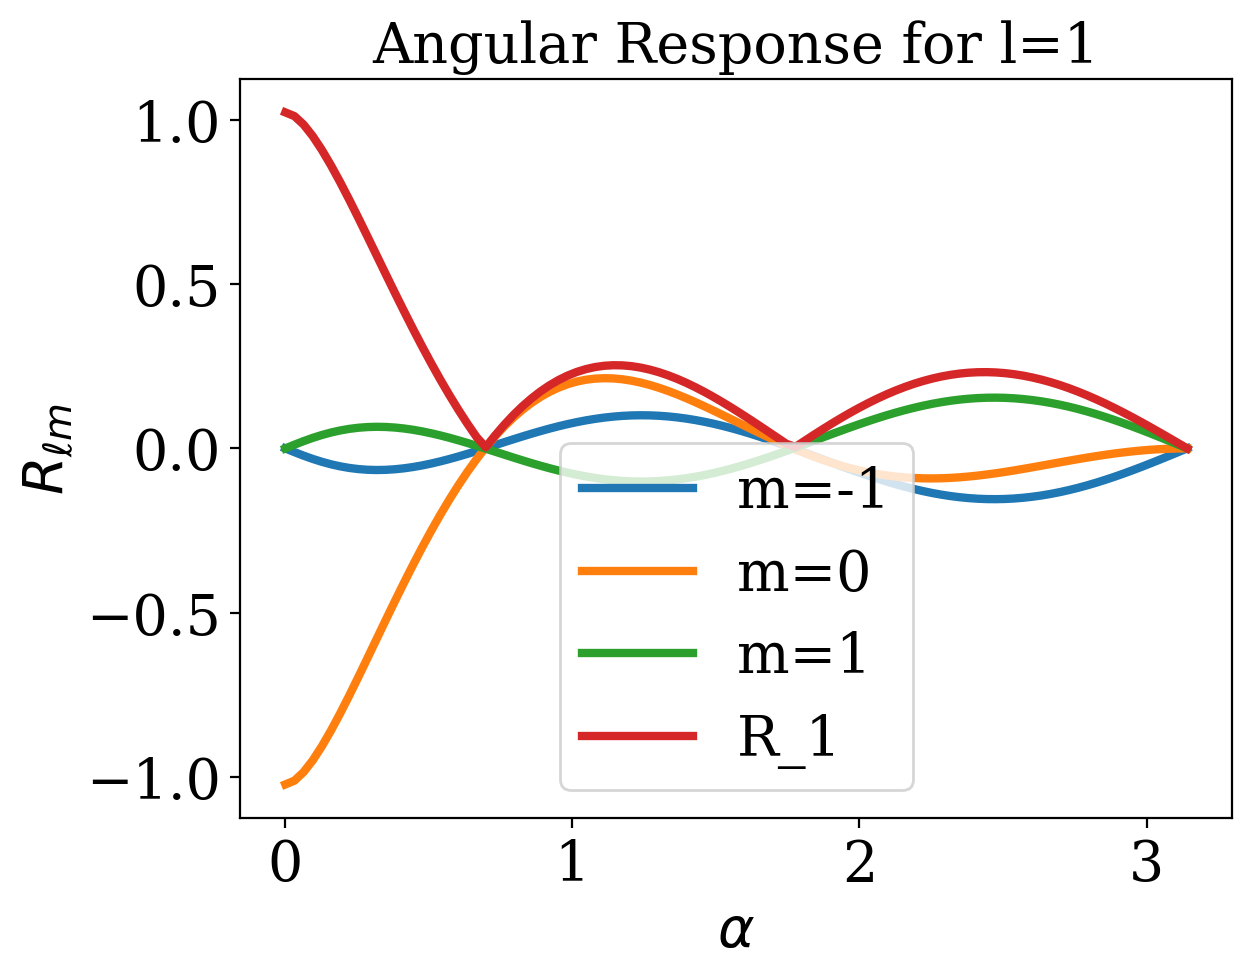

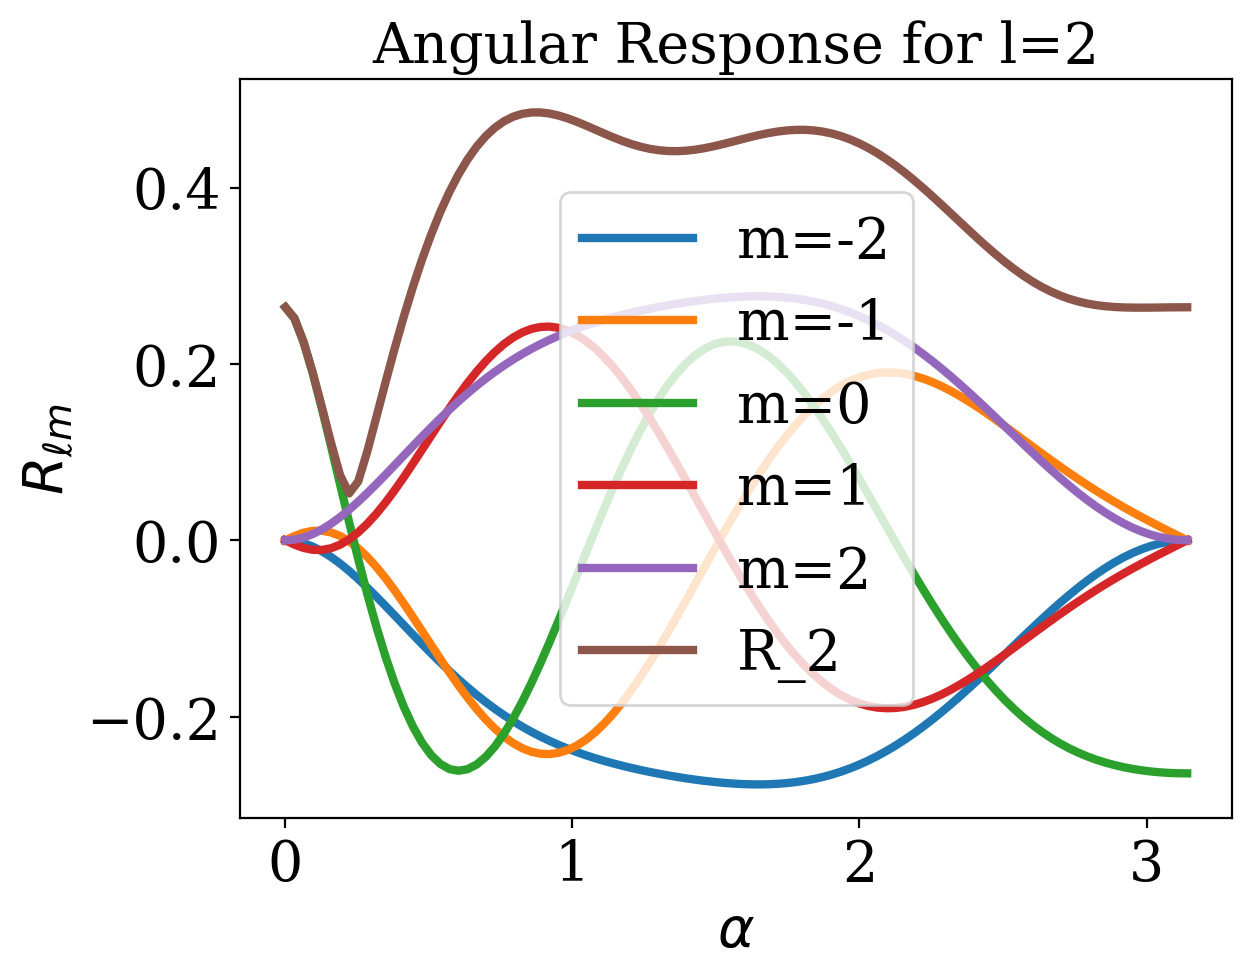

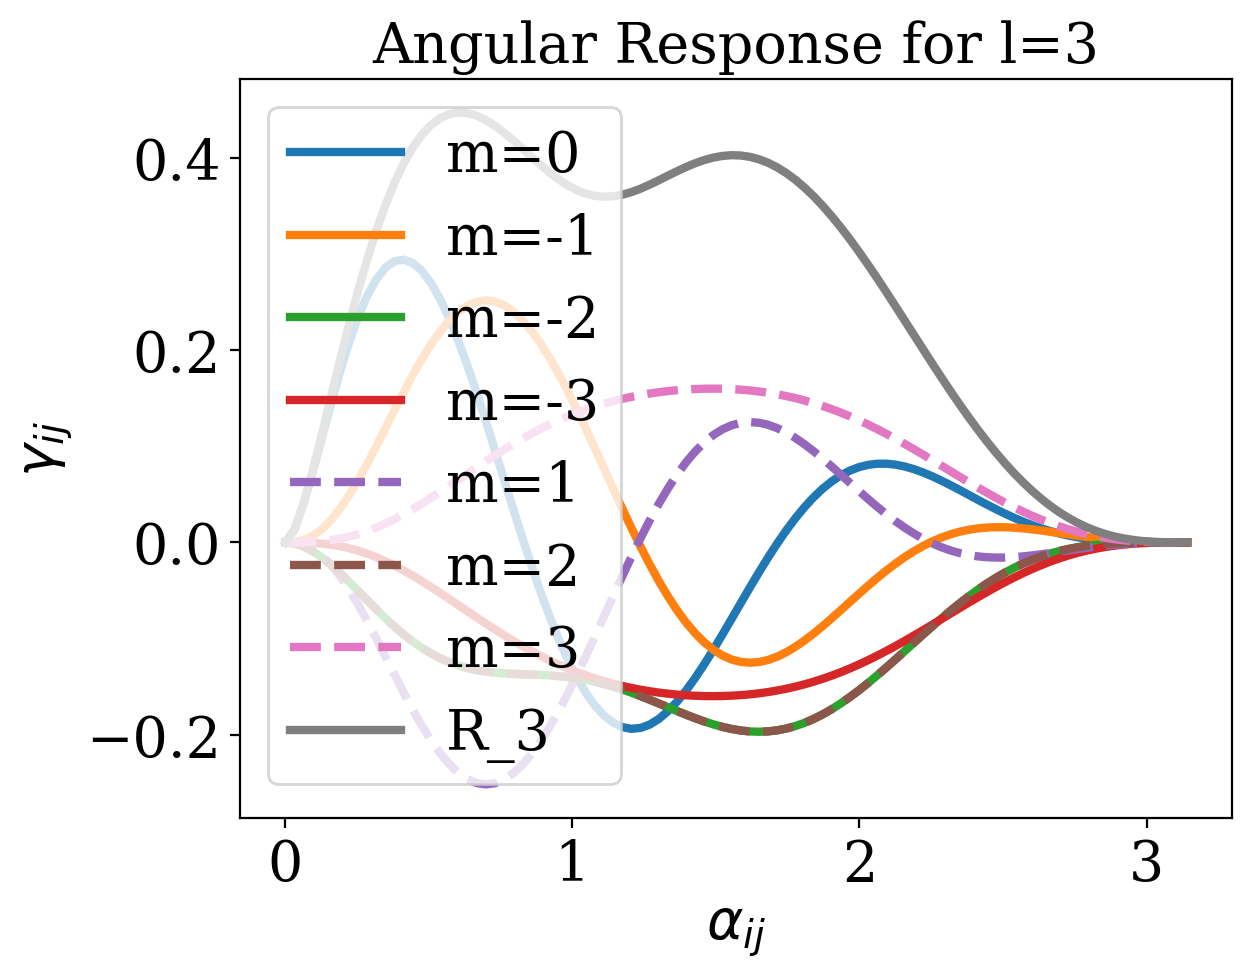

In [725]:
epsilon = 1e-5
alpha= np.linspace(epsilon, np.pi- epsilon, 100)

# l = 1 
plt.plot(alpha,R_1_1(alpha), label='m=-1' )
plt.plot(alpha, R_10(alpha), label='m=0')
plt.plot(alpha, R_11(alpha), label='m=1')
plt.plot(alpha, R_1(alpha), label='R_1')
plt.title('Angular Response for l=1')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R_{\ell m}$')
plt.legend()
plt.show()

# l = 2 
plt.plot(alpha, R_2_2(alpha), label='m=-2')
plt.plot(alpha, R_2_1(alpha), label='m=-1')
plt.plot(alpha, R_20(alpha), label='m=0')
plt.plot(alpha, R_21(alpha), label='m=1')
plt.plot(alpha, R_22(alpha), label='m=2')
plt.plot(alpha, R_2(alpha), label='R_2')
plt.title('Angular Response for l=2')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R_{\ell m}$')
plt.legend()
plt.show()


# l = 3

plt.plot(alpha, R_3_0(alpha), label='m=0')
plt.plot(alpha, R_3_1(alpha), label='m=-1')
plt.plot(alpha, R_3_2(alpha), label='m=-2')
plt.plot(alpha, R_3_3(alpha), label='m=-3')
plt.plot(alpha, R_31(alpha), label='m=1', linestyle='dashed')
plt.plot(alpha, R_32(alpha), label='m=2', linestyle='dashed')
plt.plot(alpha, R_33(alpha), label='m=3', linestyle='dashed')
plt.plot(alpha, R_3(alpha), label='R_3')
plt.legend()
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Angular Response for l=3')
plt.show()


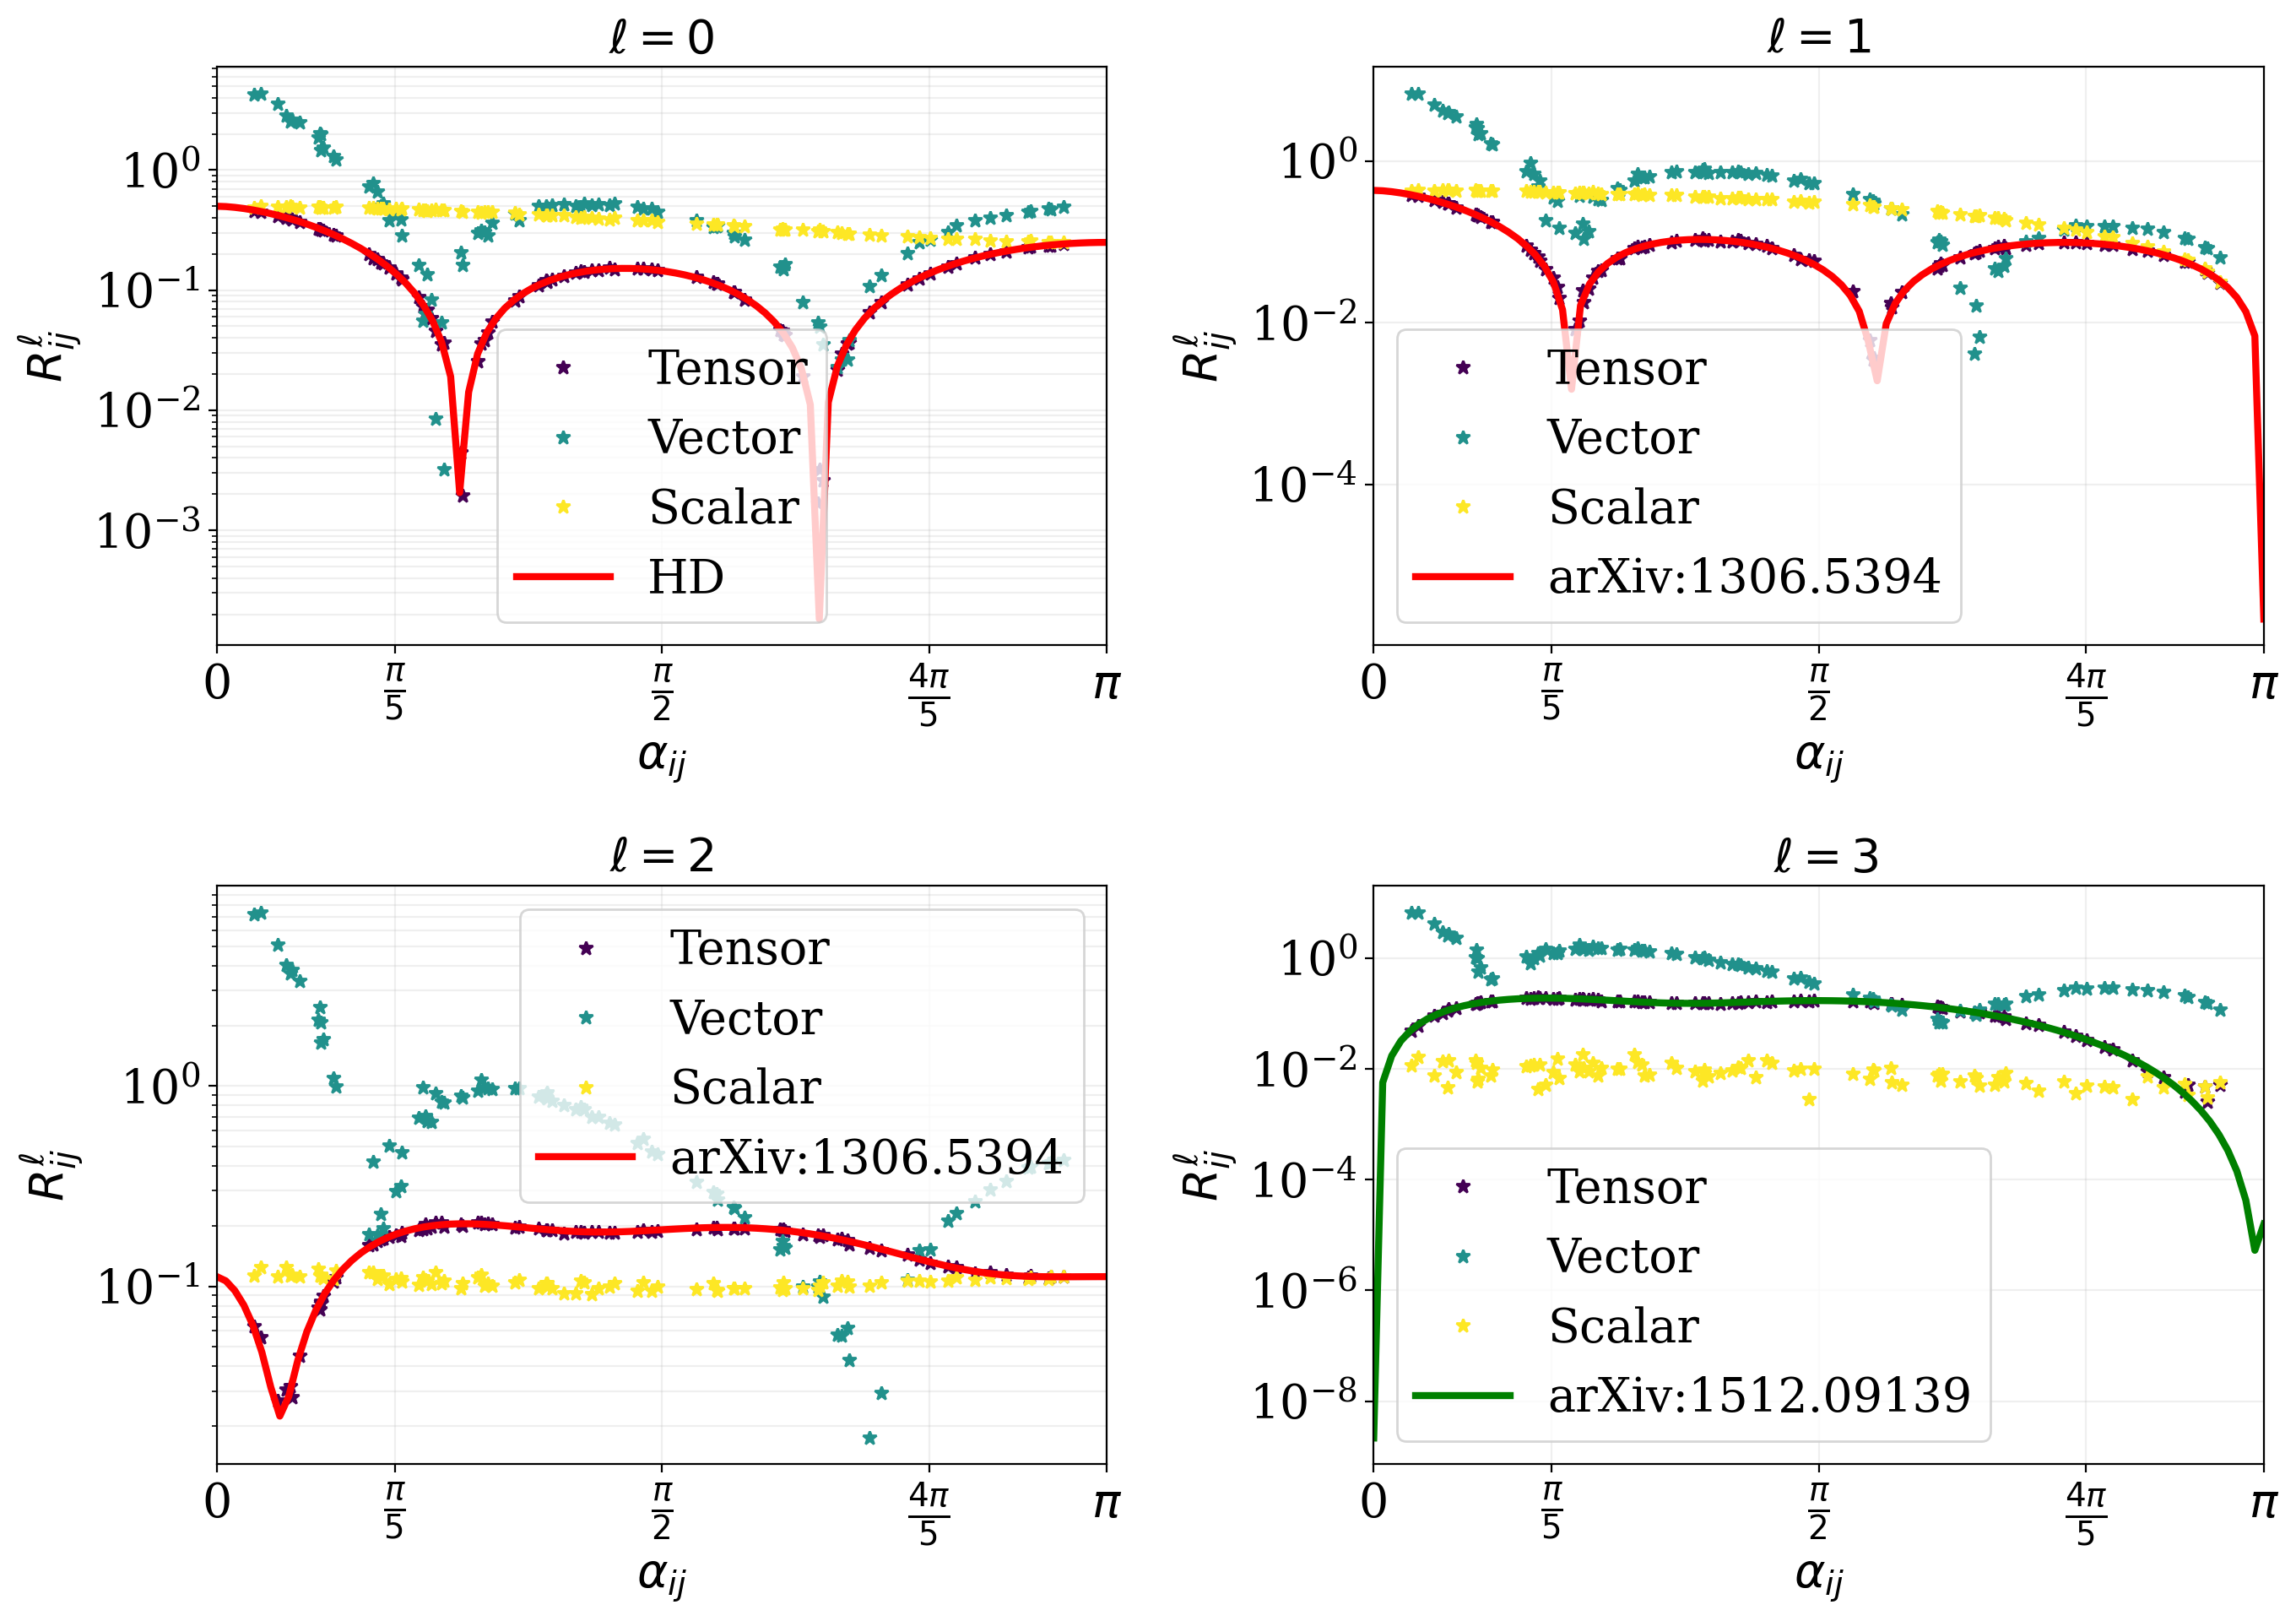

In [726]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
 
# Plot per ℓ=0
ax[0, 0].semilogy(alpha_ij, np.abs(gamma_ij_t_f_index), '*', color=colors[0], label='Tensor')
ax[0, 0].semilogy(alpha_ij, np.abs(gamma_ij_v_f_index), '*', color=colors[1], label='Vector')
ax[0, 0].semilogy(alpha_ij, np.abs(gamma_ij_s_f_index), '*', color=colors[2], label='Scalar')
ax[0, 0].semilogy(alpha, np.abs(hellings_downs(alpha)), color='red', label='HD')
ax[0, 0].set_xlabel(r'$\alpha_{ij}$')
ax[0, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 0].grid(which='both', alpha=0.2)
ax[0, 0].set_title(r'$\ell=0$')
ax[0, 0].set_xticks(custom_ticks)
ax[0, 0].set_xlim(0, np.pi)
ax[0, 0].legend()
ax[0, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=1
ax[0, 1].semilogy(alpha_ij, gamma1_ij_t_f_index, '*', color=colors[0], label='Tensor')
ax[0, 1].semilogy(alpha_ij, gamma1_ij_v_f_index, '*', color=colors[1], label='Vector')
ax[0, 1].semilogy(alpha_ij, gamma1_ij_s_f_index, '*', color=colors[2], label='Scalar')
ax[0, 1].semilogy(alpha, 3*np.sqrt(4*np.pi)/(8*np.pi)* R_1(alpha), color='red', label='arXiv:1306.5394')
ax[0, 1].set_xlabel(r'$\alpha_{ij}$')
ax[0, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 1].grid(which='both', alpha=0.2)
ax[0, 1].set_title(r'$\ell=1$')
ax[0, 1].set_xticks(custom_ticks)
ax[0, 1].set_xlim(0, np.pi)
ax[0, 1].legend()
ax[0, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=2
ax[1, 0].semilogy(alpha_ij, gamma2_ij_t_f_index, '*', color=colors[0], label='Tensor')
ax[1, 0].semilogy(alpha_ij, gamma2_ij_v_f_index, '*', color=colors[1], label='Vector')
ax[1, 0].semilogy(alpha_ij, gamma2_ij_s_f_index, '*', color=colors[2], label='Scalar')
ax[1, 0].semilogy(alpha, 3*np.sqrt(4*np.pi)/(8*np.pi)*R_2(alpha), color='red', label='arXiv:1306.5394')
ax[1, 0].set_xlabel(r'$\alpha_{ij}$')
ax[1, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 0].grid(which='both', alpha=0.2)
ax[1, 0].set_title(r'$\ell=2$')
ax[1, 0].set_xticks(custom_ticks)
ax[1, 0].legend()
ax[1, 0].set_xlim(0, np.pi)
ax[1, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=3
ax[1, 1].semilogy(alpha_ij, gamma3_ij_t_f_index, '*', color=colors[0], label='Tensor')
ax[1, 1].semilogy(alpha_ij, gamma3_ij_v_f_index, '*', color=colors[1], label='Vector')
ax[1, 1].semilogy(alpha_ij, gamma3_ij_s_f_index, '*', color=colors[2], label='Scalar')
ax[1, 1].semilogy(alpha, 3*np.sqrt(4*np.pi)/(8*np.pi)*R_3(alpha), color='green', label='arXiv:1512.09139')
ax[1, 1].set_xlabel(r'$\alpha_{ij}$')
ax[1, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 1].grid(which='both', alpha=0.2)
ax[1, 1].set_title(r' $\ell=3$')
ax[1, 1].set_xticks(custom_ticks)
ax[1, 1].legend()
ax[1, 1].set_xlim(0, np.pi)
ax[1, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

plt.tight_layout()
plt.show()

circular polarization

In [620]:
# functions to check the angular response https://journals.aps.org/prd/pdf/10.1103/PhysRevD.93.062003

# l=0
def RV_0(alpha):
    return np.zeros(len(alpha))

# l=1
def RV_1_1(alpha):
    return - np.sqrt(6*np.pi)/3 * np.sin(alpha) * ( 1 + 3*((1-np.cos(alpha))/(1+np.cos(alpha)))*np.log(np.sin(alpha/2)) )

def RV_11(alpha):
    return RV_1_1(alpha)

def RV_10(alpha):
    return np.zeros(len(alpha))

def RV_1(alpha):
    term1 = RV_1_1(alpha)
    term2 = RV_11(alpha)
    term3 = RV_10(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2)

# l=2
def RV_2_2(alpha):
    term1 = np.sqrt(30*np.pi)/6 * (1- np.cos(alpha))
    term2 = (2 - np.cos(alpha))
    term3 = 6 * ((1- np.cos(alpha))/(1+ np.cos(alpha))) * np.log(np.sin(alpha/2))
    return term1* (term2 + term3)

def RV_2_1(alpha):
    term1 = np.sqrt(30*np.pi)/6 * (np.sin(alpha)/(1+ np.cos(alpha)))
    term2 = 2
    term3 = (1- np.cos(alpha))
    term4 = (np.cos(alpha) + 6* np.log(np.sin(alpha/2)))
    return term1* (term2 + term3*term4)

def RV_20(alpha):
    return np.zeros(len(alpha))

def RV_21(alpha):
    return RV_2_1(alpha)

def RV_22(alpha):
    return -RV_2_2(alpha)

def RV_2(alpha):
    term1 = RV_2_2(alpha)
    term2 = RV_2_1(alpha)
    term3 = RV_20(alpha)
    term4 = RV_21(alpha)
    term5 = RV_22(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2)

# l = 3

def RV_3_3(alpha):
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term1 = - np.sqrt(35*np.pi)/16 * np.sin(alpha) * ratio
    term2 = 11 - 6*np.cos(alpha) - np.cos(alpha)**2
    term3 = 32 * ratio * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_2(alpha):
    term1 = - np.sqrt(210*np.pi)/24 * (1 - np.cos(alpha))
    term2 = 8 - 5*np.cos(alpha) - np.cos(alpha)**2
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 24*ratio*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_1(alpha):
    term1 = - np.sqrt(21*np.pi)/48 * np.sin(alpha)
    term2 = 33 - 20*np.cos(alpha) - 5*np.cos(alpha)**2
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 96* ratio *np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_0(alpha):
    return np.zeros(len(alpha))

def RV_31(alpha):
    return RV_3_1(alpha)

def RV_32(alpha):
    return -RV_3_2(alpha)

def RV_33(alpha):
    return RV_3_3(alpha)

def RV_3(alpha):
    term1 = RV_3_3(alpha)
    term2 = RV_3_2(alpha)
    term3 = RV_3_1(alpha)
    term4 = RV_3_0(alpha)
    term5 = RV_31(alpha)
    term6 = RV_32(alpha)
    term7 = RV_33(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2 + term6**2 + term7**2)


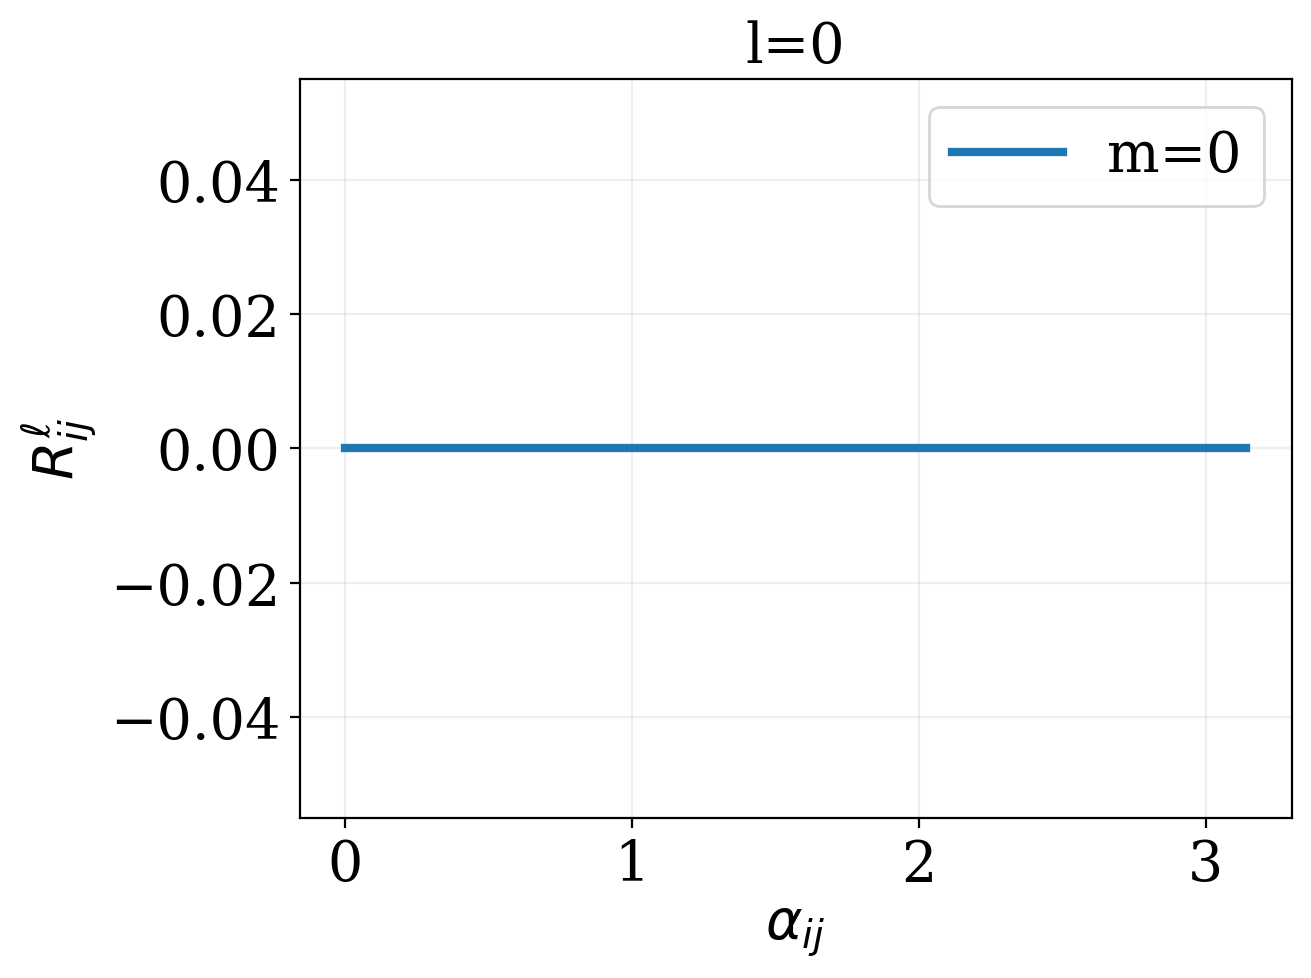

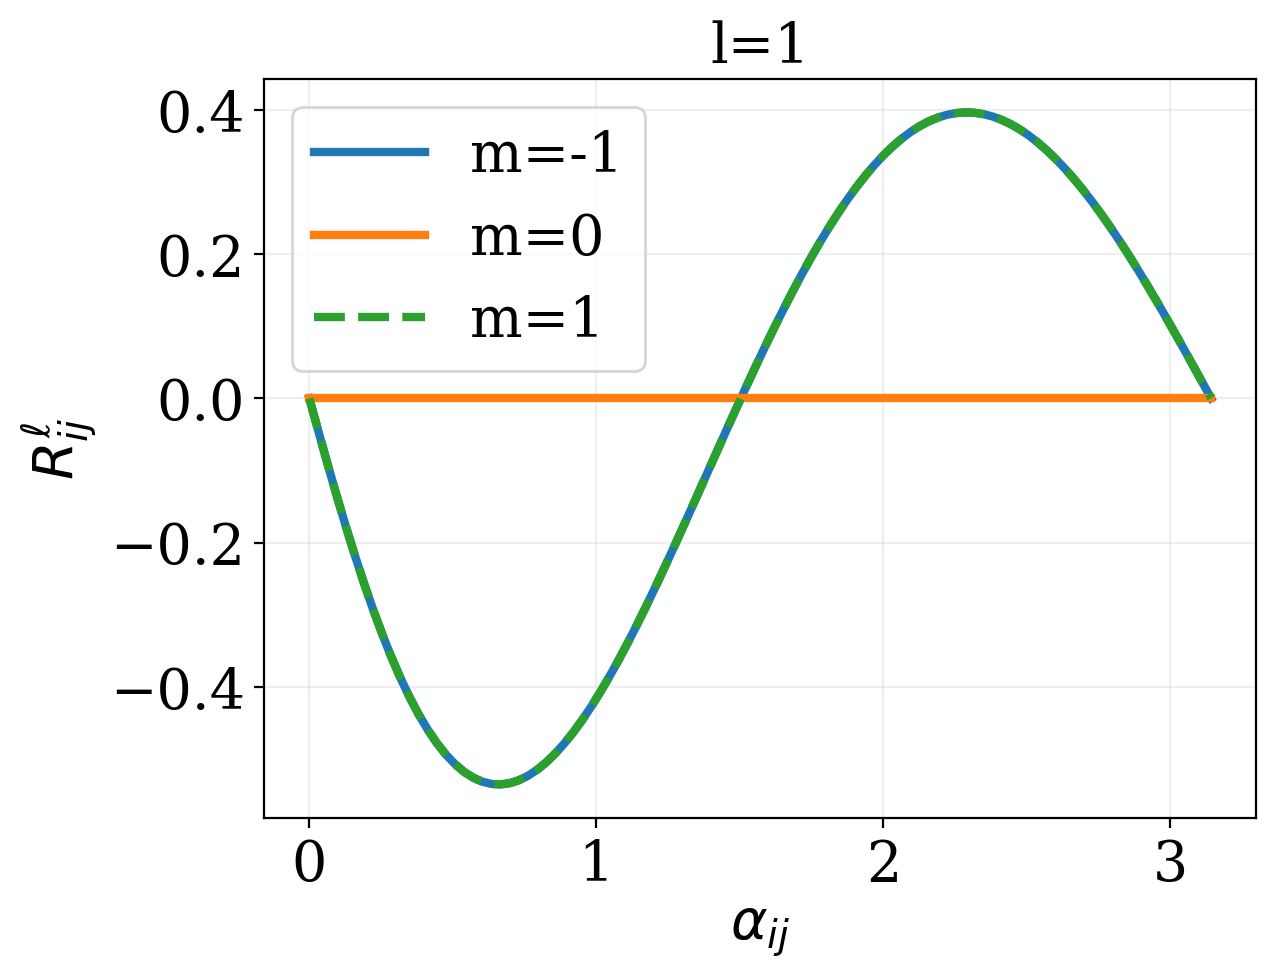

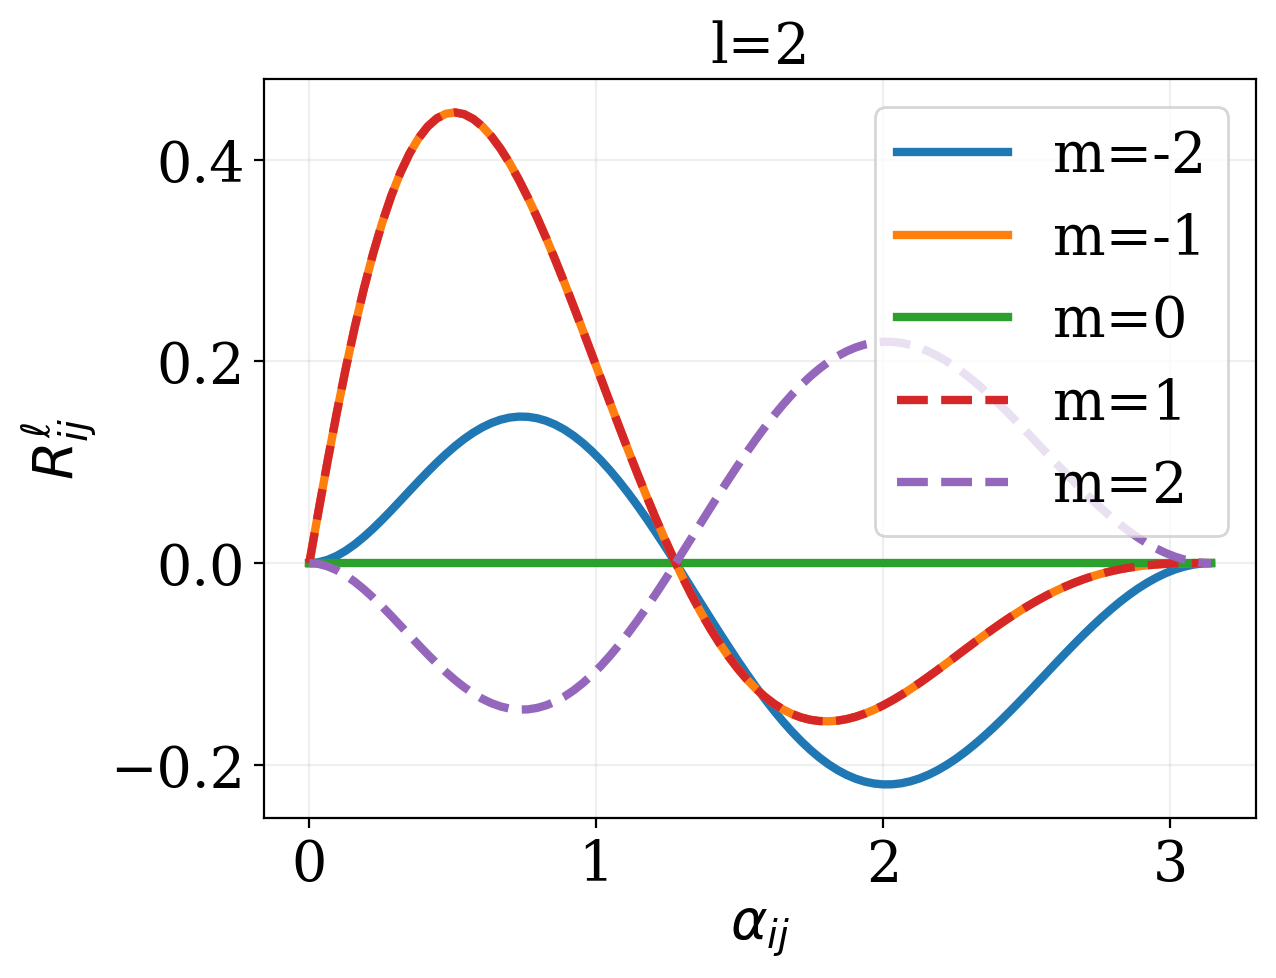

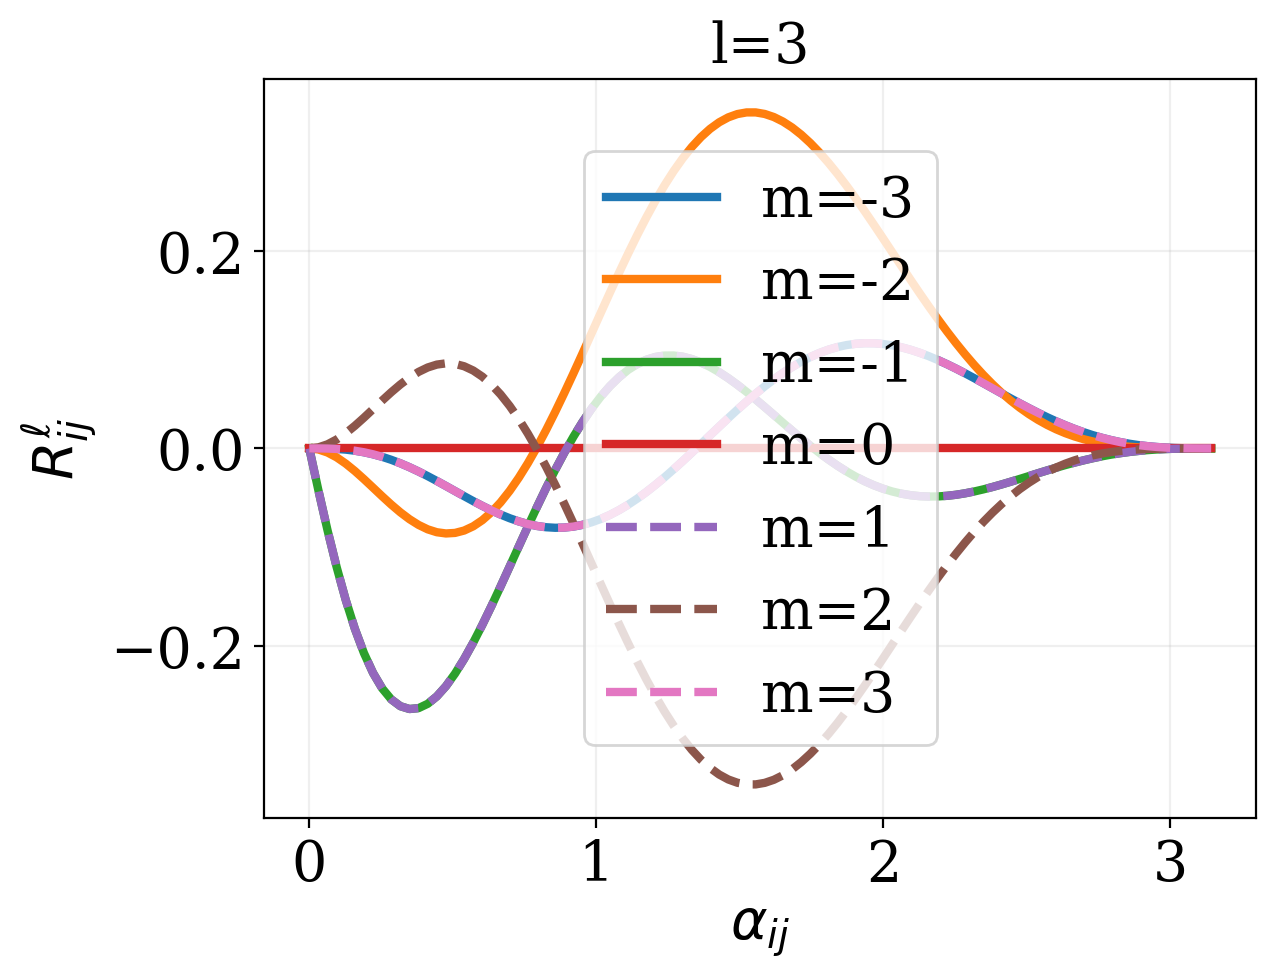

In [621]:
alpha = np.linspace(epsilon, np.pi - epsilon, 100)

# l = 0

plt.plot(alpha, RV_0(alpha), label='m=0')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=0')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 1
plt.plot(alpha, RV_1_1(alpha), label='m=-1')
plt.plot(alpha, RV_10(alpha), label='m=0')
plt.plot(alpha, RV_11(alpha), label='m=1', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=1')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 2
plt.plot(alpha, RV_2_2(alpha), label='m=-2')
plt.plot(alpha, RV_2_1(alpha), label='m=-1')
plt.plot(alpha, RV_20(alpha), label='m=0')
plt.plot(alpha, RV_21(alpha), label='m=1', linestyle = '--')
plt.plot(alpha, RV_22(alpha), label='m=2', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=2')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 3
plt.plot(alpha, RV_3_3(alpha), label='m=-3')
plt.plot(alpha, RV_3_2(alpha), label='m=-2')
plt.plot(alpha, RV_3_1(alpha), label='m=-1')
plt.plot(alpha, RV_3_0(alpha), label='m=0')
plt.plot(alpha, RV_31(alpha), label='m=1', linestyle = '--')
plt.plot(alpha, RV_32(alpha), label='m=2', linestyle = '--')
plt.plot(alpha, RV_33(alpha), label='m=3', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=3')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()


# ******* WIP *******

# Sensitivity Curves

In [728]:
psi = 0
Tobs_PTA = 15
snr_ = 1

f_PTA = np.logspace(-9, -7, 100)
colors = cm.viridis(np.linspace(0, 1, 3))
pls_NANOGrav_t = pls.PLS_PTA(f_PTA, snr_, Tobs_PTA, 't', psi)
pls_NANOGrav_v = pls.PLS_PTA(f_PTA, snr_, Tobs_PTA, 'v', psi)
pls_NANOGrav_s = pls.PLS_PTA(f_PTA, snr_, Tobs_PTA, 's', psi)
pls_NANOGrav_V = pls.PLS_PTA(f_PTA, snr_, Tobs_PTA, 'V', psi)



2025-06-18 14:21:36.882 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-06-18 14:25:59.801 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


Text(0.5, 1.0, 'PTA PLS')

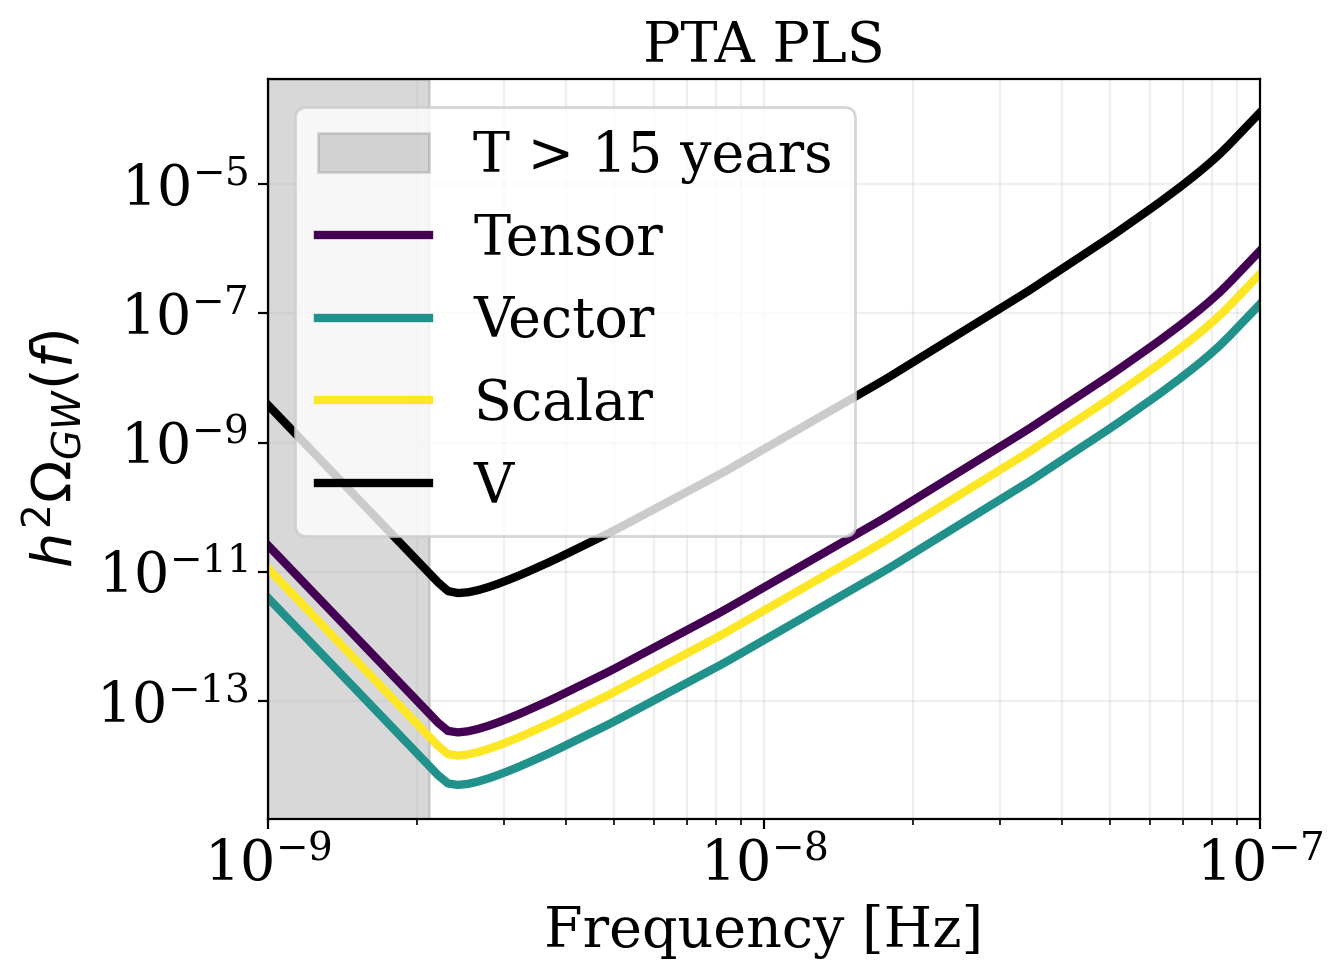

In [ ]:
T_15_years = 15 * 365 * 24 * 3600  # in secondi
f_15_years = 1 / T_15_years  # in Hz
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')

plt.plot(f_PTA, pls_NANOGrav_t, label='Tensor', color=colors[0])
plt.plot(f_PTA, pls_NANOGrav_v, label='Vector', color=colors[1])
plt.plot(f_PTA, pls_NANOGrav_s, label='Scalar', color=colors[2])
plt.plot(f_PTA, pls_NANOGrav_V, label='V', color='black')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both', alpha=0.2)
plt.xlim(f_PTA.min(), f_PTA.max())
plt.legend()
plt.title('PTA PLS')

#beepy.beep(sound=1) 

In [ ]:
print(np.min(pls_NANOGrav_t))
print(np.min(pls_NANOGrav_v))
print(np.min(pls_NANOGrav_s))

3.30836793986766e-14
5.090831089208203e-15
1.45008370872803e-14


6.77798365505009e-10
1.0225966903603887e-11
4.785946104159111e-10

1.1631995935335099e-11
1.7177910450965716e-12
5.100814777408018e-12

2025-05-28 11:52:25.476 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 11:58:52.600 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 12:18:13.073 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 12:50:18.843 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


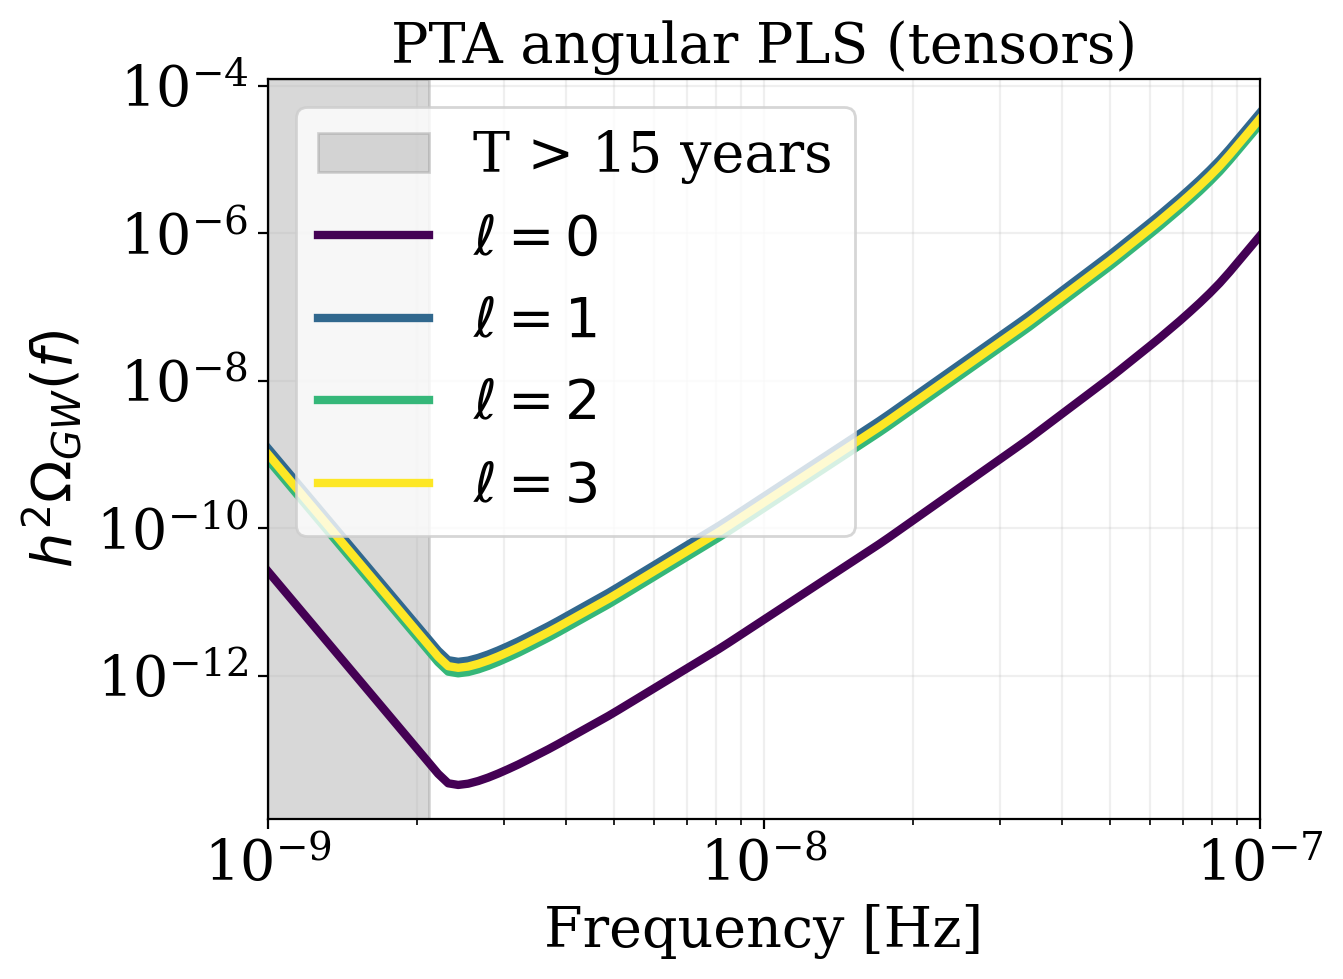

In [ ]:
f = np.logspace(-9, -7, 100)
snr = 1
Tobs = 15
psi=0

colors = cm.viridis(np.linspace(0, 1, 4))

#tensors

T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')


pls_NANOGrav_0 = Sensitivity_ell.APLS_ell_PTA(0, f, snr, Tobs, 1, 't', psi)
pls_NANOGrav_1 = Sensitivity_ell.APLS_ell_PTA(1, f, snr, Tobs, 1e-3, 't', psi)
pls_NANOGrav_2 = Sensitivity_ell.APLS_ell_PTA(2, f, snr, Tobs, 1e-3, 't', psi)
pls_NANOGrav_3 = Sensitivity_ell.APLS_ell_PTA(3, f, snr, Tobs, 1e-3, 't', psi)


plt.loglog(f, pls_NANOGrav_0, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2, label=r'$\ell=2$', color=colors[2])
plt.loglog(f, pls_NANOGrav_3, label=r'$\ell=3$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('PTA angular PLS (tensors)')
plt.grid(which='both', alpha=0.2)

In [ ]:
print(np.min(pls_NANOGrav_0))
print(np.min(pls_NANOGrav_1))
print(np.min(pls_NANOGrav_2))
print(np.min(pls_NANOGrav_3))

3.308001915571606e-14
1.543657340674699e-12
1.0795935569780923e-12
1.2815624011011002e-12


2025-05-28 13:41:51.182 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 13:48:24.696 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 14:07:30.703 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 14:39:51.647 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


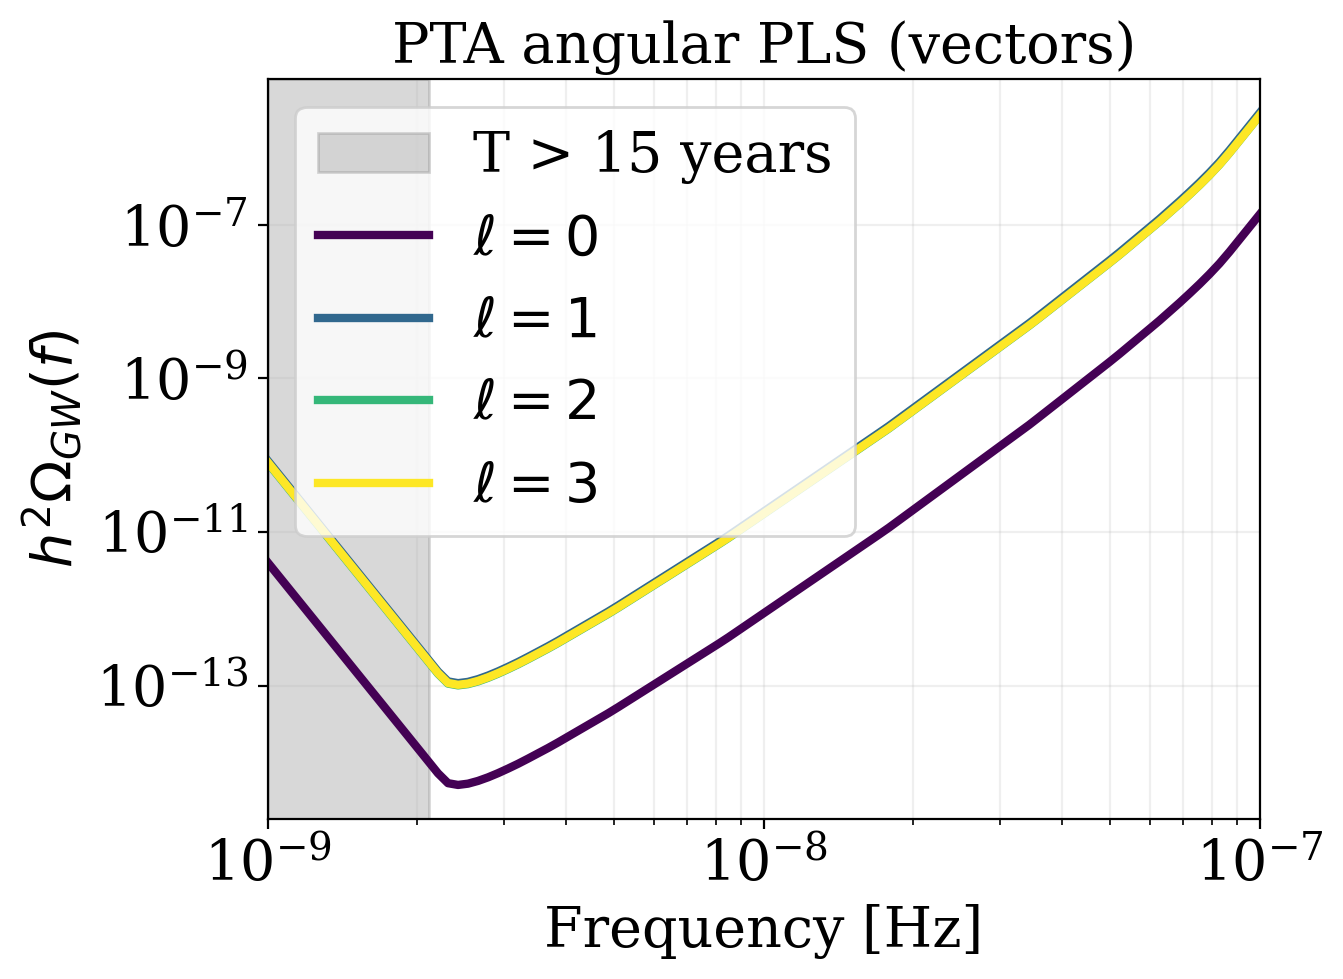

In [ ]:
#vectors

pls_NANOGrav_0 = Sensitivity_ell.ALS_ell_PTA(0, f, snr, Tobs, 1, 'v', psi)
pls_NANOGrav_1 = Sensitivity_ell.APLS_ell_PTA(1, f, snr, Tobs, 1e-3, 'v', psi)
pls_NANOGrav_2 = Sensitivity_ell.APLS_ell_PTA(2, f, snr, Tobs, 1e-3, 'v', psi)
pls_NANOGrav_3 = Sensitivity_ell.APLS_ell_PTA(3, f, snr, Tobs, 1e-3, 'v', psi)

T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')



plt.loglog(f, pls_NANOGrav_0, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2, label=r'$\ell=2$', color=colors[2])
plt.loglog(f, pls_NANOGrav_3, label=r'$\ell=3$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('PTA angular PLS (vectors)')
plt.grid(which='both', alpha=0.2)

In [ ]:
print(np.min(pls_NANOGrav_0))
print(np.min(pls_NANOGrav_1))
print(np.min(pls_NANOGrav_2))
print(np.min(pls_NANOGrav_3))

4.991905474565919e-15
1.0501351988815486e-13
9.71213438058735e-14
9.726224986627935e-14


2025-05-12 13:52:37.734 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 13:54:19.871 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 13:59:12.121 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 14:07:11.096 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


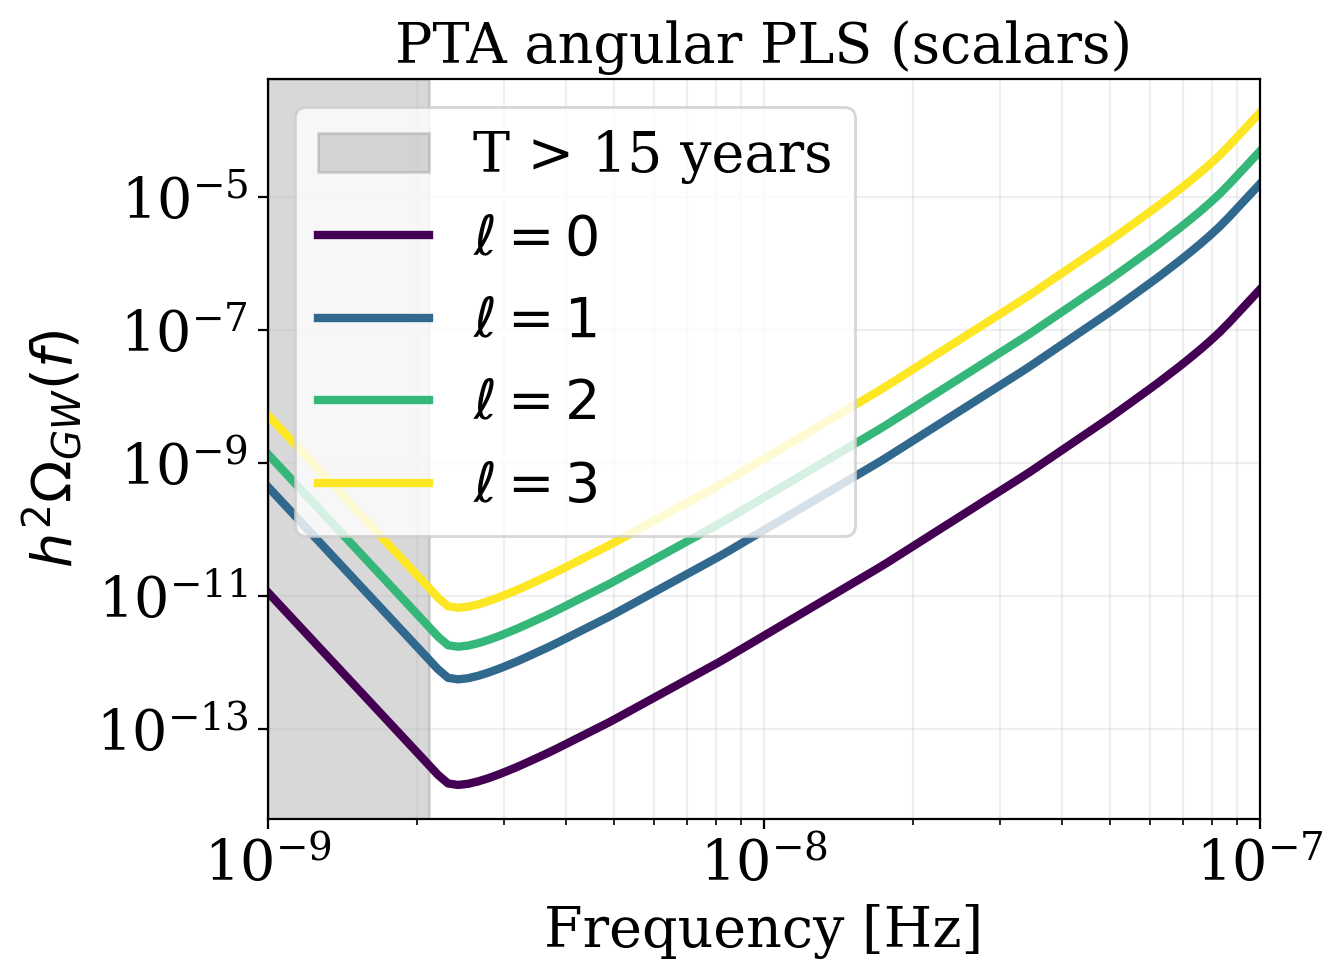

In [ ]:
#scalars

pls_NANOGrav_0 = Sensitivity_ell.APLS_ell_PTA(0, f, snr, Tobs, 1, 's', psi)
pls_NANOGrav_1 = Sensitivity_ell.APLS_ell_PTA(1, f, snr, Tobs, 1e-3, 's', psi)
pls_NANOGrav_2 = Sensitivity_ell.APLS_ell_PTA(2, f, snr, Tobs, 1e-3, 's', psi)
pls_NANOGrav_3 = Sensitivity_ell.APLS_ell_PTA(3, f, snr, Tobs, 1e-3, 's', psi)

T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')

plt.loglog(f, pls_NANOGrav_0, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2, label=r'$\ell=2$', color=colors[2])
plt.loglog(f, pls_NANOGrav_3, label=r'$\ell=3$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('PTA angular PLS (scalars)')
plt.grid(which='both', alpha=0.2)

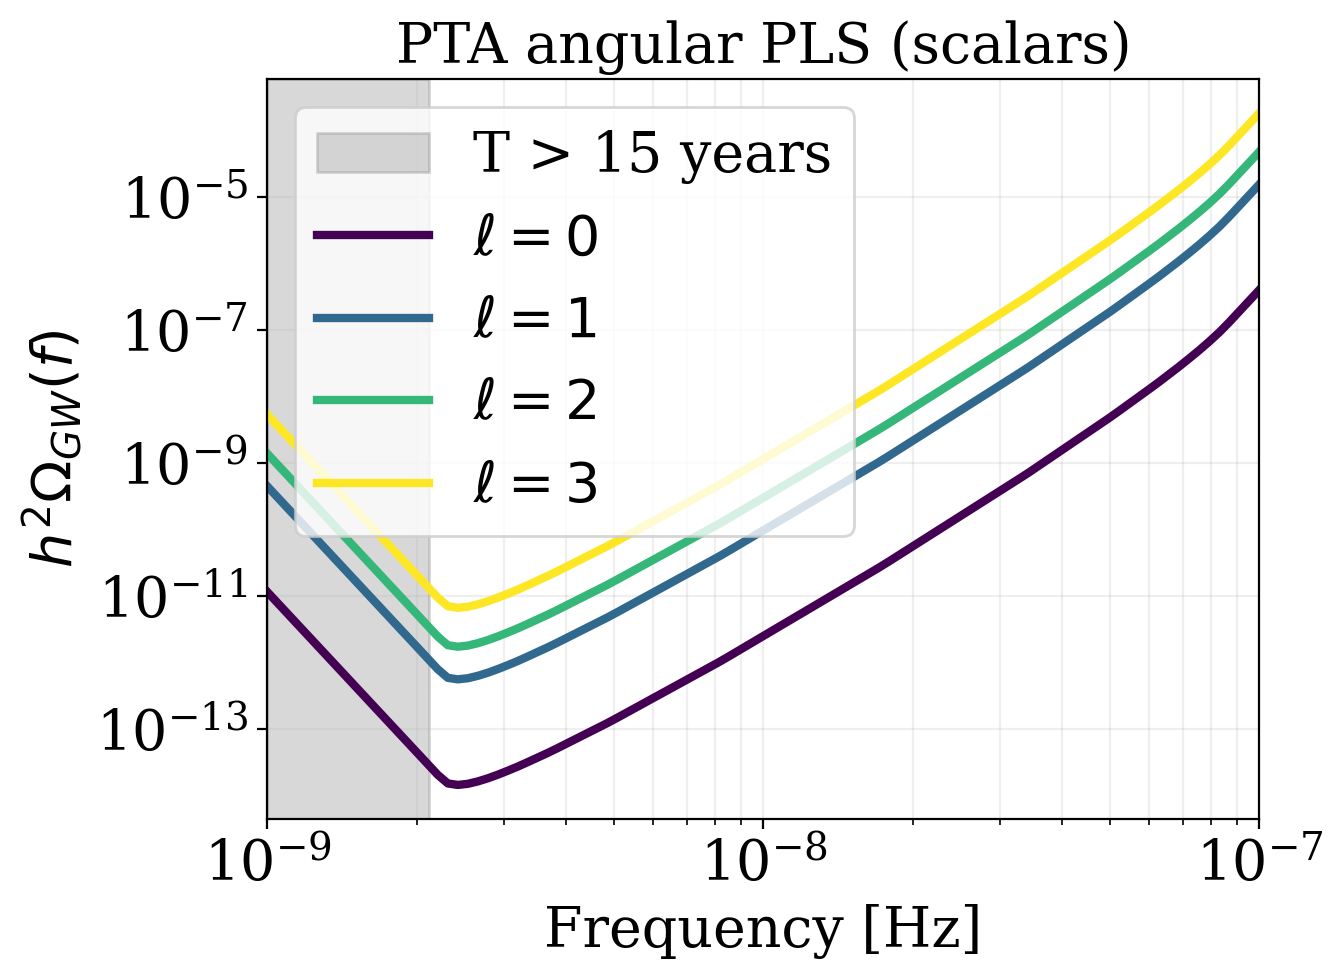

In [ ]:
T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz
colors = cm.viridis(np.linspace(0, 1, 4))
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')

plt.loglog(f, pls_NANOGrav_0, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2, label=r'$\ell=2$', color=colors[2])
plt.loglog(f, pls_NANOGrav_3, label=r'$\ell=3$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('PTA angular PLS (scalars)')
plt.grid(which='both', alpha=0.2)

In [ ]:
print(np.min(pls_NANOGrav_0))
print(np.min(pls_NANOGrav_1))
print(np.min(pls_NANOGrav_2))
print(np.min(pls_NANOGrav_3))

1.450870370781445e-14
5.607412761767533e-13
1.7342373108764302e-12
6.6716080994415414e-12


2025-05-12 14:20:01.730 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 14:21:41.975 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 14:26:31.124 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 14:34:28.876 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


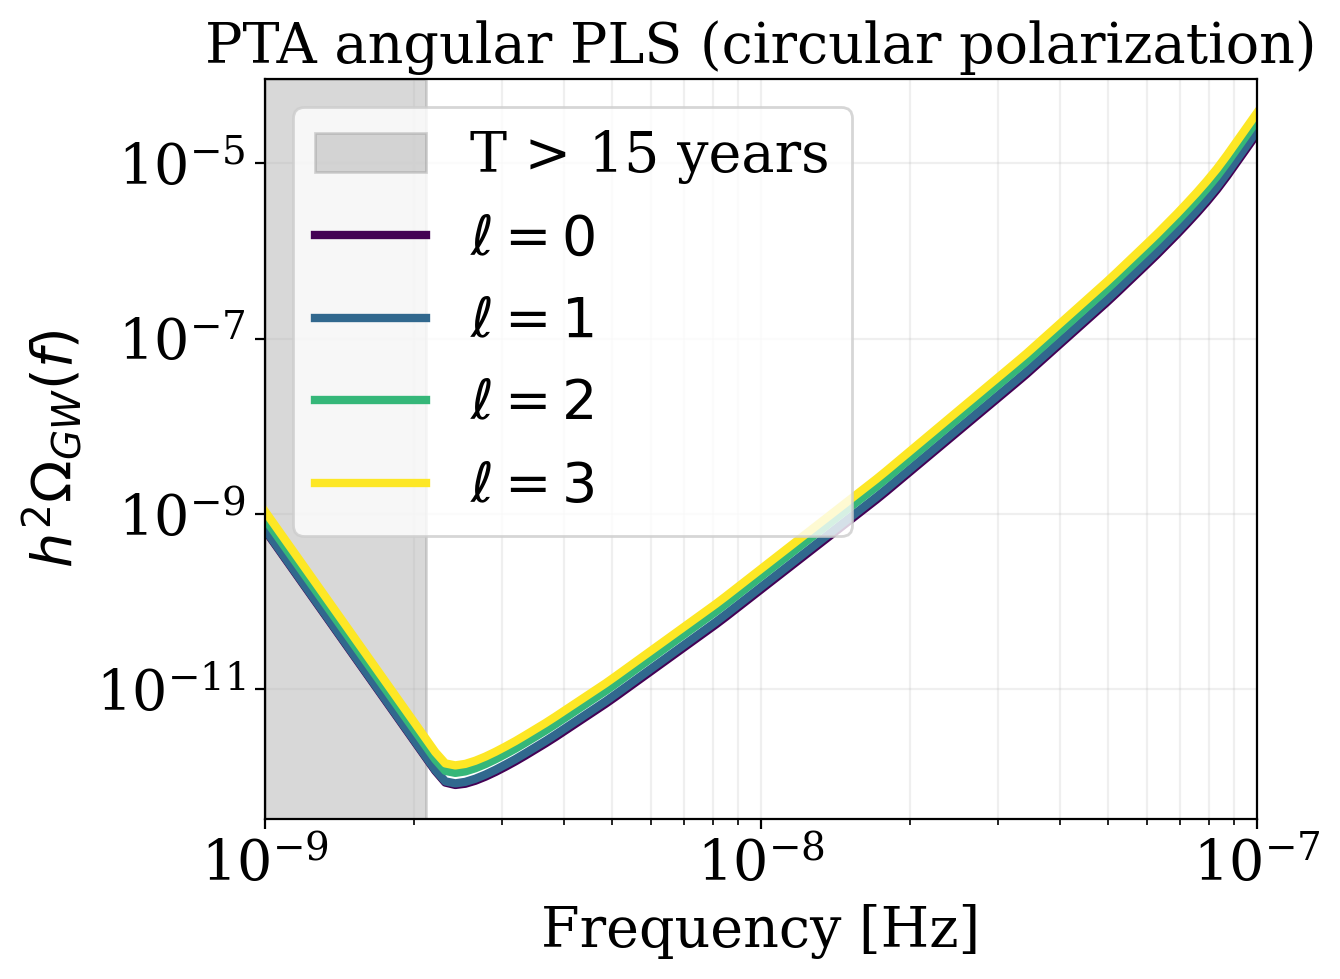

In [ ]:
# circular polarization

pls_NANOGrav_0_V = Sensitivity_ell.APLS_ell_PTA(0, f, snr, Tobs, 1, 'V', psi)
pls_NANOGrav_1_V = Sensitivity_ell.APLS_ell_PTA(1, f, snr, Tobs, 1e-3, 'V', psi)
pls_NANOGrav_2_V = Sensitivity_ell.APLS_ell_PTA(2, f, snr, Tobs, 1e-3, 'V', psi)
pls_NANOGrav_3_V = Sensitivity_ell.APLS_ell_PTA(3, f, snr, Tobs, 1e-3, 'V', psi)

T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')

plt.loglog(f, pls_NANOGrav_0_V, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1_V, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2_V, label=r'$\ell=2$', color=colors[2])
plt.loglog(f, pls_NANOGrav_3_V, label=r'$\ell=3$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('PTA angular PLS (circular polarization)')
plt.grid(which='both', alpha=0.2)

# Circular polarization tests

In [575]:
# check the circular polarization in the two frames (for the monopole)

# cosmic rest frame monopole


gamma_ij_V_crf = []
alpha_ij = []

psi = 0
for i in range(int(N/2)):
    for j in range(i+1, int(N/2)):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        #gamma0_ij_V_crf.append(AngularResponse.R_ell_pairwise(0, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], f, 'V', psi))
        gamma_ij_V_crf.append(Response.pairwise_overlap(f, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], 'V', 0))


gamma_ij_V_crf = np.array(gamma_ij_V_crf)
alpha_ij = np.array(alpha_ij)

In [540]:
# cosmic rest frame ell = 0 

gamma0_ij_V_crf = []
alpha_ij = []

psi = 0
for i in range(int(N)):
    for j in range(i+1, int(N)):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma0_ij_V_crf.append(AngularResponse.R_ell_pairwise(0, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], f, 'V', psi))


gamma0_ij_V_crf= np.array(gamma0_ij_V_crf)
alpha_ij = np.array(alpha_ij)

In [576]:
# computational frame

#gamma0_ij_V_comp = []
gamma_ij_V_comp = []
alpha_ij_comp = []

for i in range(int(N/2)):
    for j in range(i+1, int(N/2)):
        alpha = np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j]))
        p_i_comp = np.array([0, 0, 1])
        p_j_comp = np.array([np.sin(alpha), 0, np.cos(alpha)])
        #gamma0_ij_V_comp.append(AngularResponse.R_ell_pairwise(0, p_i_comp, p_j_comp,  0, 0, f, 'V', psi))
        gamma_ij_V_comp.append(Response.pairwise_overlap(f, p_i_comp, p_j_comp,  d[i], d[j], 'V', 0))

        alpha_ij_comp.append(alpha)

gamma_ij_V_comp = np.array(gamma_ij_V_comp)
alpha_ij_comp = np.array(alpha_ij_comp)        

In [577]:
print(gamma_ij_V_comp)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [578]:
np.abs(gamma_ij_V_crf[:, 0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float64)

In [579]:
print(alpha_ij.shape)
print(gamma_ij_V_crf.shape)
print(gamma_ij_V_comp.shape)


(21,)
(21, 100)
(21, 100)


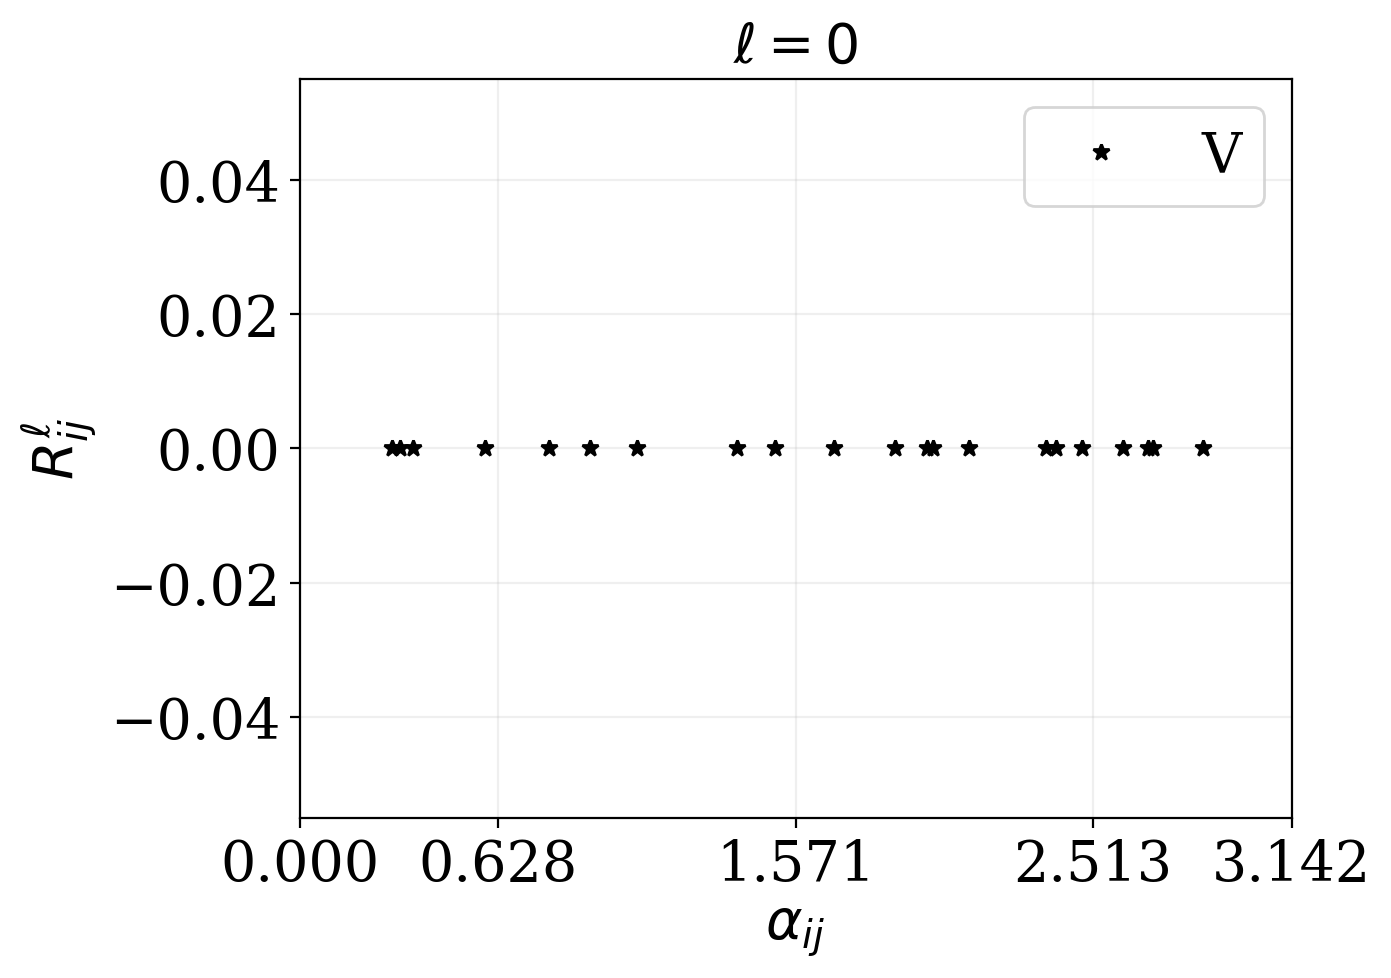

In [581]:
# Plot per ℓ=0
plt.plot(alpha_ij, np.abs(gamma_ij_V_crf[:, 0]), '*', color='black', label='V')
#plt.semilogy(alpha_ij, gamma0_ij_V_crf[:,0], '*', color=colors[0], label='V l=0')
#plt.plot(alpha_ij_comp, np.abs(gamma_ij_V_comp[:, 20]), '*', color=colors[1], label='V')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.grid(which='both', alpha=0.2)
plt.title(r'$\ell=0$')
plt.xticks(custom_ticks)
plt.legend()
#plt.xaxis.major_formatter(FuncFormatter(custom_pi_formatter))

In [253]:
gamma0_ij_V = []
gamma1_ij_V = []
gamma2_ij_V = []
gamma3_ij_V = []

alpha_ij = []

psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma0_ij_V.append(AngularResponse.R_ell_pairwise(0, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], f, 'V', psi))
        gamma1_ij_V.append(AngularResponse.R_ell_pairwise(1, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'V', psi))
        gamma2_ij_V.append(AngularResponse.R_ell_pairwise(2, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'V', psi))
        gamma3_ij_V.append(AngularResponse.R_ell_pairwise(3, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'V', psi))

gamma0_ij_V = np.array(gamma0_ij_V)
gamma1_ij_V = np.array(gamma1_ij_V)
gamma2_ij_V = np.array(gamma2_ij_V)
gamma3_ij_V = np.array(gamma3_ij_V)
alpha_ij = np.array(alpha_ij)


KeyboardInterrupt: 

In [54]:
gamma0_ij_V = []


alpha_ij = []

psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma0_ij_V.append(AngularResponse.R_ell_pairwise(0, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], f, 'V', -np.pi/2))

gamma0_ij_V = np.array(gamma0_ij_V)


In [52]:
f_index = np.argmin(np.abs(f - 1e-8))
print(f_index)
gamma0_ij_V_f_index = gamma0_ij_V[:,f_index]
gamma1_ij_V_f_index = gamma1_ij_V[:,f_index]
gamma2_ij_V_f_index = gamma2_ij_V[:,f_index]
gamma3_ij_V_f_index = gamma3_ij_V[:,f_index]


49


In [48]:
# functions to check the angular response https://journals.aps.org/prd/pdf/10.1103/PhysRevD.93.062003

# l=0
def RV_0(alpha):
    return np.zeros(len(alpha))

# l=1
def RV_1_1(alpha):
    return - np.sqrt(6*np.pi)/3 * np.sin(alpha) * ( 1 + 3*((1-np.cos(alpha))/(1+np.cos(alpha)))*np.log(np.sin(alpha/2)) )

def RV_11(alpha):
    return RV_1_1(alpha)

def RV_10(alpha):
    return np.zeros(len(alpha))

def RV_1(alpha):
    term1 = RV_1_1(alpha)
    term2 = RV_11(alpha)
    term3 = RV_10(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2)

# l=2
def RV_2_2(alpha):
    term1 = np.sqrt(30*np.pi)/6 * (1- np.cos(alpha))
    term2 = (2 - np.cos(alpha))
    term3 = 6 * ((1- np.cos(alpha))/(1+ np.cos(alpha))) * np.log(np.sin(alpha/2))
    return term1* (term2 + term3)

def RV_2_1(alpha):
    term1 = np.sqrt(30*np.pi)/6 * (np.sin(alpha)/(1+ np.cos(alpha)))
    term2 = 2
    term3 = (1- np.cos(alpha))
    term4 = (np.cos(alpha) + 6* np.log(np.sin(alpha/2)))
    return term1* (term2 + term3*term4)

def RV_20(alpha):
    return np.zeros(len(alpha))

def RV_21(alpha):
    return RV_2_1(alpha)

def RV_22(alpha):
    return -RV_2_2(alpha)

def RV_2(alpha):
    term1 = RV_2_2(alpha)
    term2 = RV_2_1(alpha)
    term3 = RV_20(alpha)
    term4 = RV_21(alpha)
    term5 = RV_22(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2)

# l = 3

def RV_3_3(alpha):
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term1 = - np.sqrt(35*np.pi)/16 * np.sin(alpha) * ratio
    term2 = 11 - 6*np.cos(alpha) - np.cos(alpha)**2
    term3 = 32 * ratio * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_2(alpha):
    term1 = - np.sqrt(210*np.pi)/24 * (1 - np.cos(alpha))
    term2 = 8 - 5*np.cos(alpha) - np.cos(alpha)**2
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 24*ratio*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_1(alpha):
    term1 = - np.sqrt(21*np.pi)/48 * np.sin(alpha)
    term2 = 33 - 20*np.cos(alpha) - 5*np.cos(alpha)**2
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 96* ratio *np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_0(alpha):
    return np.zeros(len(alpha))

def RV_31(alpha):
    return RV_3_1(alpha)

def RV_32(alpha):
    return -RV_3_2(alpha)

def RV_33(alpha):
    return RV_3_3(alpha)

def RV_3(alpha):
    term1 = RV_3_3(alpha)
    term2 = RV_3_2(alpha)
    term3 = RV_3_1(alpha)
    term4 = RV_3_0(alpha)
    term5 = RV_31(alpha)
    term6 = RV_32(alpha)
    term7 = RV_33(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2 + term6**2 + term7**2)


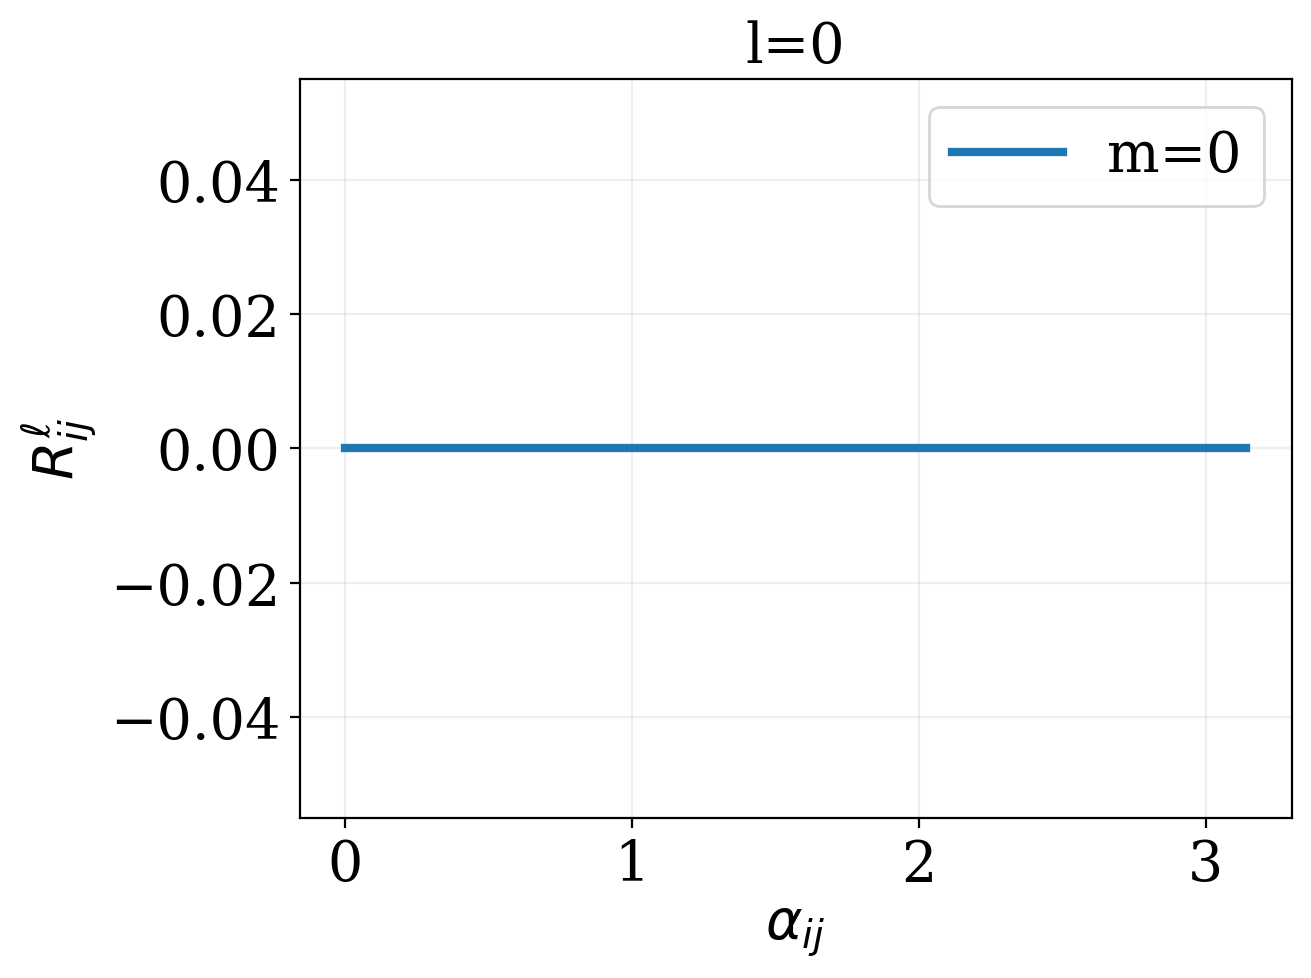

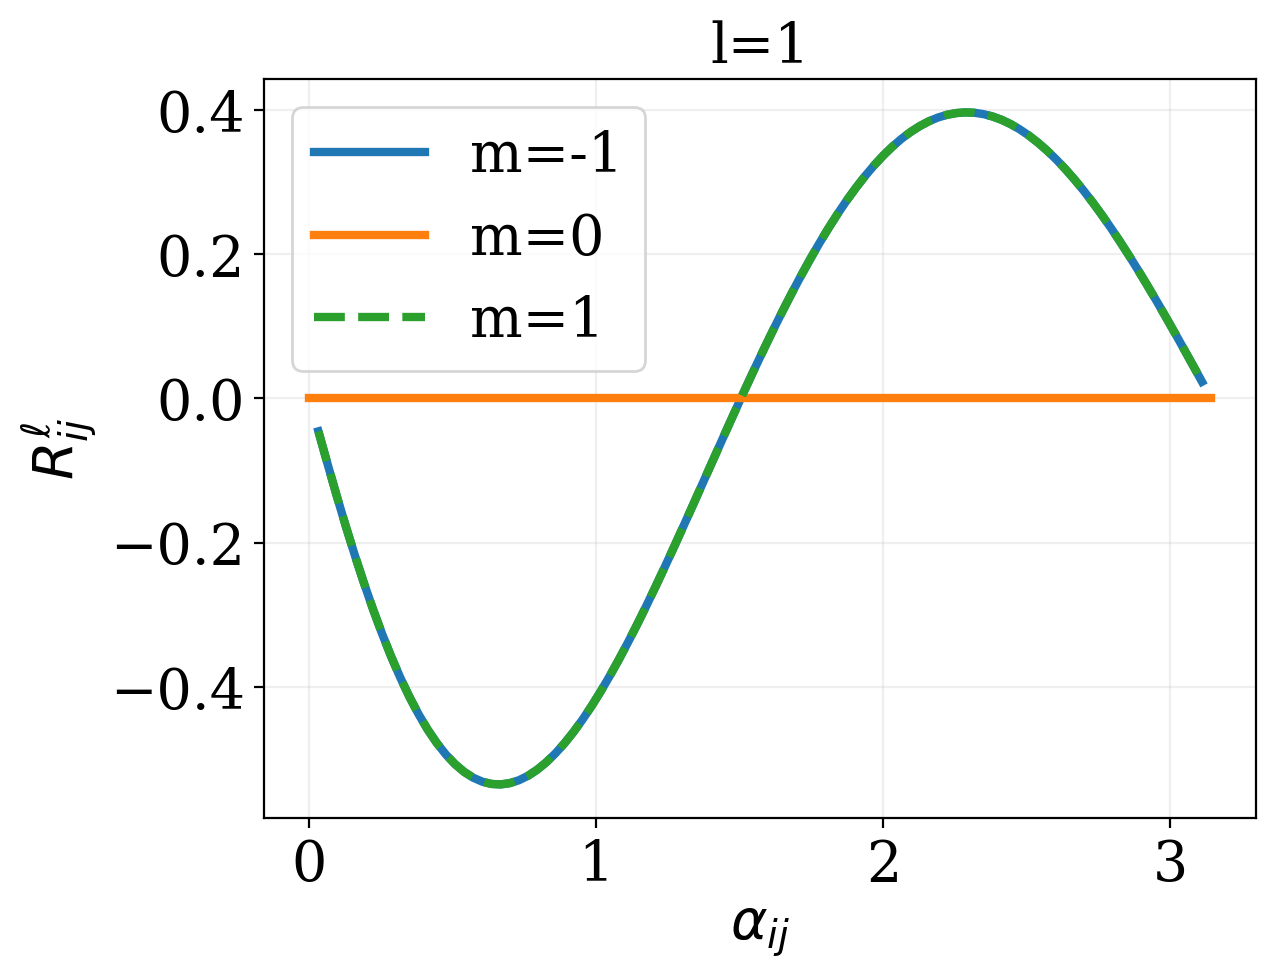

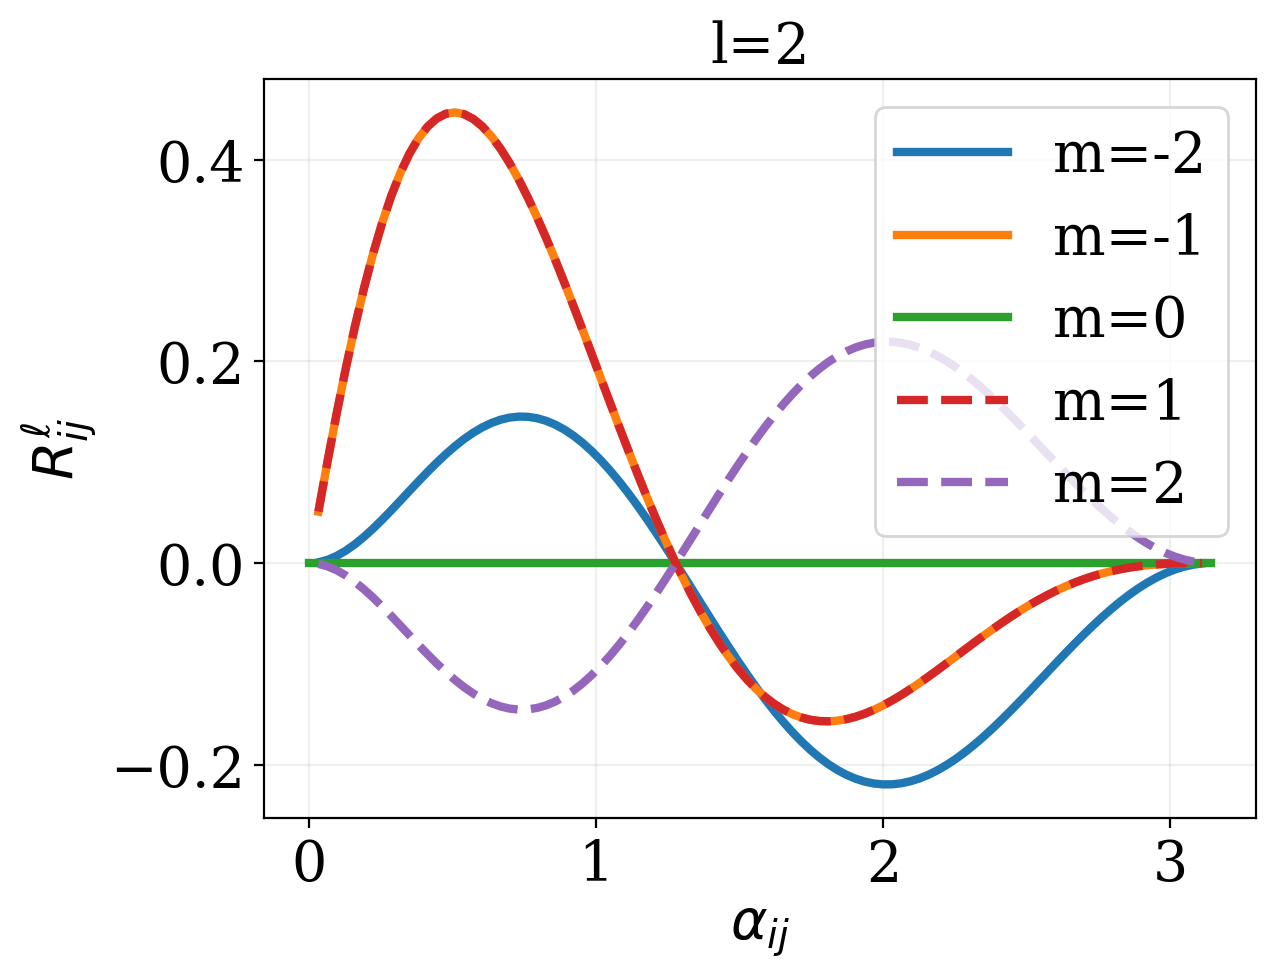

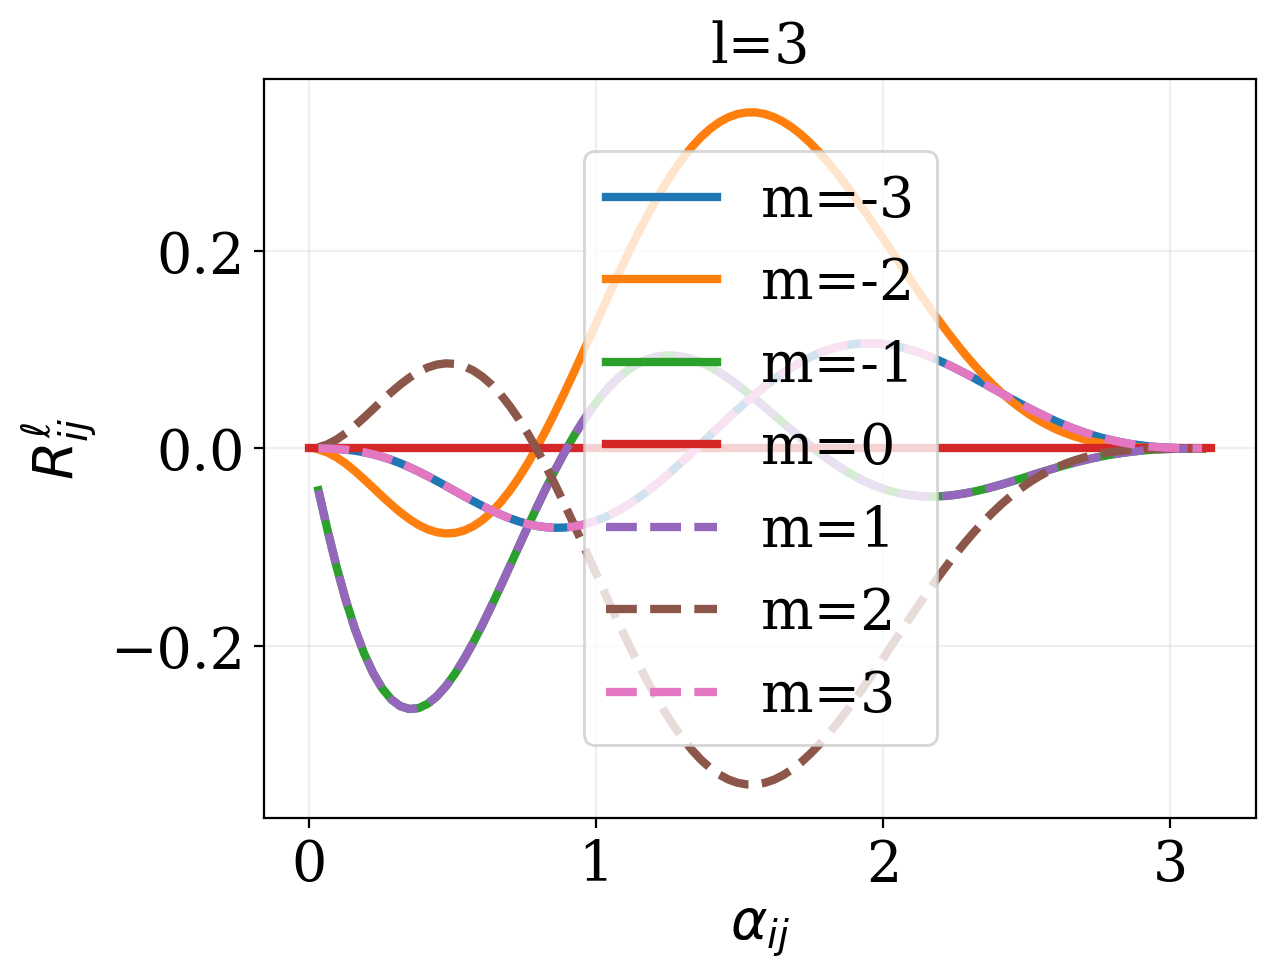

In [49]:
alpha = np.linspace(0, np.pi, 100)

# l = 0

plt.plot(alpha, RV_0(alpha), label='m=0')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=0')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 1
plt.plot(alpha, RV_1_1(alpha), label='m=-1')
plt.plot(alpha, RV_10(alpha), label='m=0')
plt.plot(alpha, RV_11(alpha), label='m=1', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=1')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 2
plt.plot(alpha, RV_2_2(alpha), label='m=-2')
plt.plot(alpha, RV_2_1(alpha), label='m=-1')
plt.plot(alpha, RV_20(alpha), label='m=0')
plt.plot(alpha, RV_21(alpha), label='m=1', linestyle = '--')
plt.plot(alpha, RV_22(alpha), label='m=2', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=2')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 3
plt.plot(alpha, RV_3_3(alpha), label='m=-3')
plt.plot(alpha, RV_3_2(alpha), label='m=-2')
plt.plot(alpha, RV_3_1(alpha), label='m=-1')
plt.plot(alpha, RV_3_0(alpha), label='m=0')
plt.plot(alpha, RV_31(alpha), label='m=1', linestyle = '--')
plt.plot(alpha, RV_32(alpha), label='m=2', linestyle = '--')
plt.plot(alpha, RV_33(alpha), label='m=3', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=3')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()


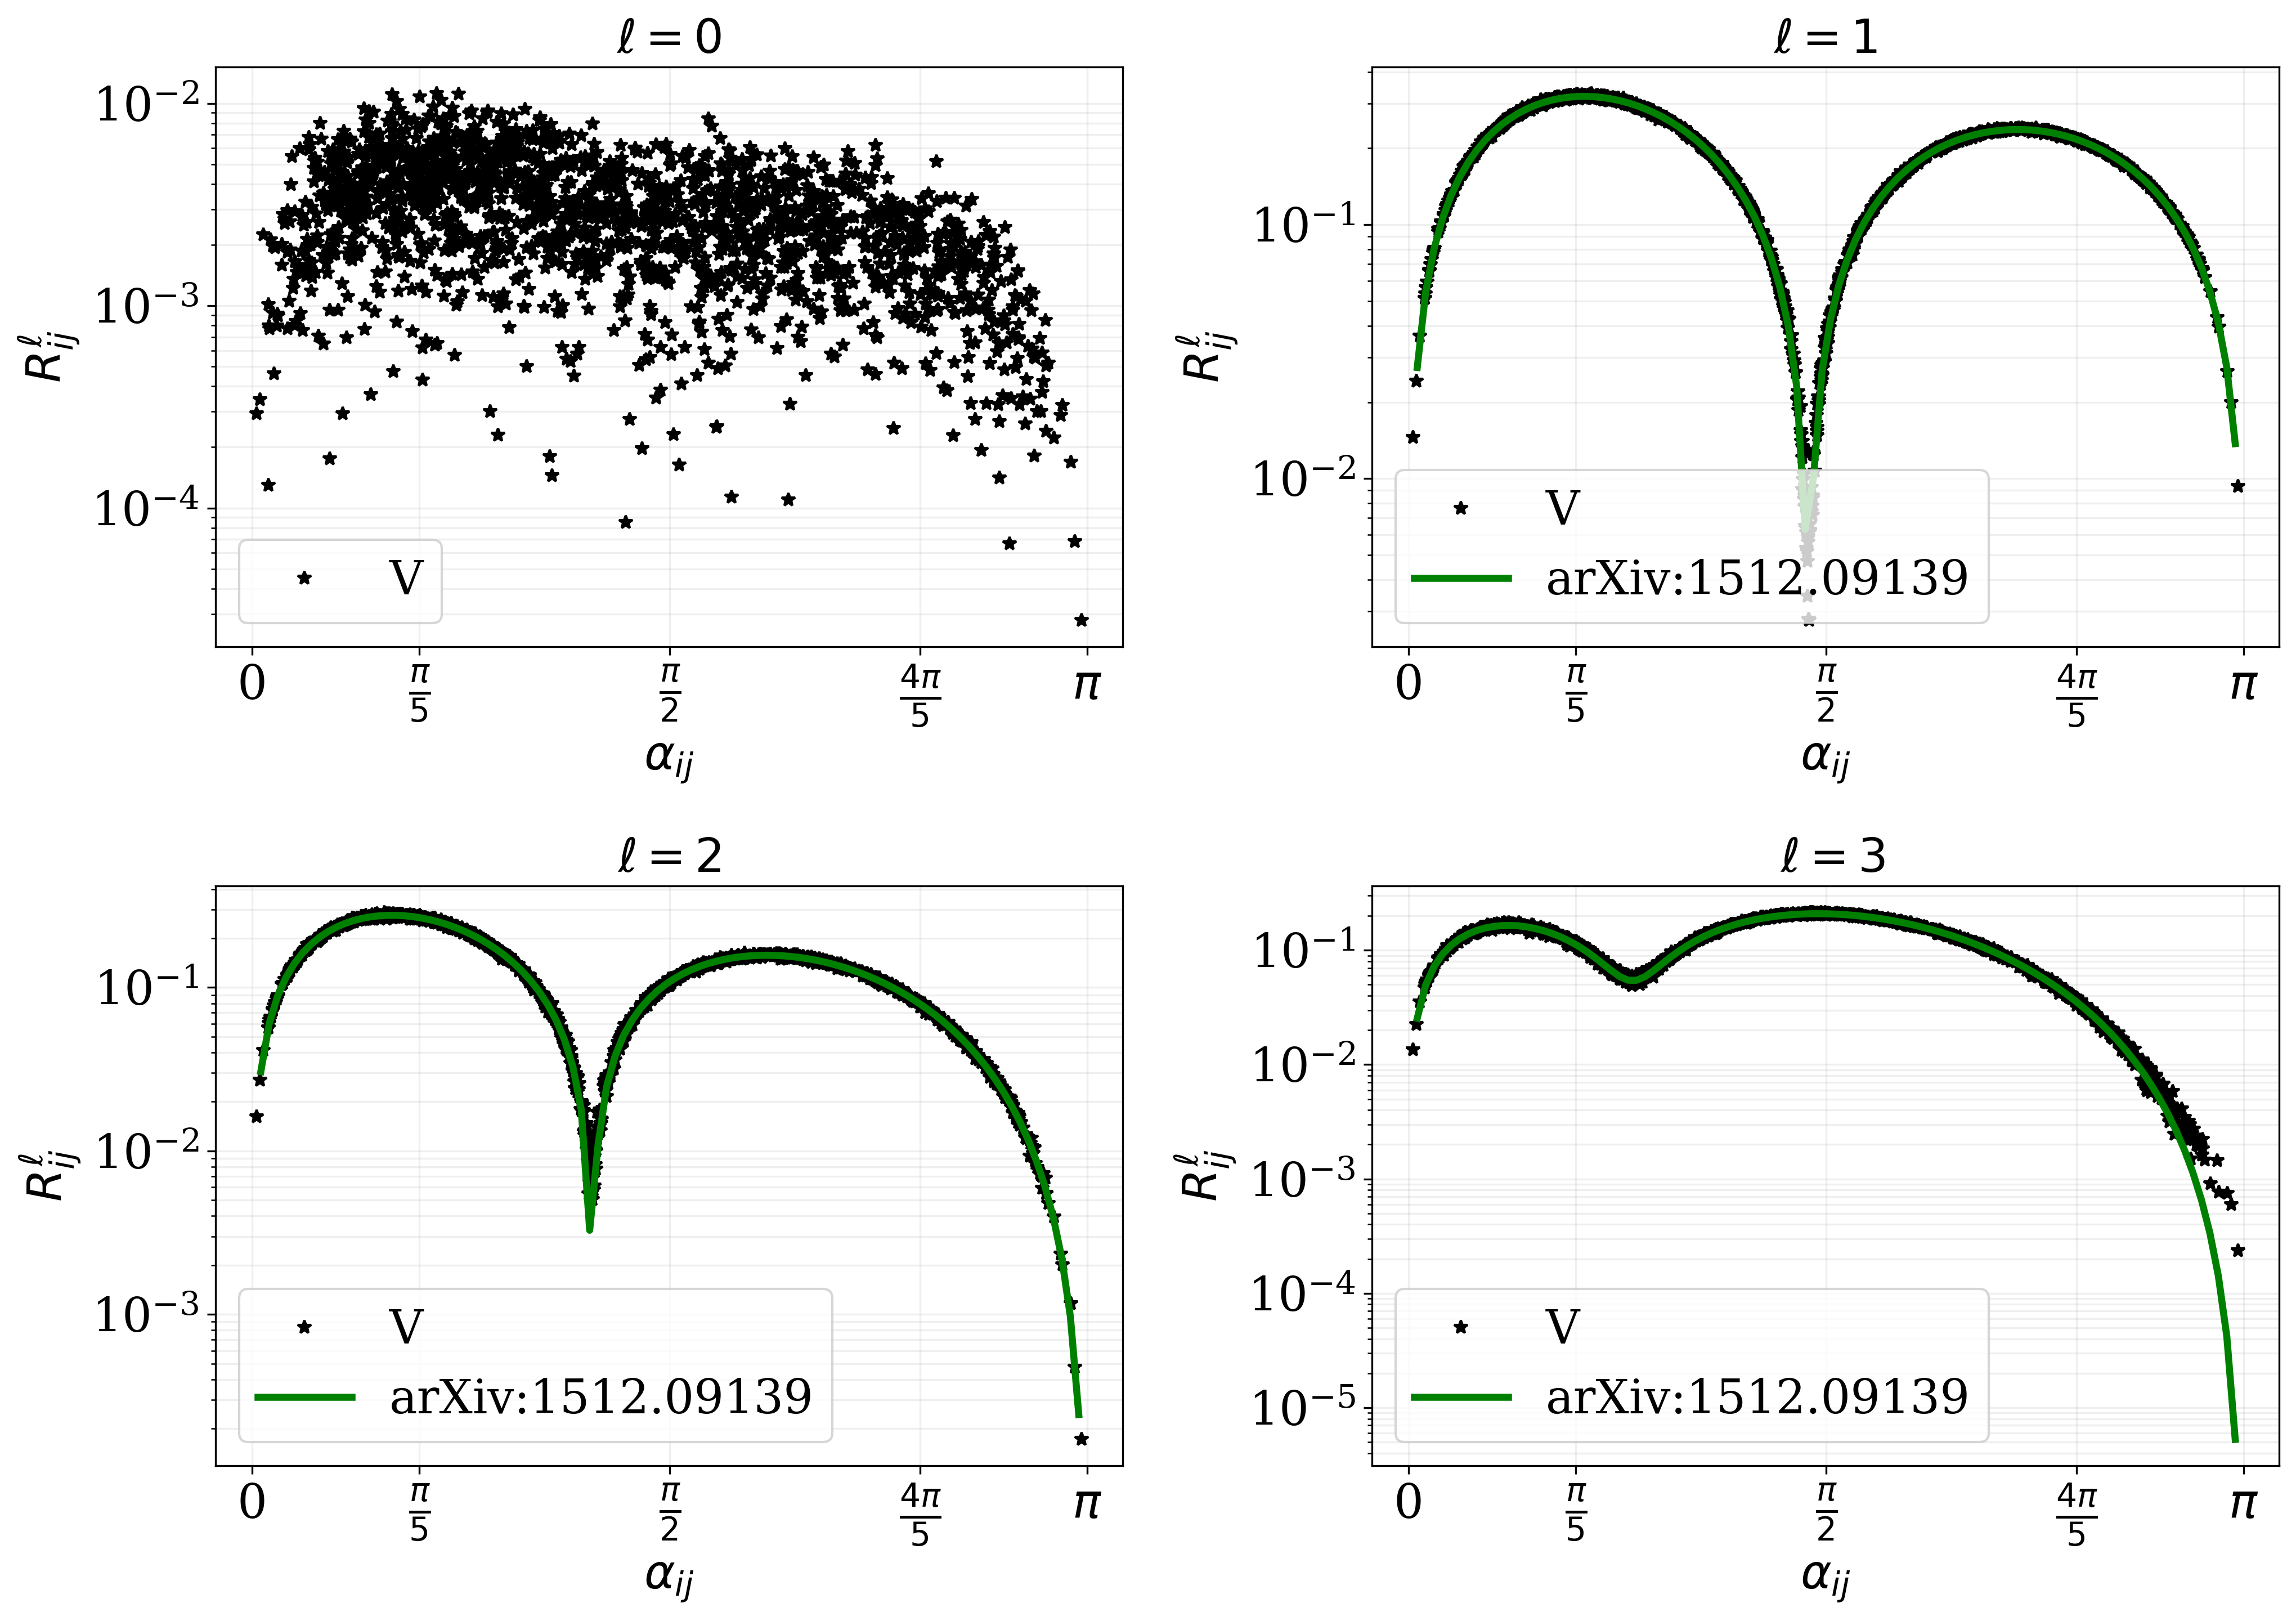

In [55]:
# plot

# plot 2x2 dove in ogni blocco c'è un multipolo

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Definizione dei tick personalizzati
custom_ticks = [0, np.pi / 5, np.pi / 2, 4 * np.pi / 5, np.pi]

norm = 3*np.sqrt(4*np.pi)/(8*np.pi)

# Plot per ℓ=0
ax[0, 0].semilogy(alpha_ij, np.abs(gamma0_ij_V_f_index), '*', color='black', label='V')
#ax[0, 0].semilogy(alpha, norm*np.abs(RV_0(alpha)), color='red', label='ref.')
ax[0, 0].set_xlabel(r'$\alpha_{ij}$')
ax[0, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 0].grid(which='both', alpha=0.2)
ax[0, 0].set_title(r'$\ell=0$')
ax[0, 0].set_xticks(custom_ticks)
ax[0, 0].legend()
ax[0, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=1
ax[0, 1].semilogy(alpha_ij, gamma1_ij_V_f_index, '*', color='black', label='V')
ax[0, 1].semilogy(alpha, norm*RV_1(alpha), color='green', label='arXiv:1512.09139')
ax[0, 1].set_xlabel(r'$\alpha_{ij}$')
ax[0, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 1].grid(which='both', alpha=0.2)
ax[0, 1].set_title(r'$\ell=1$')
ax[0, 1].set_xticks(custom_ticks)
ax[0, 1].legend()
ax[0, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=2
ax[1, 0].semilogy(alpha_ij, gamma2_ij_V_f_index, '*', color='black', label='V')
ax[1, 0].semilogy(alpha, norm*RV_2(alpha), color='green', label='arXiv:1512.09139')
ax[1, 0].set_xlabel(r'$\alpha_{ij}$')
ax[1, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 0].grid(which='both', alpha=0.2)
ax[1, 0].set_title(r'$\ell=2$')
ax[1, 0].set_xticks(custom_ticks)
ax[1, 0].legend()
ax[1, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=3
ax[1, 1].semilogy(alpha_ij, gamma3_ij_V_f_index, '*', color='black', label='V')
ax[1, 1].semilogy(alpha, norm*RV_3(alpha), color='green', label='arXiv:1512.09139')
ax[1, 1].set_xlabel(r'$\alpha_{ij}$')
ax[1, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 1].grid(which='both', alpha=0.2)
ax[1, 1].set_title(r' $\ell=3$')
ax[1, 1].set_xticks(custom_ticks)
ax[1, 1].legend()
ax[1, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

plt.tight_layout()
plt.show()


Quick checks and tests for the pulsar term in V

In [622]:

gamma_ij_V = []
alpha_ij = []
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma_ij_V.append(Response.pairwise_overlap(f, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],'V'))

gamma_ij_V = np.array(gamma_ij_V)
alpha_ij = np.array(alpha_ij)

In [626]:
print(gamma_ij_V.shape)
print(gamma_ij_V)

(105, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


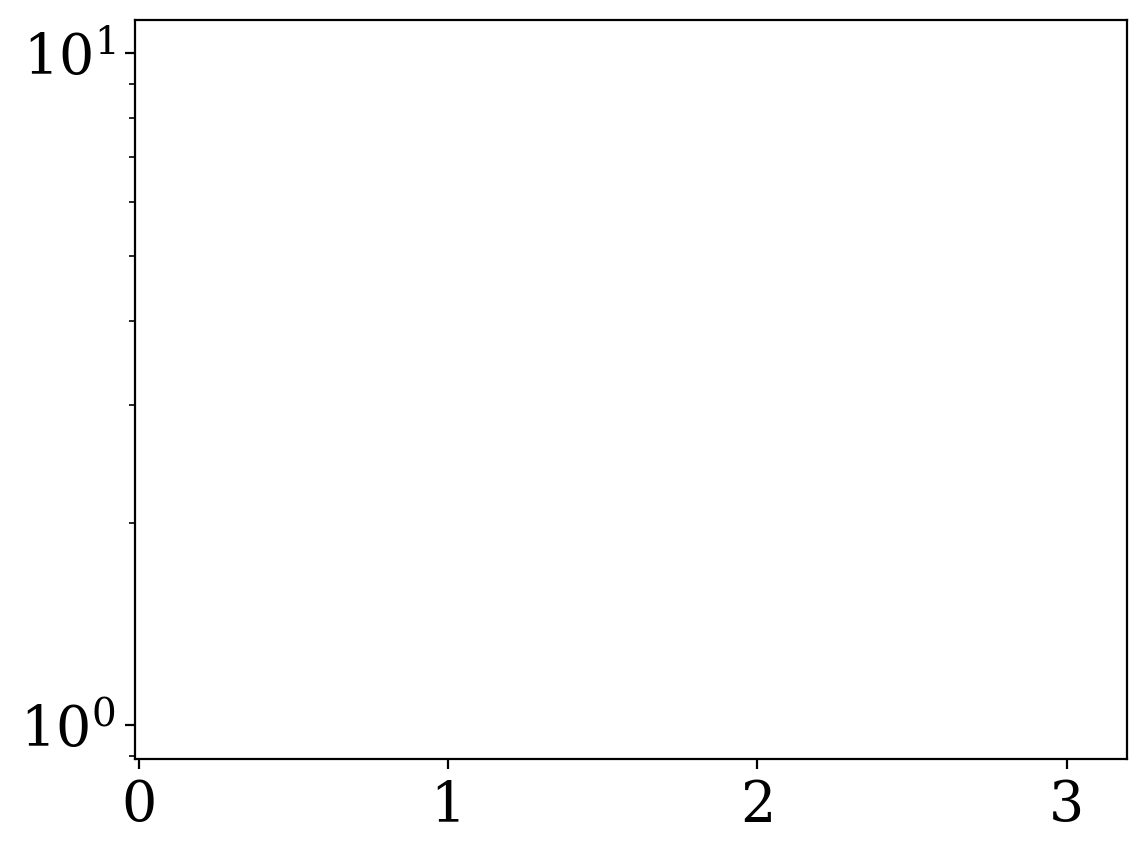

In [625]:
# plot 


plt.semilogy(alpha_ij, np.abs(gamma_ij_V[:, f_index]), '*', color='black', label='V')
